In [1]:
import pandas as pd
import numpy as np
from operator import add
import seaborn as sns
from datetime import datetime

import sklearn
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, r2_score

import platform
from matplotlib import font_manager, rc
import matplotlib.pyplot as plt
if platform.system() == 'Windows':
# 윈도우인 경우
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
else:    
# Mac 인 경우
    rc('font', family='AppleGothic')
    
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.autolayout'] = True
plt.rcParams['axes.facecolor'] = '#FCFCFC' 
plt.rcParams['grid.alpha'] = 1
plt.rcParams['grid.color'] = "#CCCCCC"
plt.rcParams['figure.figsize'] = (13, 8)
plt.rcParams.update({'font.size': 13})
color_list = [
    '#FF6666', '#FFB266', '#B2FF66',
    '#66FFB2', '#66FFFF', '#66B2FF',
    '#6666FF', '#B266FF', '#FF66FF',
    '#83DCB7', '#50BCDF', '#437299',
    '#0080FF', '#F29886'
]

import warnings
warnings.filterwarnings('ignore')

fast = False
start_log = datetime.now()

from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.test.is_gpu_available():
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")

Using TensorFlow backend.


No GPU was detected. LSTMs and CNNs can be very slow without a GPU.


In [2]:
## Get data
import os
last_update = '2020-05-31'
print(f'[Dataset list]\n# updated on %s'%last_update)
file_paths_raw = []
for dirname, _, filenames in os.walk('./coronavirusdataset/DS4C0531/'):
    for filename in filenames:
        file_paths_raw.append(os.path.join(dirname, filename))
file_names = ['TimeAge.csv', 'TimeProvince.csv', 'Region.csv', 'TimeGender.csv'
              , 'Time.csv', 'Case.csv', 'Weather.csv', 'PatientInfo.csv'
              , 'PatientRoute.csv', 'SeoulFloating.csv', 'SearchTrend.csv', 'Policy.csv']
file_paths = [ j for i in file_names for j in file_paths_raw if i in j ]
file_paths

[Dataset list]
# updated on 2020-05-31


['./coronavirusdataset/DS4C0531/TimeAge.csv',
 './coronavirusdataset/DS4C0531/TimeProvince.csv',
 './coronavirusdataset/DS4C0531/Region.csv',
 './coronavirusdataset/DS4C0531/TimeGender.csv',
 './coronavirusdataset/DS4C0531/Time.csv',
 './coronavirusdataset/DS4C0531/Case.csv',
 './coronavirusdataset/DS4C0531/Weather.csv',
 './coronavirusdataset/DS4C0531/PatientInfo.csv',
 './coronavirusdataset/DS4C0531/PatientRoute.csv',
 './coronavirusdataset/DS4C0531/SeoulFloating.csv',
 './coronavirusdataset/DS4C0531/SearchTrend.csv',
 './coronavirusdataset/DS4C0531/Policy.csv']

In [3]:
## Get / Check data
age_raw = pd.read_csv(file_paths[0])
age_list = age_raw.age.unique() # 80s == 80s and older
data_col = pd.to_datetime(age_raw['date']).dt.date
print('Age groups:', age_list)

Age groups: ['0s' '10s' '20s' '30s' '40s' '50s' '60s' '70s' '80s']


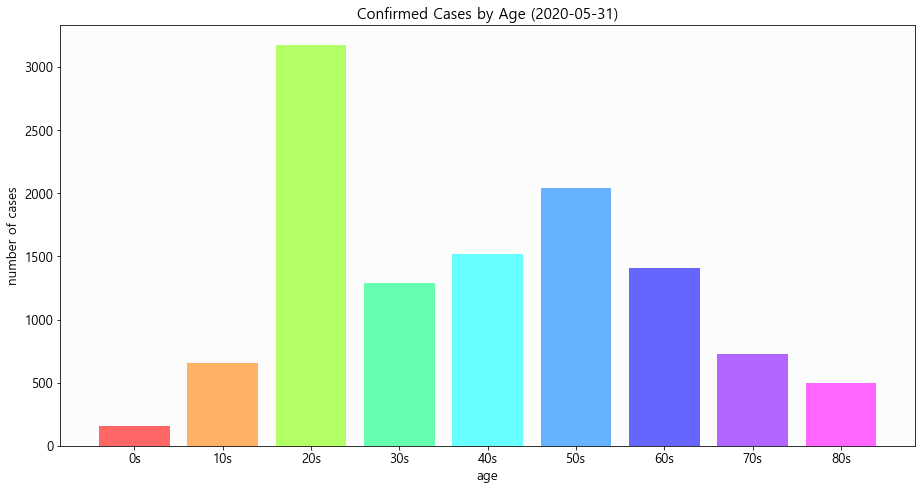

In [4]:
fig, ax = plt.subplots(figsize=(13, 7))
plt.title(f'Confirmed Cases by Age ({last_update})', fontsize=15)
#sns.barplot(age_list, age_raw.confirmed[-9:])
ax.bar(age_list, age_raw.confirmed[-9:], color=color_list)
ax.set_xlabel('age', size=13)
ax.set_ylabel('number of cases', size=13)
plt.show()

In [5]:
# Get population distribution table
pop_order = pd.DataFrame()
pop_order['age'] = age_list
pop_order['population'] = (4055740, 4732100, 6971785, 7203550, 8291728, 8587047, 6472987, 3591533, 1874109)
pop_order['proportion'] = round(pop_order['population']/sum(pop_order['population']) * 100, 2)
pop_order = pop_order.sort_values('population', ascending=False)
pop_order.set_index(np.arange(1, 10), inplace=True)
pop_order

age  population  proportion
1  50s     8587047       16.58
2  40s     8291728       16.01
3  30s     7203550       13.91
4  20s     6971785       13.46
5  60s     6472987       12.50
6  10s     4732100        9.14
7   0s     4055740        7.83
8  70s     3591533        6.94
9  80s     1874109        3.62

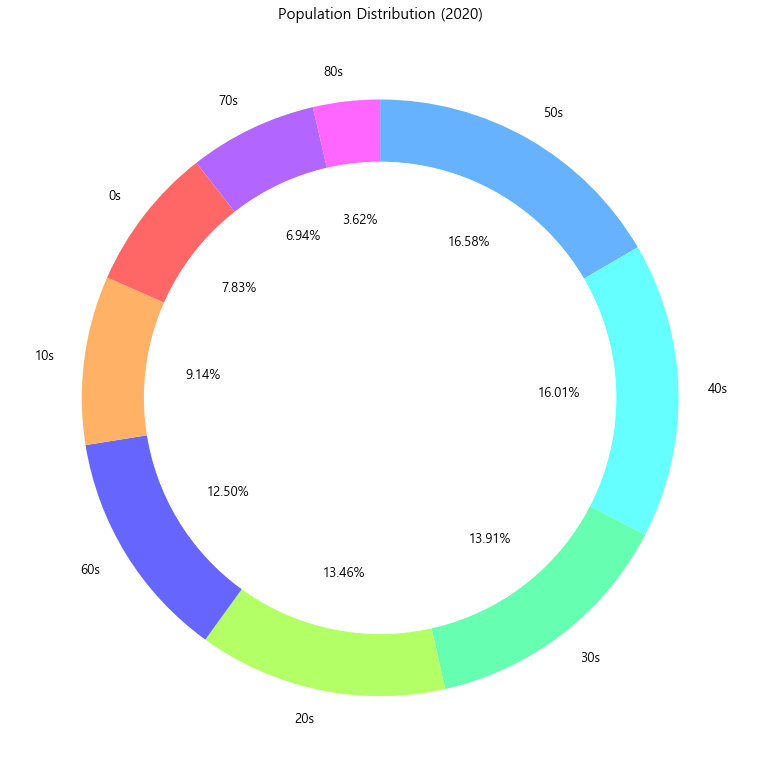

In [6]:
# Distribution Graph
# code source: https://python-graph-gallery.com/162-change-background-of-donut-plot/
color_pie = [color_list[5], color_list[4], color_list[3]
             , color_list[2], color_list[6], color_list[1]
             , color_list[0], color_list[7], color_list[8]]
fig, ax = plt.subplots(figsize=(11, 11))
plt.title('Population Distribution (2020)', fontsize=15)
pop_circle = plt.Circle((0,0), 0.79, color='white')
plt.pie(pop_order.proportion
        , labels = pop_order.age
        , autopct = '%.2f%%'
        , colors = color_pie
        , startangle=90
        , counterclock=False)
p=plt.gcf()
p.gca().add_artist(pop_circle)
plt.show()

In [7]:
# get a new table with population / proportion by age
confirmed_by_population = pop_order.sort_values('age')
confirmed_by_population['confirmed'] = list(age_raw[-9:].confirmed)
# get confirmed ratio regarding population
confirmed_by_population['confirmed_rate'] = confirmed_by_population['confirmed']/confirmed_by_population['population'] * 100;
confirmed_by_population

age  population  proportion  confirmed  confirmed_rate
7   0s     4055740        7.83        157        0.003871
6  10s     4732100        9.14        655        0.013842
4  20s     6971785       13.46       3176        0.045555
3  30s     7203550       13.91       1292        0.017936
2  40s     8291728       16.01       1521        0.018344
1  50s     8587047       16.58       2039        0.023745
5  60s     6472987       12.50       1405        0.021706
8  70s     3591533        6.94        725        0.020186
9  80s     1874109        3.62        498        0.026573

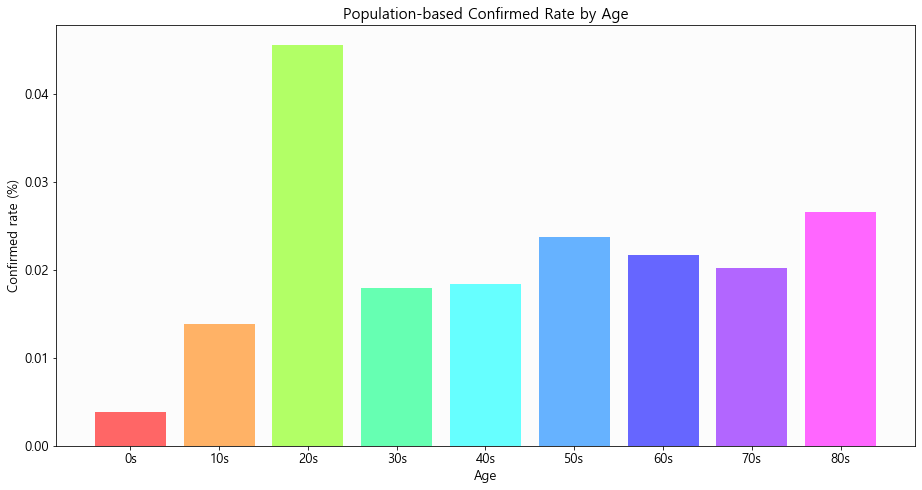

In [8]:
fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Population-based Confirmed Rate by Age', fontsize=15)
ax.bar(age_list, confirmed_by_population.confirmed_rate[-9:], color=color_list)
ax.set_xlabel('Age', size=13)
ax.set_ylabel('Confirmed rate (%)', size=13)
plt.show()

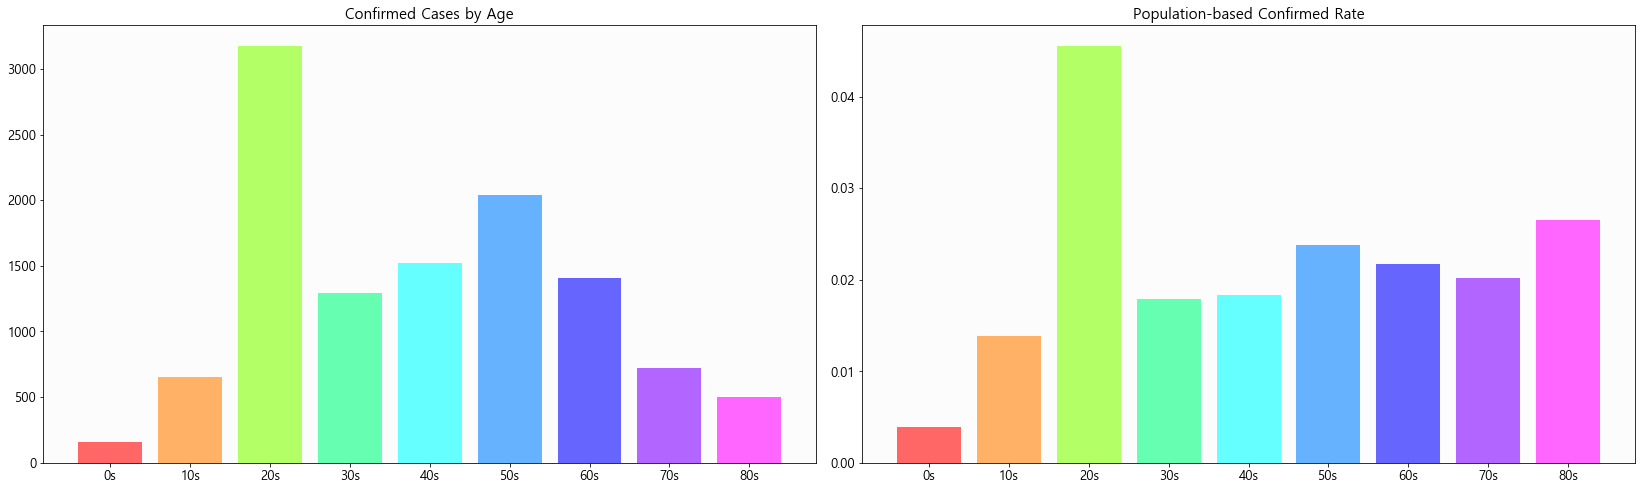

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(23, 7))

axes[0].set_title('Confirmed Cases by Age', fontsize=15)
axes[0].bar(age_list, confirmed_by_population.confirmed, color=color_list)

axes[1].set_title('Population-based Confirmed Rate', fontsize=15)
axes[1].bar(age_list, confirmed_by_population.confirmed_rate, color=color_list)

plt.show()

In [10]:
# Save raw data before manipulating the copy
age_time = age_raw.copy()
# delete unnecessary column
print(age_time.time.describe())
del age_time['time']
age_time.tail(3)

count    819.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: time, dtype: float64


date  age  confirmed  deceased
816  2020-05-31  60s       1405        39
817  2020-05-31  70s        725        80
818  2020-05-31  80s        498       131

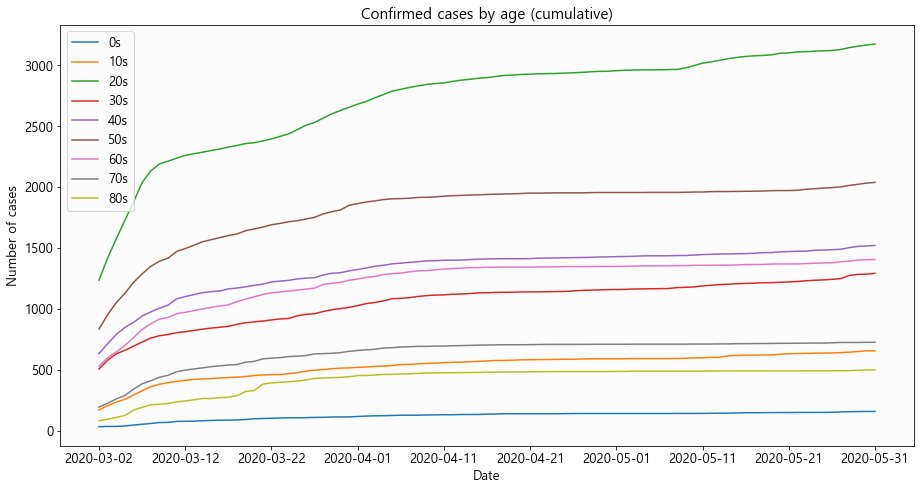

In [11]:
fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Confirmed cases by age (cumulative)', fontsize=15)
ax.set_xlabel('Date', size=13)
ax.set_ylabel('Number of cases', size=13)
confirmed_set = age_time.confirmed.groupby(age_time.age)
for confirmed_each, age_each in zip(confirmed_set, age_list):
    plt.plot(age_time.date.unique(), confirmed_each[1], label=age_each)
ax.set_xticks(ax.get_xticks()[::10])
ax.legend()
plt.show()

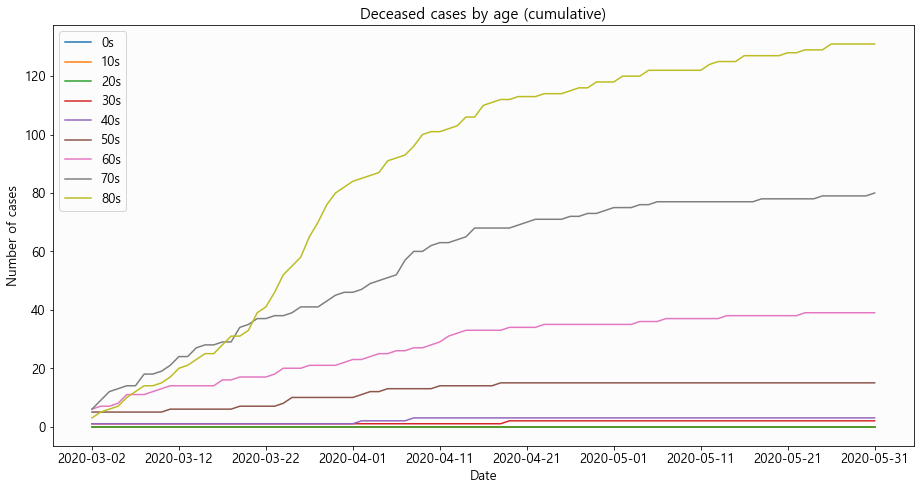

In [12]:
fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Deceased cases by age (cumulative)', fontsize=15)
ax.set_xlabel('Date', size=13)
ax.set_ylabel('Number of cases', size=13)
deceased_set = age_time.deceased.groupby(age_time.age)
for deceased_each, age_each in zip(deceased_set, age_list):
    plt.plot(age_time.date.unique(), deceased_each[1], label=age_each)
ax.set_xticks(ax.get_xticks()[::10])
ax.legend()
plt.show()

In [13]:
age_deceased = age_time.tail(9)[['age', 'deceased']]
age_deceased.set_index(np.arange(0, len(age_time.age.unique())), inplace=True)
print('[Latest numbers of deceased cases]')
age_deceased.T

[Latest numbers of deceased cases]


0    1    2    3    4    5    6    7    8
age       0s  10s  20s  30s  40s  50s  60s  70s  80s
deceased   0    0    0    2    3   15   39   80  131

In [14]:
# Get population distribution table
pop_order = pd.DataFrame()
pop_order['age'] = age_list
pop_order['population'] = (4055740, 4732100, 6971785, 7203550, 8291728, 8587047, 6472987, 3591533, 1874109)
pop_order['proportion'] = round(pop_order['population']/sum(pop_order['population']) * 100, 2)
pop_order = pop_order.sort_values('population', ascending=False)
pop_order.set_index(np.arange(1, 10), inplace=True)
pop_order

age  population  proportion
1  50s     8587047       16.58
2  40s     8291728       16.01
3  30s     7203550       13.91
4  20s     6971785       13.46
5  60s     6472987       12.50
6  10s     4732100        9.14
7   0s     4055740        7.83
8  70s     3591533        6.94
9  80s     1874109        3.62

In [15]:
age_raw = pd.read_csv(file_paths[0])
display(age_raw.head(3).append(age_raw.tail(3)))
data_col = pd.to_datetime(age_raw['date']).dt.date
date_range = (max(data_col) - min(data_col)).days + 1
print(f'Date range: {date_range} days')
print(f'# {min(data_col)} to {max(data_col)}')
age_list = age_raw.age.unique() # 80s == 80s and older
print('Age groups:', age_list)

date  time  age  confirmed  deceased
0    2020-03-02     0   0s         32         0
1    2020-03-02     0  10s        169         0
2    2020-03-02     0  20s       1235         0
816  2020-05-31     0  60s       1405        39
817  2020-05-31     0  70s        725        80
818  2020-05-31     0  80s        498       131

Date range: 91 days
# 2020-03-02 to 2020-05-31
Age groups: ['0s' '10s' '20s' '30s' '40s' '50s' '60s' '70s' '80s']


[Compare three graphs]


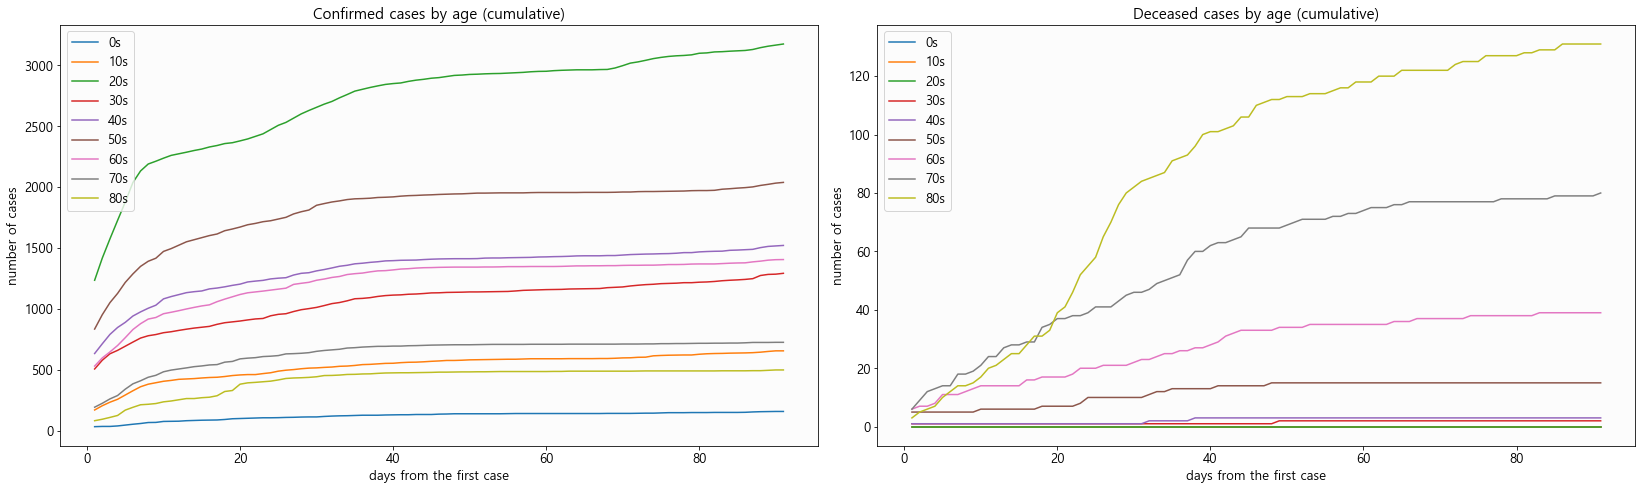

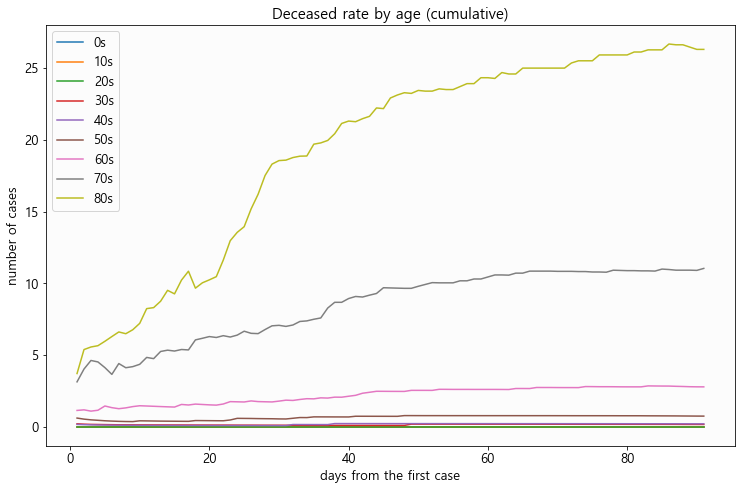

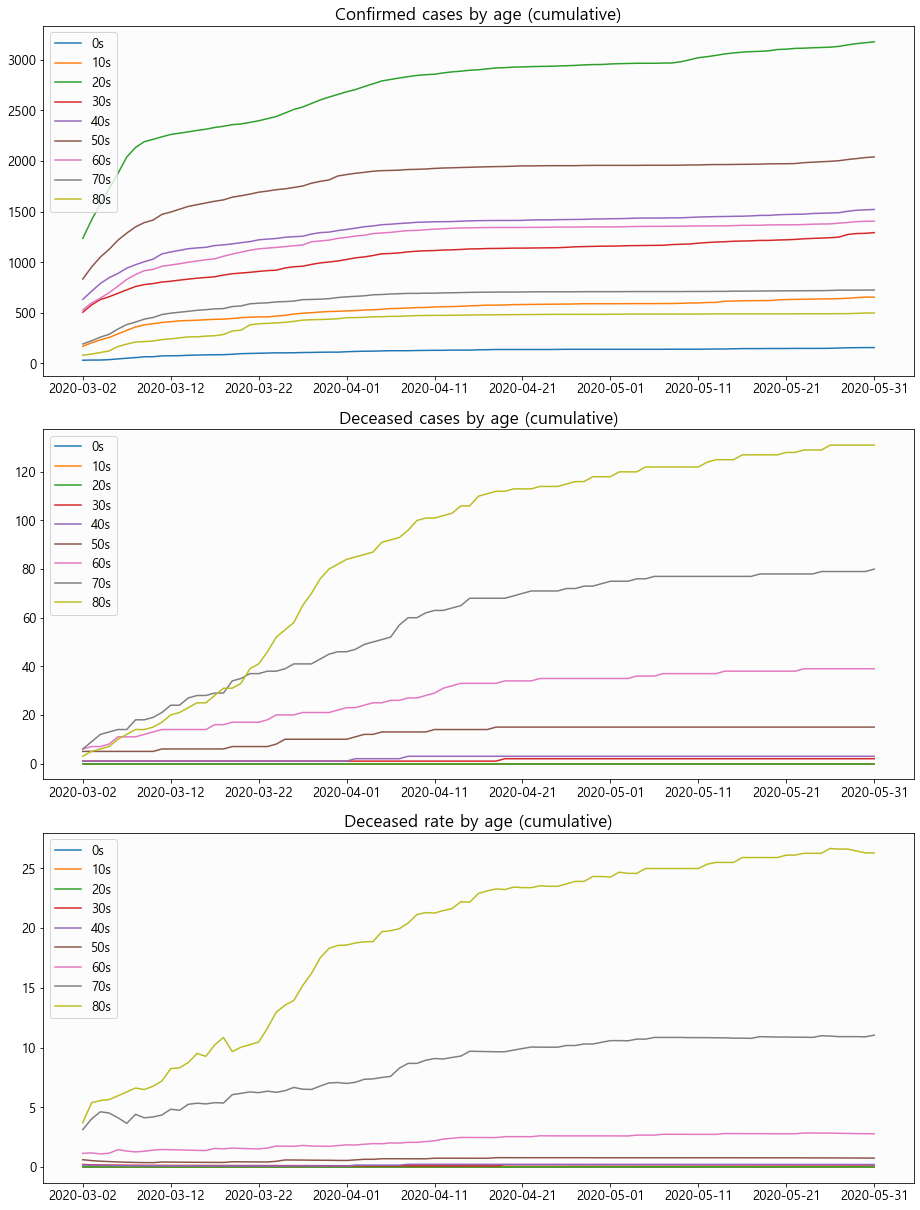

In [16]:
if not fast:
    print('[Compare three graphs]')
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(23, 7))
    ## 1. Two plots for the absolute number
    axes[0].set_title('Confirmed cases by age (cumulative)', fontsize=15)
    axes[0].set_xlabel('days from the first case', size=13)
    axes[0].set_ylabel('number of cases', size=13)
    confirmed_set = age_time.confirmed.groupby(age_time.age)
    for confirmed_each, age_each in zip(confirmed_set, age_list):
        axes[0].plot(np.arange(1,len(age_time.date.unique())+1), confirmed_each[1], label=age_each)
    axes[0].legend()
    axes[1].set_title('Deceased cases by age (cumulative)', fontsize=15)
    axes[1].set_xlabel('days from the first case', size=13)
    axes[1].set_ylabel('number of cases', size=13)
    deceased_set = age_time.deceased.groupby(age_time.age)
    for deceased_each, age_each in zip(deceased_set, age_list):
        axes[1].plot(np.arange(1,len(age_time.date.unique())+1), deceased_each[1], label=age_each)
    axes[1].legend()
    ## 2. One plot for the relative rate
    fig, ax = plt.subplots(figsize=(10.5, 7))
    plt.title('Deceased rate by age (cumulative)', fontsize=15)
    ax.set_xlabel('days from the first case', size=13)
    ax.set_ylabel('number of cases', size=13)
    ratio_set = (age_time.deceased/age_time.confirmed * 100.0).groupby(age_time.age)
    for ratio_each, age_each in zip(ratio_set, age_list):
        plt.plot(np.arange(1,len(age_time.date.unique())+1), ratio_each[1], label=age_each)
    ax.legend()
    plt.show()

## 3. Three plots in a row
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(13, 17))
sub_list = [age_time.confirmed, age_time.deceased, (age_time.deceased/age_time.confirmed * 100.0)]
title_list = ['Confirmed cases', 'Deceased cases', 'Deceased rate']
for sub, i, title in zip(sub_list, range(len(sub_list)), title_list):
    axes[i].set_title(f'{title} by age (cumulative)', fontsize=17)
    confirmed_set = sub.groupby(age_time.age)
    for confirmed_each, age_each in zip(confirmed_set, age_list):
        axes[i].plot(age_time.date.unique(), confirmed_each[1], label=age_each)
    axes[i].set_xticks(axes[i].get_xticks()[::10])
    axes[i].legend()

In [17]:
location_raw = pd.read_csv(file_paths[1])
display(location_raw.head(3).append(location_raw.tail(3)))
data_col = pd.to_datetime(location_raw['date']).dt.date
date_range = (max(data_col) - min(data_col)).days + 1
print(f'Date range: {date_range} days')
print(f'# {min(data_col)} to {max(data_col)}')

date  time          province  confirmed  released  deceased
0     2020-01-20    16             Seoul          0         0         0
1     2020-01-20    16             Busan          0         0         0
2     2020-01-20    16             Daegu          0         0         0
2258  2020-05-31     0  Gyeongsangbuk-do       1379      1295        54
2259  2020-05-31     0  Gyeongsangnam-do        123       121         0
2260  2020-05-31     0           Jeju-do         15        13         0

Date range: 133 days
# 2020-01-20 to 2020-05-31


In [18]:
# There are 17 provinces (we call it location from now on)
    # as there are cities in the columns too
print('Number of locations:', len(location_raw.province.unique()))
print('Number of logs per location:', len(location_raw[location_raw.province=='Jeju-do']))
print('Locations * logs:', len(location_raw.province.unique()) * len(location_raw[location_raw.province=='Jeju-do']))
print('Number of rows:', len(location_raw))

Number of locations: 17
Number of logs per location: 133
Locations * logs: 2261
Number of rows: 2261


In [19]:
location_raw.describe().T.iloc[1:, 1:]

mean          std  min  25%   50%    75%     max
confirmed  391.320212  1291.888948  0.0  3.0  30.0  117.0  6883.0
released   255.985847   993.309392  0.0  0.0  12.0   56.0  6607.0
deceased     7.641751    28.890377  0.0  0.0   0.0    1.0   185.0

In [20]:
# Get the latest distribution of cumulative confirmed cases
loc_latest = location_raw[location_raw.date==location_raw.date.iloc[-1]]
del loc_latest['date']
del loc_latest['time']
loc_latest = loc_latest.iloc[:, :2]
loc_latest['proportion'] = round(loc_latest.confirmed / sum(loc_latest.confirmed) * 100, 2)
loc_latest = loc_latest.sort_values('proportion', ascending=False)
loc_latest.set_index(np.arange(1, len(loc_latest)+1), inplace=True)
loc_latest_all = loc_latest.copy()
loc_latest_all

province  confirmed  proportion
1               Daegu       6883       62.95
2    Gyeongsangbuk-do       1379       12.61
3               Seoul        861        7.87
4         Gyeonggi-do        840        7.68
5             Incheon        206        1.88
6               Busan        147        1.34
7   Chungcheongnam-do        146        1.34
8    Gyeongsangnam-do        123        1.12
9   Chungcheongbuk-do         60        0.55
10         Gangwon-do         57        0.52
11              Ulsan         52        0.48
12             Sejong         47        0.43
13            Daejeon         46        0.42
14            Gwangju         32        0.29
15       Jeollabuk-do         21        0.19
16       Jeollanam-do         19        0.17
17            Jeju-do         15        0.14

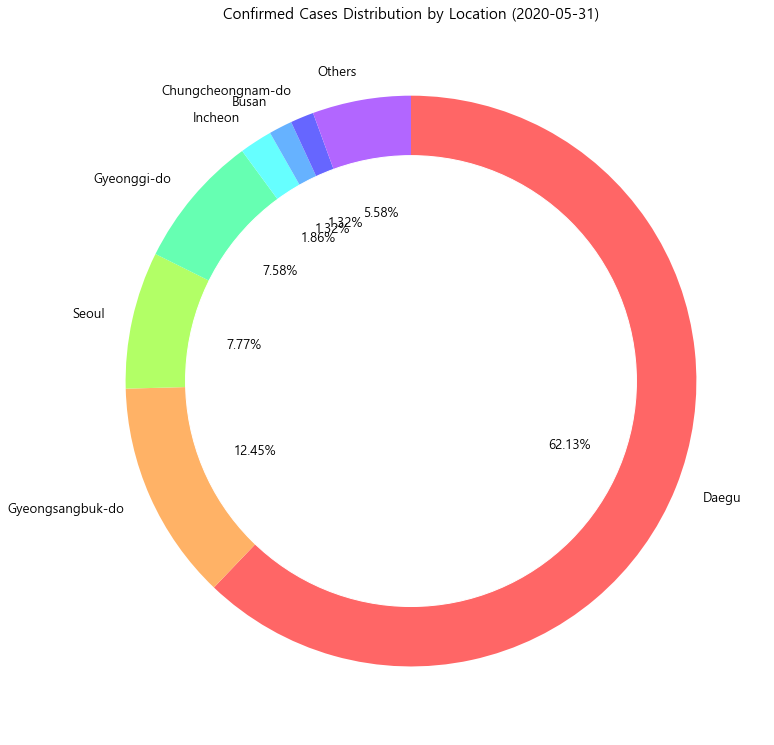

In [21]:
# Put other than the 6 locations with most cases into others
loc_latest.loc['18',:] = loc_latest.iloc[6:, :].sum()
loc_latest.loc['18','province'] = 'Others'
loc_latest = loc_latest[loc_latest.proportion >= loc_latest.iloc[5, 2]]
loc_latest

# Distribution Graph
fig, ax = plt.subplots(figsize=(11, 11))
colors = color_list
plt.title(f'Confirmed Cases Distribution by Location ({last_update})', fontsize=15)
pop_circle=plt.Circle((0,0), 0.79, color='white')
plt.pie(loc_latest.proportion
        , labels=loc_latest.province
        , autopct='%.2f%%'
        , colors=colors
        , startangle=90
        , counterclock=False
       )
p=plt.gcf()
p.gca().add_artist(pop_circle)
plt.show()

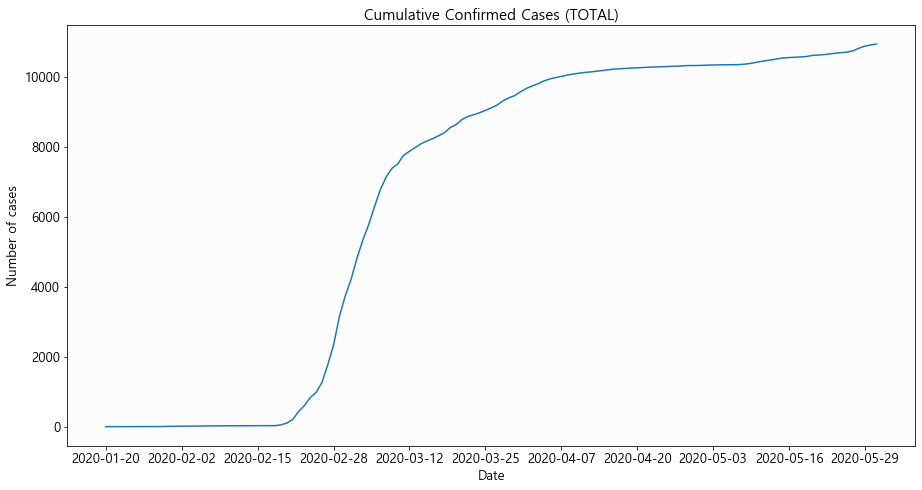

In [22]:
# Total		
total_list = location_raw.groupby('date').sum().confirmed

fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Cumulative Confirmed Cases (TOTAL)', fontsize=15)
ax.set_xlabel('Date', size=13)
ax.set_ylabel('Number of cases', size=13)
plt.plot(location_raw.date.unique()
         , location_raw.groupby('date').sum().confirmed)
ax.set_xticks(ax.get_xticks()[::13])
plt.show()

In [23]:
pd.DataFrame(total_list[total_list<=104].tail(3)).T

date       2020-02-18  2020-02-19  2020-02-20
confirmed          30          52         104

In [24]:
pd.DataFrame(total_list[total_list>=7900].head(3)).T

date       2020-03-13  2020-03-14  2020-03-15
confirmed        7979        8086        8162

[Confirmed Cases in each location (most to least)]


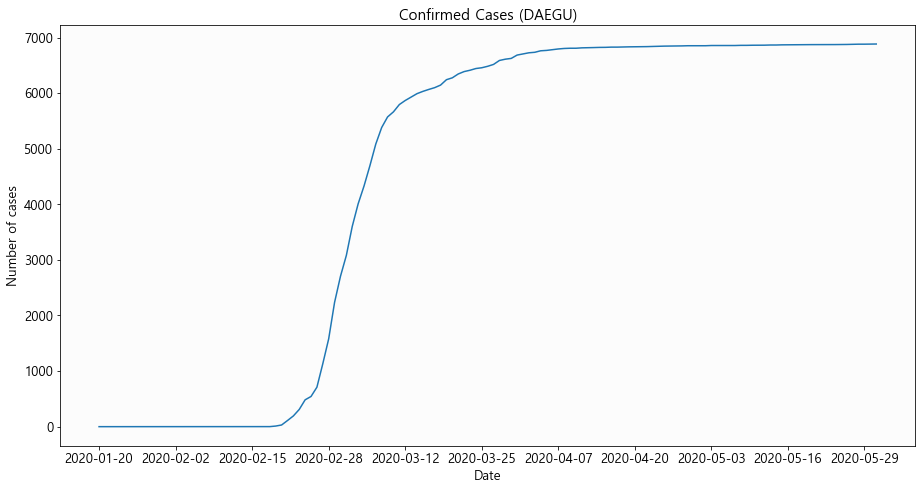

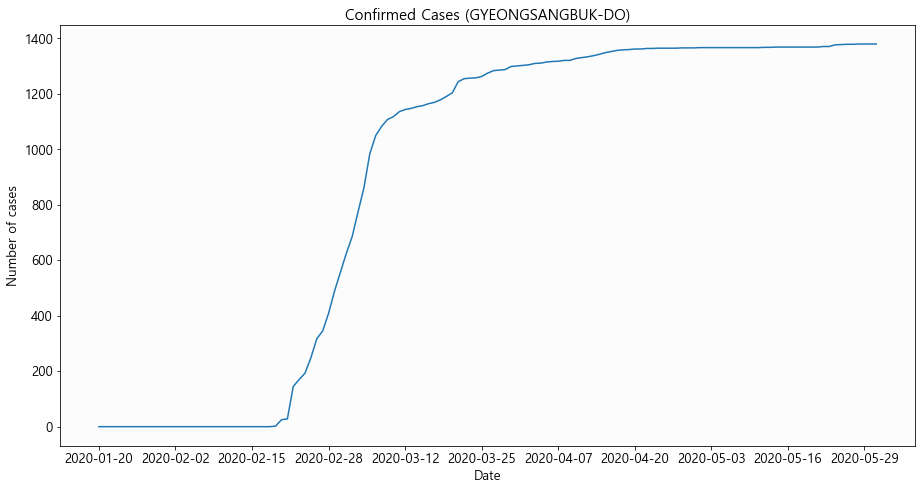

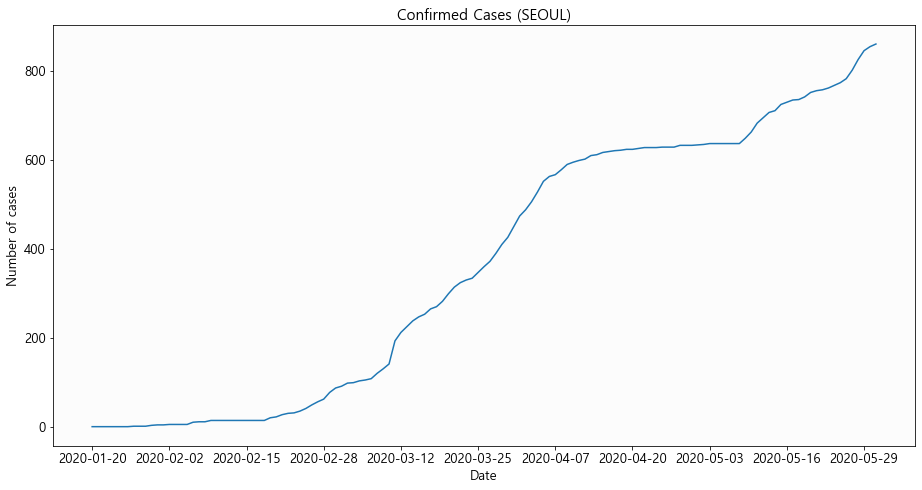

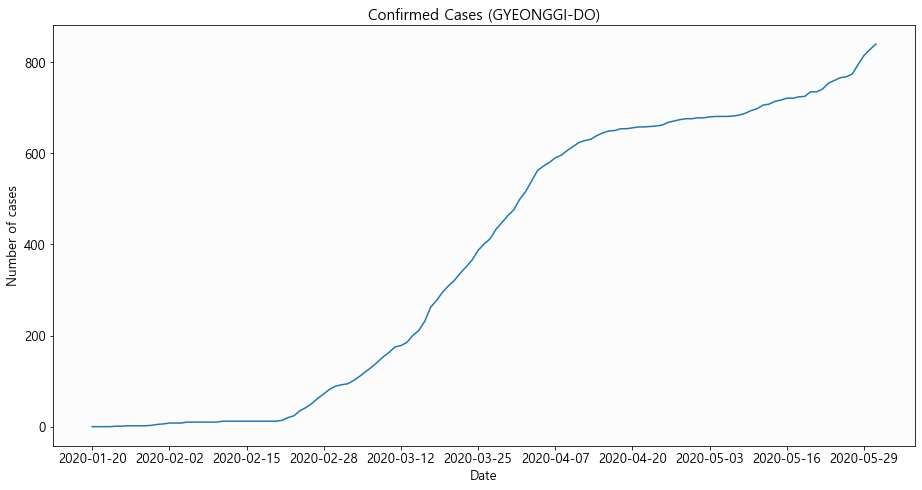

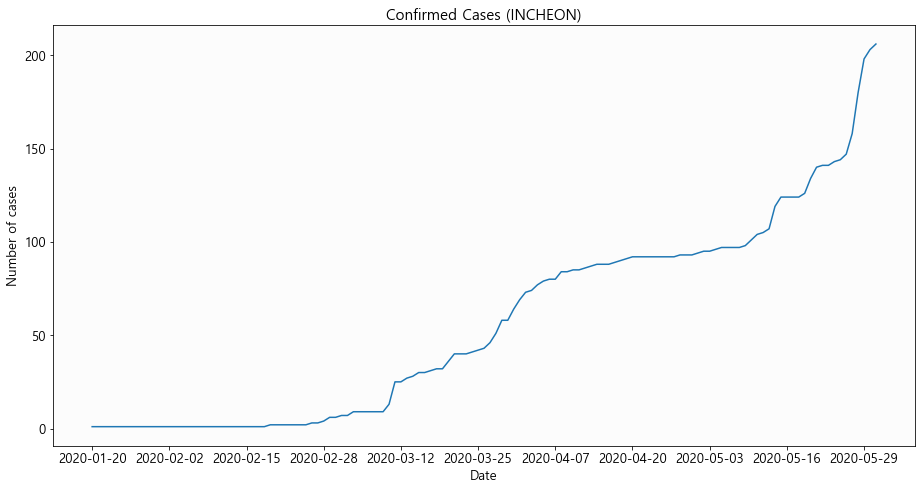

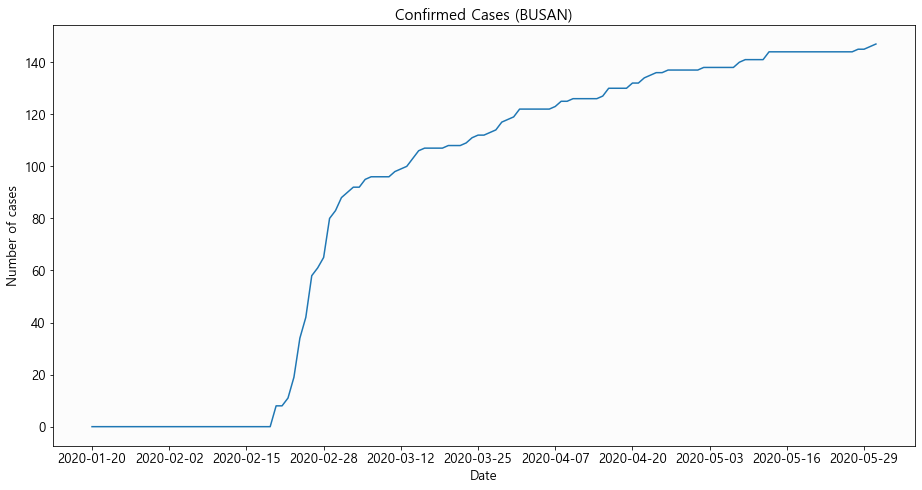

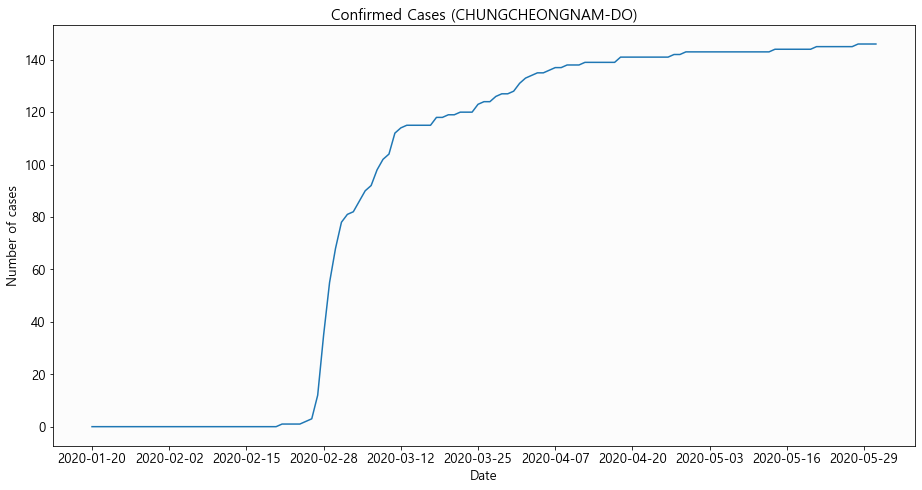

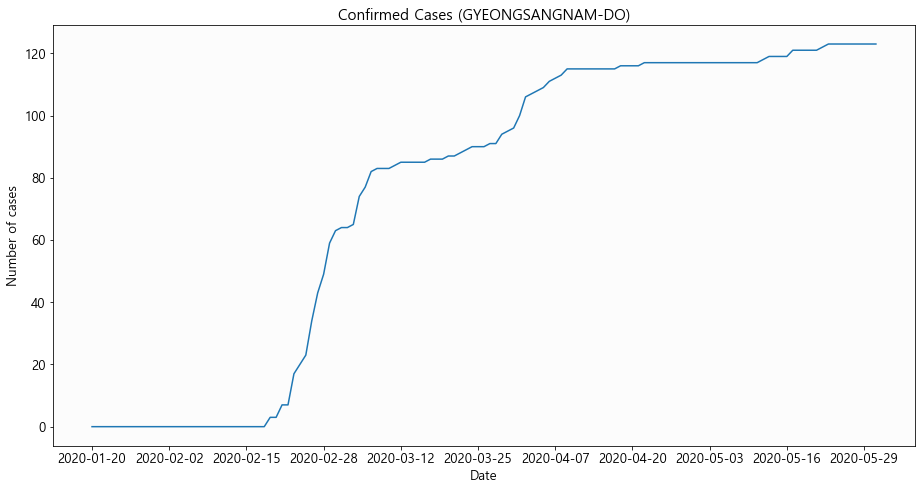

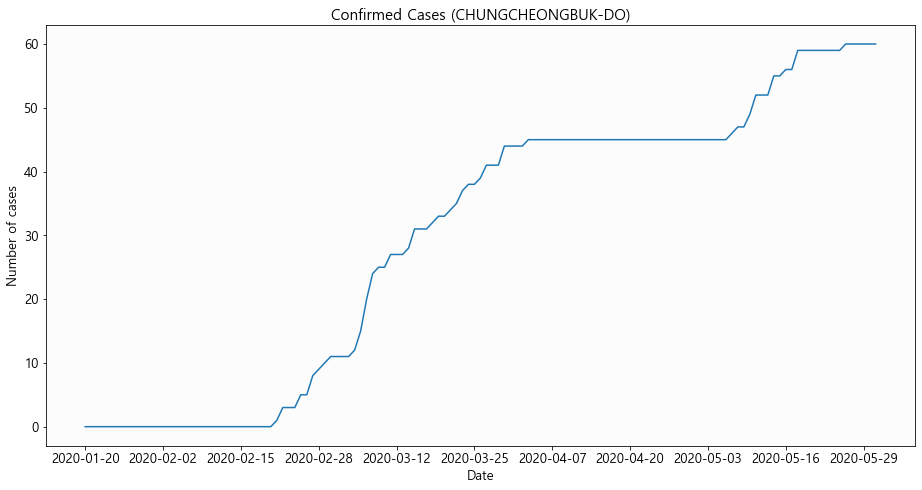

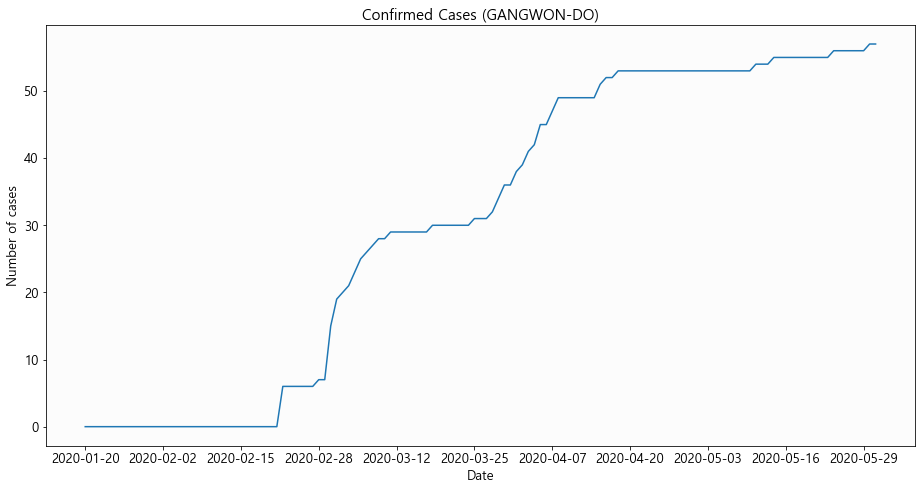

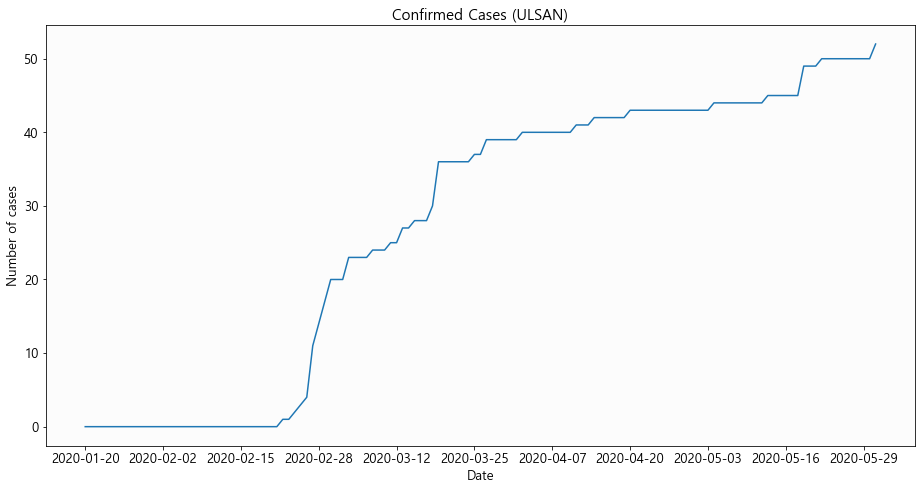

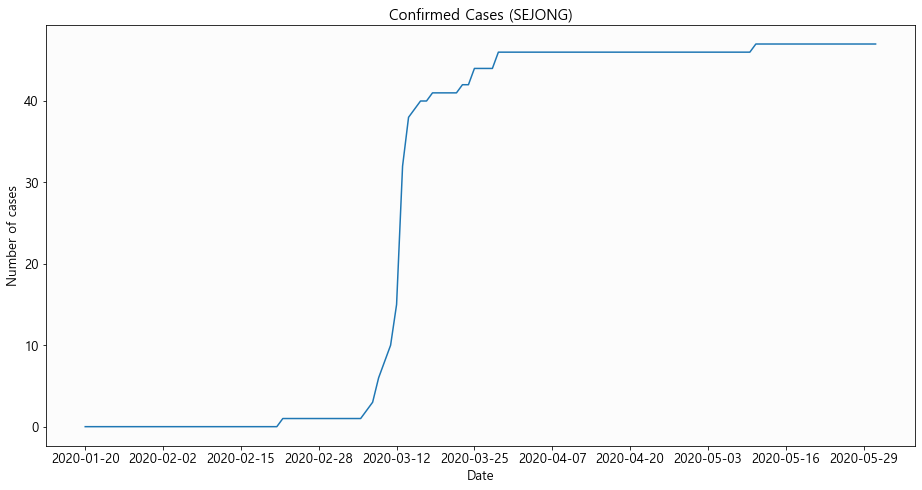

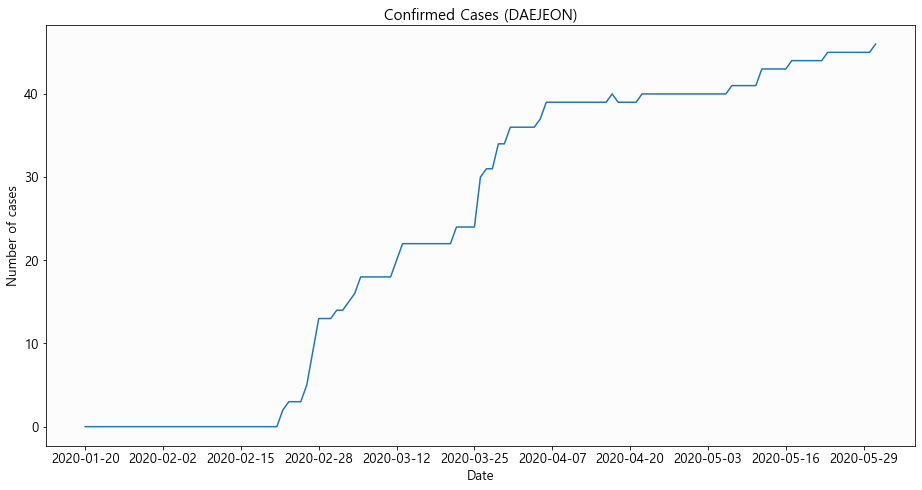

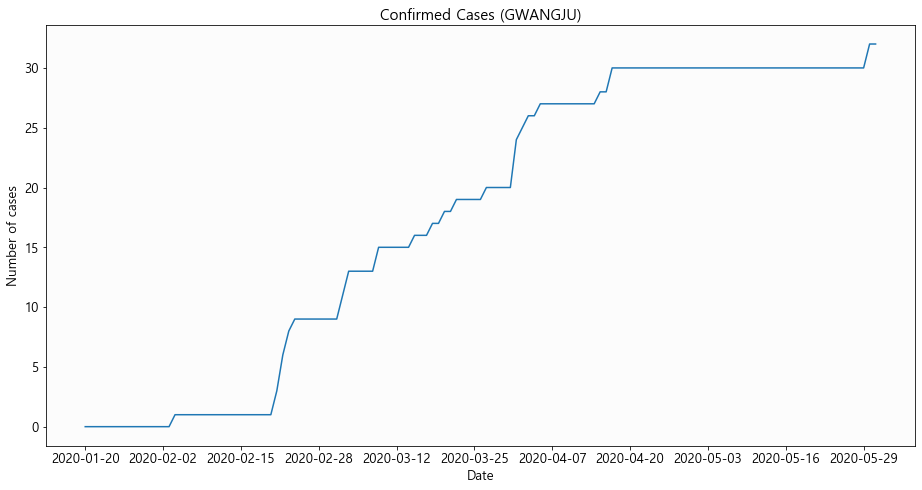

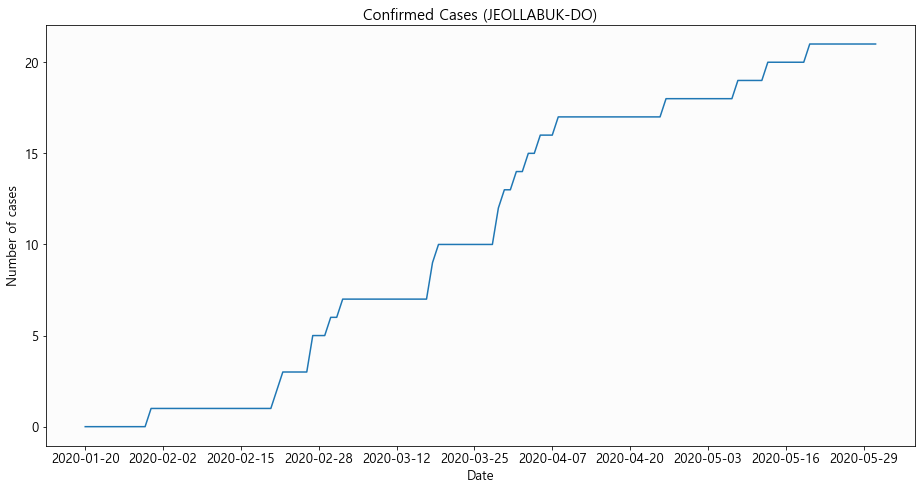

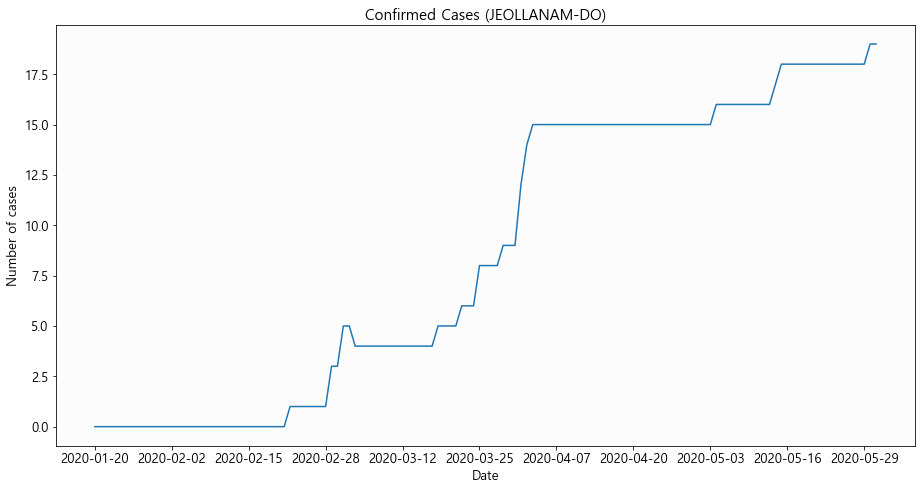

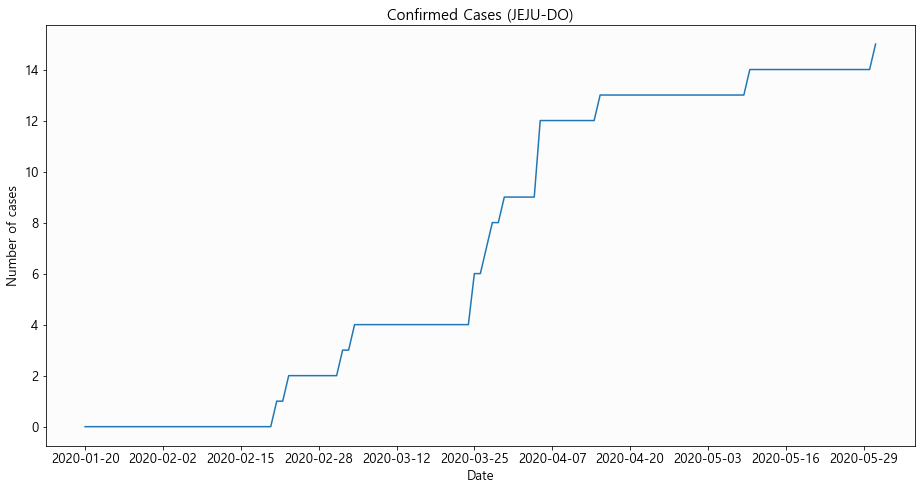

In [25]:
if not fast:
    print('[Confirmed Cases in each location (most to least)]')

    # location list by order of confirmed cases (based on latest data)
    loc_list = location_raw[location_raw.date==location_raw.date.iloc[-1]]\
               .sort_values('confirmed', ascending = False)\
               .province

    # Get a graph for each location
    for loc_name in loc_list:
        fig, ax = plt.subplots(figsize=(13, 7))
        plt.title(f'Confirmed Cases ({loc_name.upper()})', fontsize=15)
        ax.set_xlabel('Date', size=13)
        ax.set_ylabel('Number of cases', size=13)
        loc_raw = location_raw[location_raw.province==loc_name]
        plt.plot(loc_raw.date.unique(), loc_raw.confirmed)
        ax.set_xticks(ax.get_xticks()[::13])
        plt.show()

In [26]:
loc_meta_raw = pd.read_csv(file_paths[2])
print('[Sample data]')
loc_meta_raw.tail(3).T

[Sample data]


241      242      243
code                                 61180    70000    80000
province                  Gyeongsangnam-do  Jeju-do    Korea
city                          Hapcheon-gun  Jeju-do    Korea
latitude                           35.5667  33.4889   37.567
longitude                          128.166    126.5  126.978
elementary_school_count                 17      113     6087
kindergarten_count                      15      123     8837
university_count                         0        4      340
academy_ratio                         0.71     1.53     1.56
elderly_population_ratio             38.44     15.1    15.67
elderly_alone_ratio                   24.7      6.4      7.2
nursing_home_count                      96     1245    94865

In [27]:
print('Number of unique locations:', len(loc_meta_raw.province.unique()))
print(loc_meta_raw.province.unique())

Number of unique locations: 18
['Seoul' 'Busan' 'Daegu' 'Gwangju' 'Incheon' 'Daejeon' 'Ulsan' 'Sejong'
 'Gyeonggi-do' 'Gangwon-do' 'Chungcheongbuk-do' 'Chungcheongnam-do'
 'Jeollabuk-do' 'Jeollanam-do' 'Gyeongsangbuk-do' 'Gyeongsangnam-do'
 'Jeju-do' 'Korea']


In [28]:
loc_meta_raw[loc_meta_raw.province=='Korea'].T

243
code                        80000
province                    Korea
city                        Korea
latitude                   37.567
longitude                 126.978
elementary_school_count      6087
kindergarten_count           8837
university_count              340
academy_ratio                1.56
elderly_population_ratio    15.67
elderly_alone_ratio           7.2
nursing_home_count          94865

In [29]:
old_pop_df = pd.DataFrame(loc_meta_raw[loc_meta_raw.province!='Korea']
                          .groupby('province').mean()
                          .elderly_population_ratio
                          .sort_values(ascending=False)
                         )
old_pop_df

elderly_population_ratio
province                                   
Jeollanam-do                      28.142174
Gyeongsangbuk-do                  27.556250
Jeollabuk-do                      27.470667
Gyeongsangnam-do                  24.749474
Chungcheongnam-do                 23.844375
Chungcheongbuk-do                 23.192500
Gangwon-do                        22.890526
Busan                             19.357647
Daegu                             17.031111
Incheon                           16.399091
Seoul                             15.738077
Jeju-do                           15.100000
Gwangju                           14.815000
Gyeonggi-do                       14.429688
Daejeon                           14.376667
Ulsan                             11.773333
Sejong                             9.480000

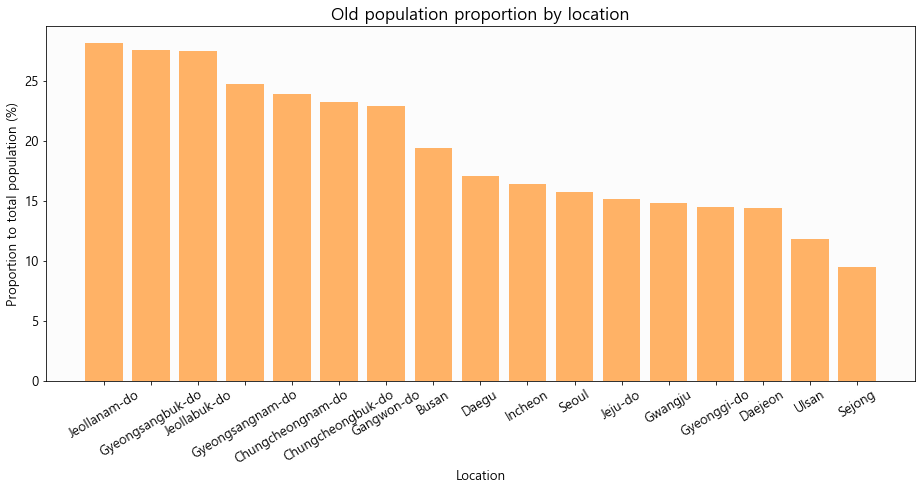

In [30]:
fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Old population proportion by location', fontsize=17)
plt.xticks(rotation=31)
# plt.bar(old_pop_df.location, old_pop_df.old_population_proportion, color=color_list[1])
plt.bar(old_pop_df.index, old_pop_df.elderly_population_ratio, color=color_list[1])
plt.xlabel('Location')
plt.ylabel('Proportion to total population (%)')
plt.show()

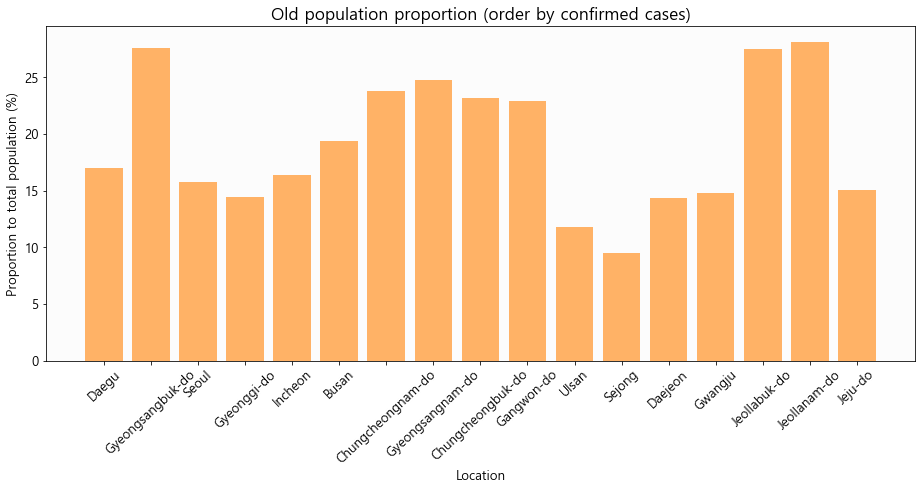

In [31]:
old_pop_ordered = old_pop_df.loc[loc_latest_all.province.values, :].elderly_population_ratio
fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Old population proportion (order by confirmed cases)', fontsize=17)
plt.xticks(rotation=43)
plt.xlabel('Location')
plt.ylabel('Proportion to total population (%)')
plt.bar(old_pop_ordered.index, old_pop_ordered, color=color_list[1])
plt.show()

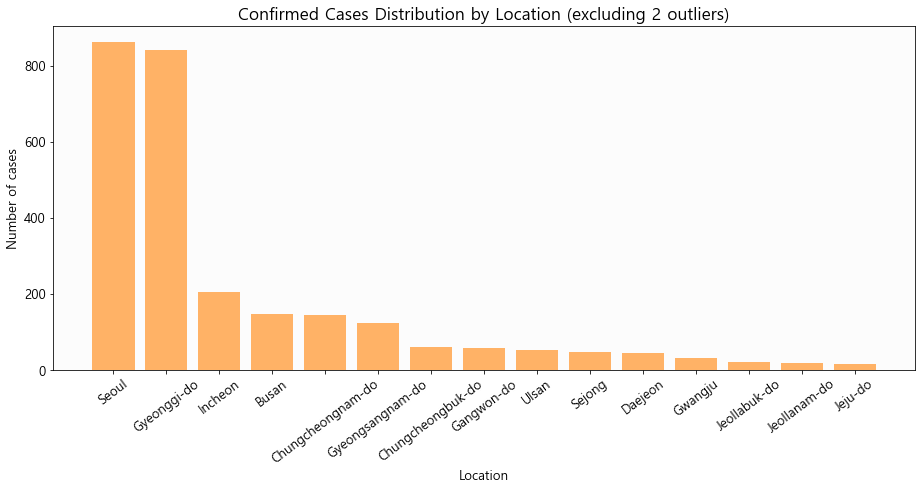

In [32]:
fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Confirmed Cases Distribution by Location (excluding 2 outliers)', fontsize=17)
plt.xticks(rotation=37)
plt.bar(loc_latest_all[2:].province
        # get the proportion to total (excluding 2 special cases)
#         , loc_latest_all[2:].confirmed/loc_latest_all[2:].confirmed.sum()*100
        , loc_latest_all[2:].confirmed
        , color=color_list[1])
# plt.bar(old_pop_ordered.index, old_pop_ordered, color=color_list[1])
plt.xlabel('Location')
plt.ylabel('Number of cases')
plt.show()

In [33]:
pop_dense = pd.DataFrame()
pop_dense['location'] = loc_latest_all.province
pop_dense['population'] = np.divide(
    [2450, 2674, 13031, 9705, 2180, 3400
     , 3356, 304, 2939, 1154, 1619, 1521
     , 1518, 1493, 1820, 1790, 653]
    , 1000 # thousand to million
)

# density = number of people / km²
pop_dense['density'] = [2773, 141, 1279, 16034, 265, 4416
                        , 318, 653, 2764, 1088, 219, 90
                        , 2813, 2980, 226, 145, 353]
pop_dense

location  population  density
1               Daegu       2.450     2773
2    Gyeongsangbuk-do       2.674      141
3               Seoul      13.031     1279
4         Gyeonggi-do       9.705    16034
5             Incheon       2.180      265
6               Busan       3.400     4416
7   Chungcheongnam-do       3.356      318
8    Gyeongsangnam-do       0.304      653
9   Chungcheongbuk-do       2.939     2764
10         Gangwon-do       1.154     1088
11              Ulsan       1.619      219
12             Sejong       1.521       90
13            Daejeon       1.518     2813
14            Gwangju       1.493     2980
15       Jeollabuk-do       1.820      226
16       Jeollanam-do       1.790      145
17            Jeju-do       0.653      353

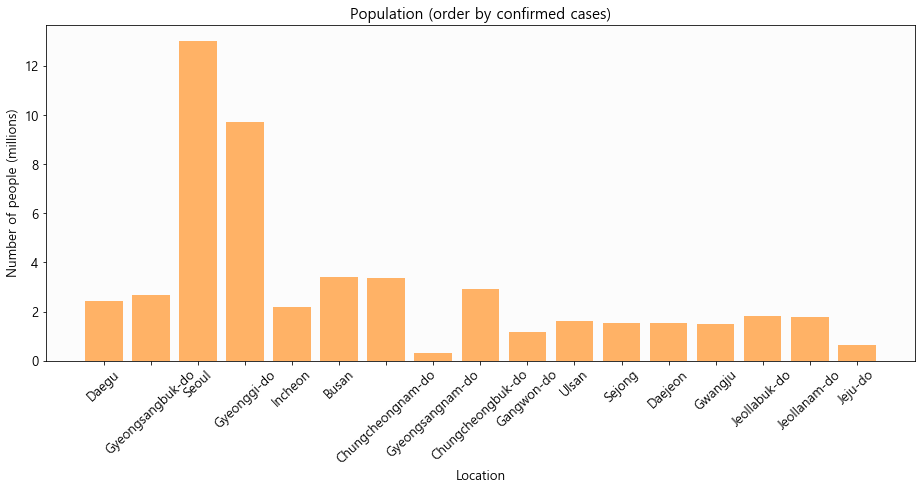

In [34]:
fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Population (order by confirmed cases)', fontsize=15)
plt.bar(pop_dense.location, pop_dense.population, color=color_list[1])
plt.xticks(rotation=43)
plt.xlabel('Location')
plt.ylabel('Number of people (millions)', size=13)
plt.show()

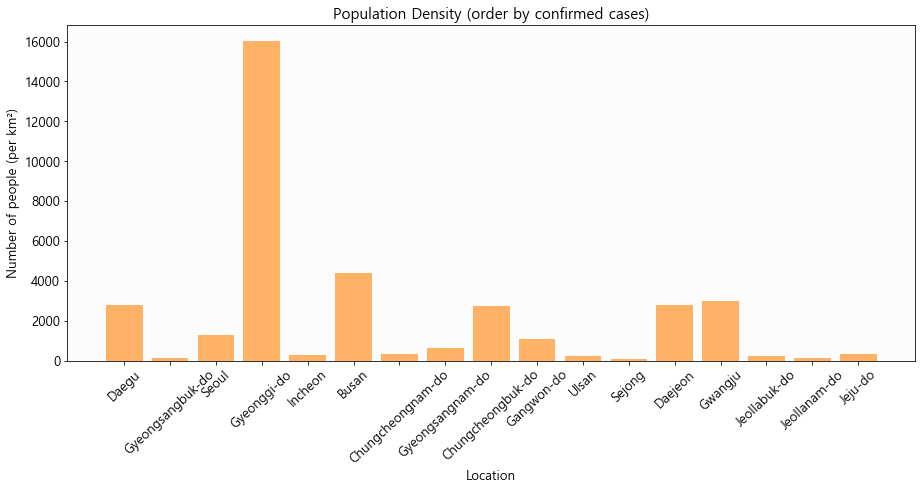

In [35]:
fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Population Density (order by confirmed cases)', fontsize=15)
plt.bar(pop_dense.location, pop_dense.density, color=color_list[1])
plt.ylabel('Number of people (per km²)', size=13)
plt.xlabel('Location')
plt.xticks(rotation=43)
plt.show()

In [36]:
gender_raw = pd.read_csv(file_paths[3])
display(gender_raw.head(3).append(gender_raw.tail(3)))
data_col = pd.to_datetime(gender_raw['date']).dt.date
date_range = (max(data_col) - min(data_col)).days + 1
print(f'Date range: {date_range} days')
print(f'# {min(data_col)} to {max(data_col)}')

date  time     sex  confirmed  deceased
0    2020-03-02     0    male       1591        13
1    2020-03-02     0  female       2621         9
2    2020-03-03     0    male       1810        16
179  2020-05-30     0  female       6661       127
180  2020-05-31     0    male       4795       143
181  2020-05-31     0  female       6673       127

Date range: 91 days
# 2020-03-02 to 2020-05-31


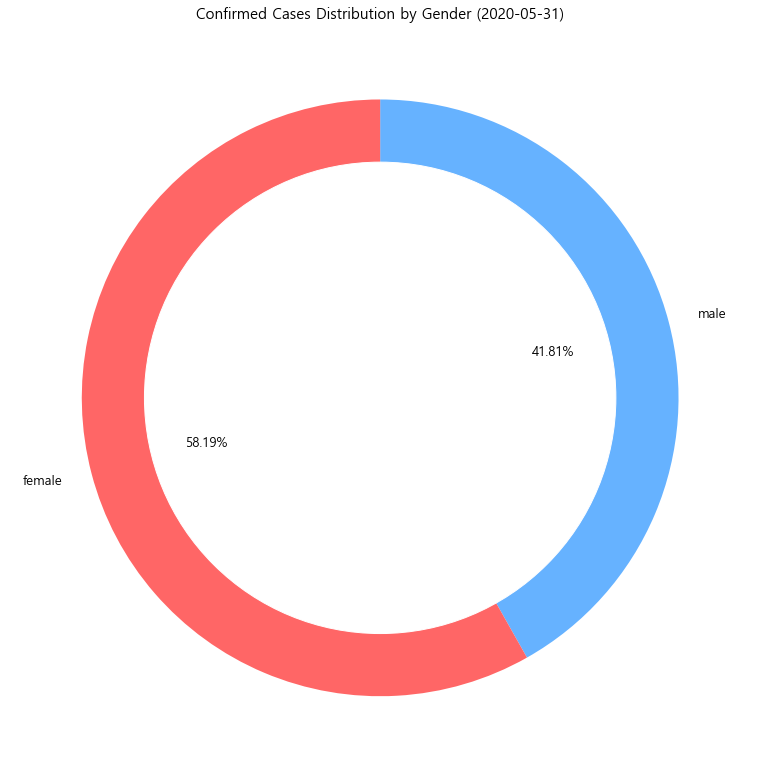

In [37]:
fig, ax = plt.subplots(figsize=(11, 11))
colors = [color_list[5] , color_list[0]]
plt.title(f'Confirmed Cases Distribution by Gender ({last_update})', fontsize=15)
pop_circle=plt.Circle((0,0), 0.79, color='white')
plt.pie(gender_raw.confirmed[-2:]
        , labels=['male', 'female']
        , autopct='%.2f%%'
        , colors = colors
        , startangle=90
        , counterclock=False)
p=plt.gcf()
p.gca().add_artist(pop_circle)
plt.show()

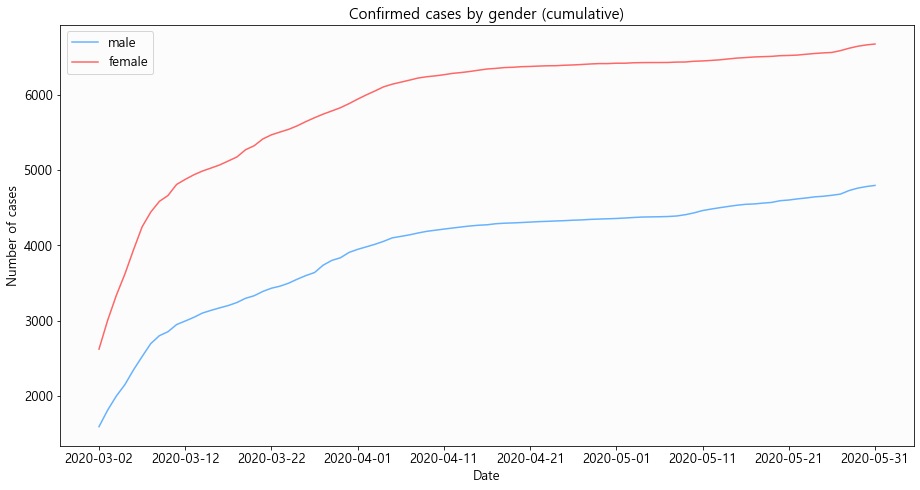

In [38]:
fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Confirmed cases by gender (cumulative)', fontsize=15)
genders_confirmed = (gender_raw[gender_raw.sex=='male'].confirmed, gender_raw[gender_raw.sex=='female'].confirmed)
for gender_each, gender_label in zip(genders_confirmed, ['male', 'female']):
    if gender_label == 'male':
        plt.plot(gender_raw.date.unique(), gender_each, label=gender_label, color=color_list[5])
    elif gender_label == 'female':
        plt.plot(gender_raw.date.unique(), gender_each, label=gender_label, color=color_list[0])
ax.set_xticks(ax.get_xticks()[::10])
plt.xlabel('Date')
plt.ylabel('Number of cases')
ax.legend()
plt.show()

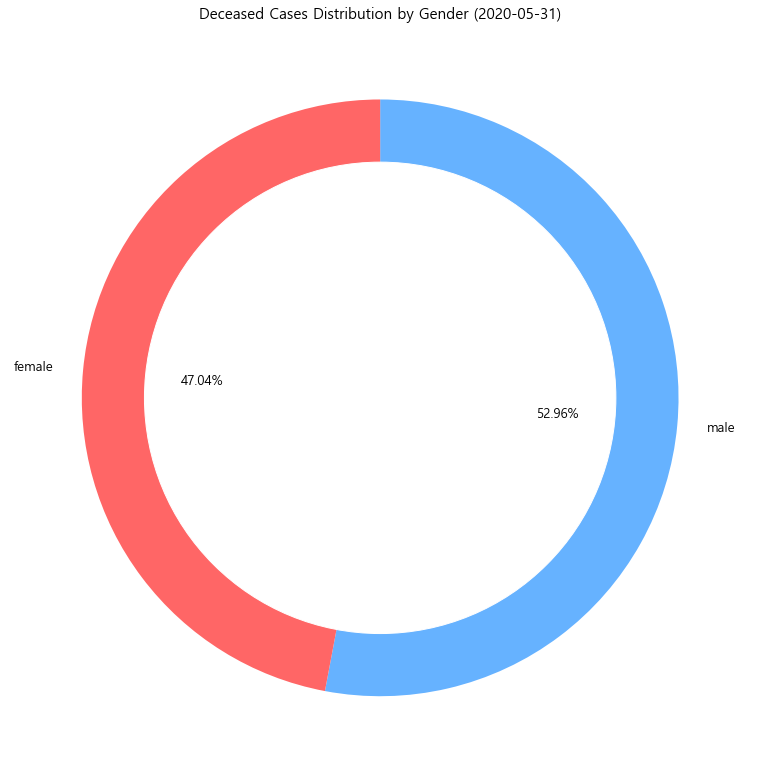

In [39]:
fig, ax = plt.subplots(figsize=(11, 11))
colors = [color_list[5] , color_list[0]]
plt.title(f'Deceased Cases Distribution by Gender ({last_update})', fontsize=15)
pop_circle=plt.Circle((0,0), 0.79, color='white')
plt.pie(gender_raw.deceased[-2:]
        , labels=['male', 'female']
        , colors = colors
        , autopct='%.2f%%'
        , startangle=90
        , counterclock=False) # 55 VS. 49
p=plt.gcf()
p.gca().add_artist(pop_circle)
plt.show()

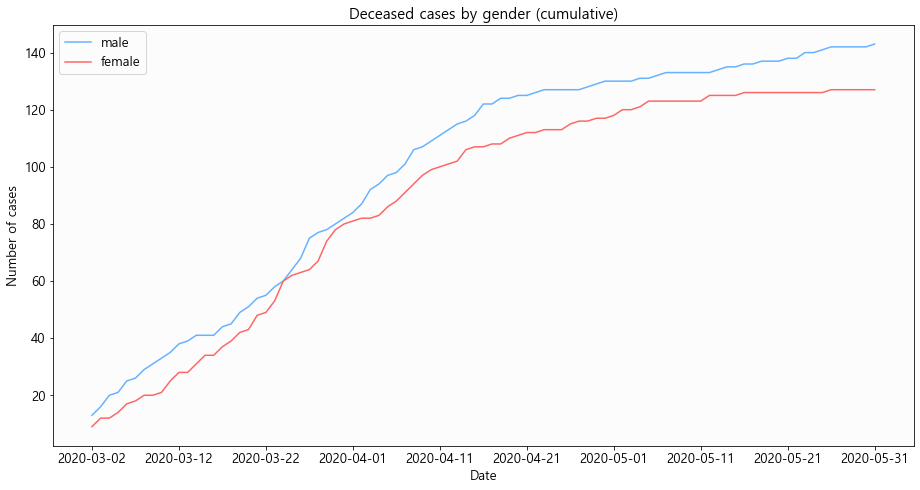

In [40]:
fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Deceased cases by gender (cumulative)', fontsize=15)
genders_deceased = (gender_raw[gender_raw.sex=='male'].deceased, gender_raw[gender_raw.sex=='female'].deceased)

for gender_each, gender_label in zip(genders_deceased, ['male', 'female']):
    #plt.plot(gender_raw.date.unique(), gender_each, label=gender_label)
    if gender_label == 'male':
        plt.plot(gender_raw.date.unique(), gender_each, label=gender_label, color=color_list[5])
    elif gender_label == 'female':
        plt.plot(gender_raw.date.unique(), gender_each, label=gender_label, color=color_list[0])
ax.set_xticks(ax.get_xticks()[::10])
plt.xlabel('Date')
plt.ylabel('Number of cases')
ax.legend()
plt.show()

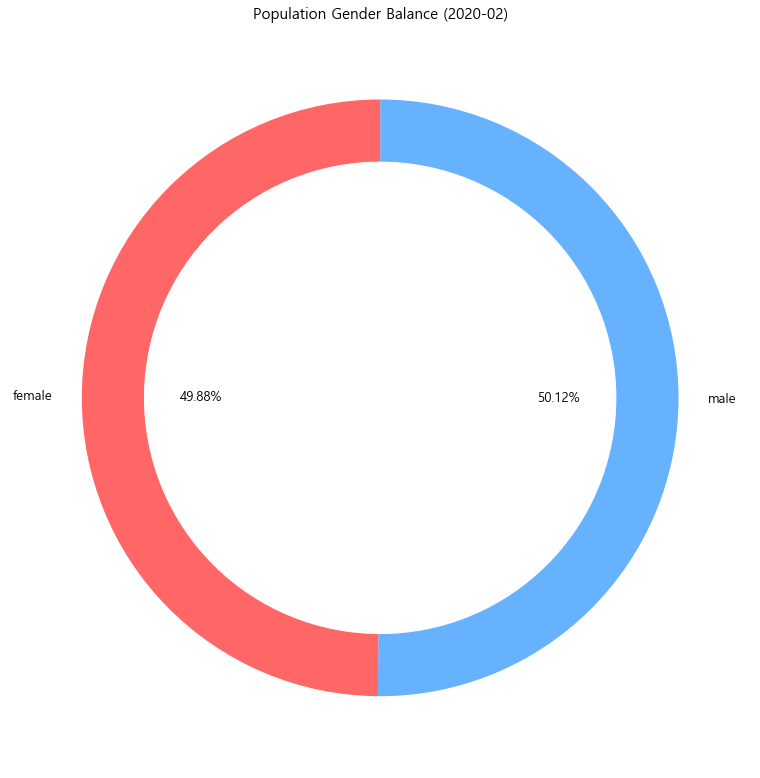

In [41]:
fig, ax = plt.subplots(figsize=(11, 11))
plt.title('Population Gender Balance (2020-02)', fontsize=15)
colors = [color_list[5] , color_list[0]]
pop_circle=plt.Circle((0,0), 0.79, color='white')
plt.pie([25984136, 25860491]
        , labels=['male', 'female']
        , colors = colors
        , autopct='%.2f%%'
        , startangle=90
        , counterclock=False)
p=plt.gcf()
p.gca().add_artist(pop_circle)
plt.show()

In [42]:
pop_meta = pop_dense.copy()
pop_meta['gender_bal'] = [97.7, 101.4, 101.2, 95.1, 104.0, 96.3, 101.3, 99.4, 100.5
                          , 105.7, 102.7, 101.2, 99.8, 98.0, 98.9, 100.9, 101.1]
pop_meta

location  population  density  gender_bal
1               Daegu       2.450     2773        97.7
2    Gyeongsangbuk-do       2.674      141       101.4
3               Seoul      13.031     1279       101.2
4         Gyeonggi-do       9.705    16034        95.1
5             Incheon       2.180      265       104.0
6               Busan       3.400     4416        96.3
7   Chungcheongnam-do       3.356      318       101.3
8    Gyeongsangnam-do       0.304      653        99.4
9   Chungcheongbuk-do       2.939     2764       100.5
10         Gangwon-do       1.154     1088       105.7
11              Ulsan       1.619      219       102.7
12             Sejong       1.521       90       101.2
13            Daejeon       1.518     2813        99.8
14            Gwangju       1.493     2980        98.0
15       Jeollabuk-do       1.820      226        98.9
16       Jeollanam-do       1.790      145       100.9
17            Jeju-do       0.653      353       101.1

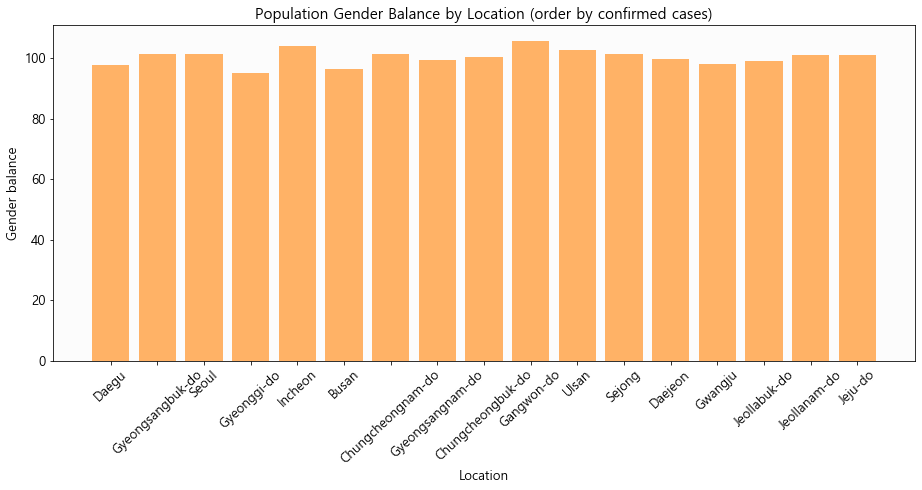

In [43]:
fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Population Gender Balance by Location (order by confirmed cases)', fontsize=15)
plt.xticks(rotation=43)
plt.bar(pop_meta.location, pop_meta.gender_bal, color=color_list[1])
plt.xlabel('Location')
plt.ylabel('Gender balance')
plt.show()

In [44]:
test_raw = pd.read_csv(file_paths[4])
display(test_raw.head(3).append(test_raw.tail(3)))
data_col = pd.to_datetime(test_raw['date']).dt.date
date_range = (max(data_col) - min(data_col)).days + 1
print(f'Date range: {date_range} days')
print(f'# {min(data_col)} to {max(data_col)}')

date  time    test  negative  confirmed  released  deceased
0    2020-01-20    16       1         0          1         0         0
1    2020-01-21    16       1         0          1         0         0
2    2020-01-22    16       4         3          1         0         0
130  2020-05-29     0  885120    849161      11402     10363       269
131  2020-05-30     0  902901    865162      11441     10398       269
132  2020-05-31     0  910822    876060      11468     10405       270

Date range: 133 days
# 2020-01-20 to 2020-05-31


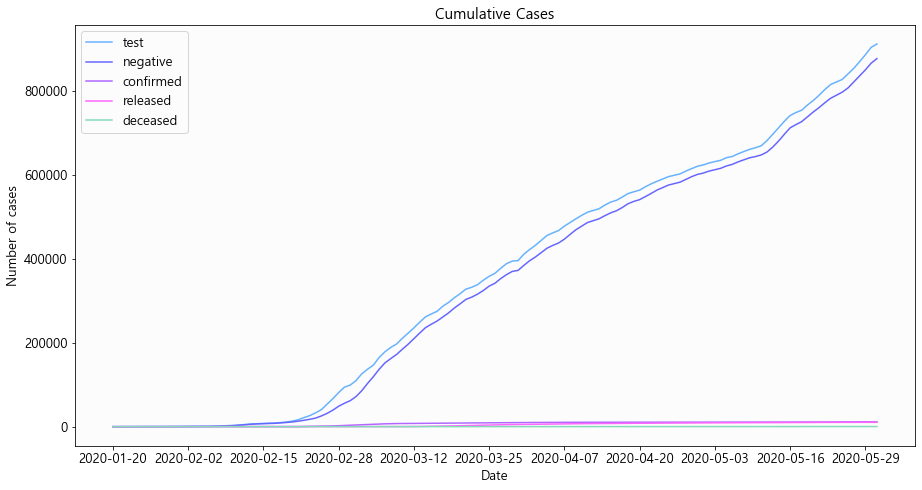

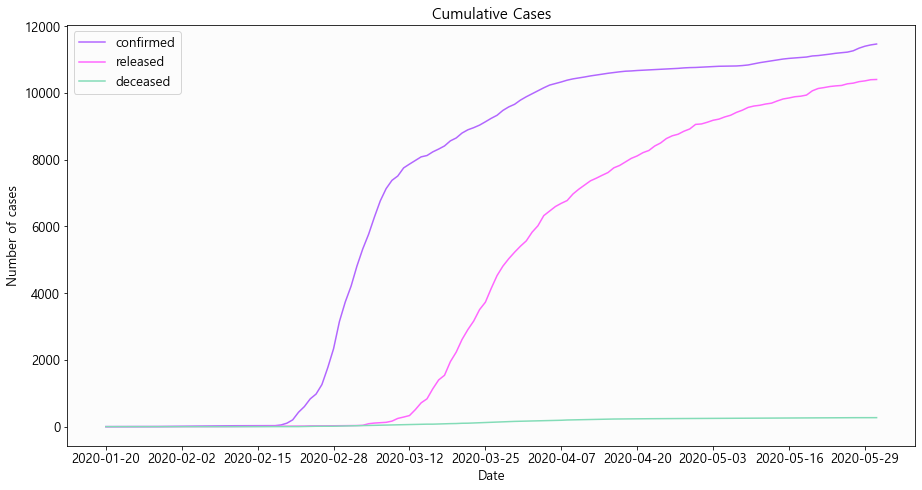

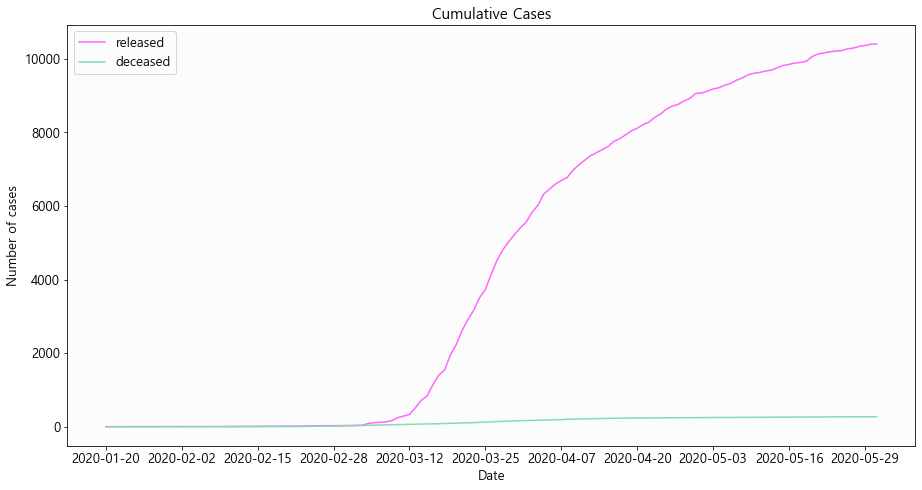

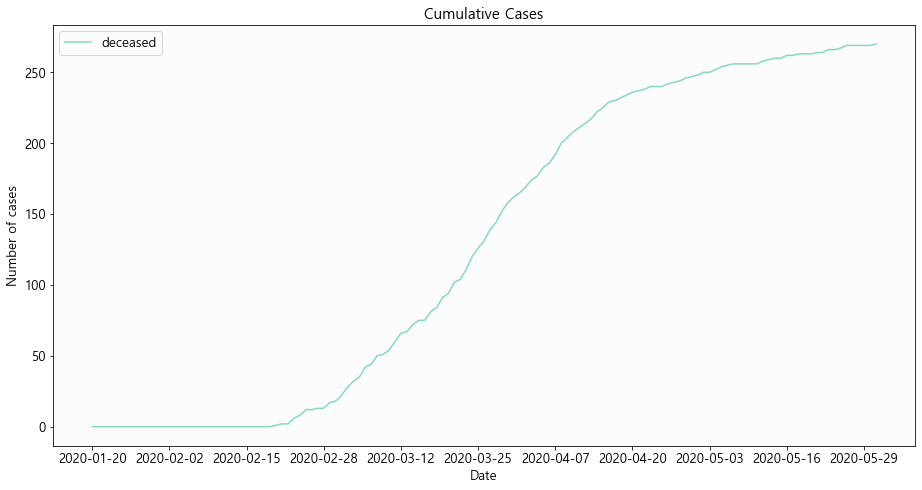

In [45]:
def plot_test(data, column_list, column_max, case_type):
    for i in column_list:
        fig, ax = plt.subplots(figsize=(13, 7))
        plt.title(f'{case_type} Cases', fontsize=15)
        color_group = color_list[:-4][-(column_max-i):]
        for test_each, color_each in zip(data.columns[i:column_max], color_group):
            plt.plot(data.date, data[test_each], label=test_each
                     , color=color_each
                    )
            label=data[test_each]
        ax.set_xticks(ax.get_xticks()[::13])
        plt.xlabel('Date')
        plt.ylabel('Number of cases')
        ax.legend()
        plt.show()

plot_test(test_raw, [2, 4, 5, 6], 7, 'Cumulative')

In [46]:
total_pop = sum(pop_meta.population)
test_raw['test_rate'] = test_raw.test/sum(pop_meta.population) * 100
test_raw['confirmed_rate'] = test_raw.confirmed/test_raw.test * 100 # to total tests
test_raw['deceased_rate'] = test_raw.deceased/(test_raw.released+test_raw.deceased) * 100 # to released or deceased cases
print('[Latest test numbers]')
test_raw.tail(1)

[Latest test numbers]


date  time    test  negative  confirmed  released  deceased  \
132  2020-05-31     0  910822    876060      11468     10405       270   

        test_rate  confirmed_rate  deceased_rate  
132  1.764919e+06        1.259082       2.529274

In [47]:
print('# Columns for daily new cases added')
for col in test_raw.columns[2:7]:
    if col in [2, 4]:
        new_dict = {0: 1}
    else:
        new_dict = {0: 0}
    new_dict.update({ i : test_raw[col][i] - test_raw[col][i-1] for i in range(1, len(test_raw)) })
    test_raw[f'new_{col}'] = new_dict.values()
test_raw.head(3).append(test_raw.tail(3)).T

# Columns for daily new cases added


0           1           2            130          131  \
date            2020-01-20  2020-01-21  2020-01-22   2020-05-29   2020-05-30   
time                    16          16          16            0            0   
test                     1           1           4       885120       902901   
negative                 0           0           3       849161       865162   
confirmed                1           1           1        11402        11441   
released                 0           0           0        10363        10398   
deceased                 0           0           0          269          269   
test_rate          1.93772     1.93772     7.75089  1.71512e+06  1.74957e+06   
confirmed_rate         100         100          25      1.28819      1.26714   
deceased_rate          NaN         NaN         NaN       2.5301       2.5218   
new_test                 0           0           3        16454        17781   
new_negative             0           0           3        14209        16001   
new_confirmed            0           0           0           58           39   
new_released             0           0           0           23           35   
new_deceased             0           0           0            0            0   

                        132  
date             2020-05-31  
time                      0  
test                 910822  
negative             876060  
confirmed             11468  
released              10405  
deceased                270  
test_rate       1.76492e+06  
confirmed_rate      1.25908  
deceased_rate       2.52927  
new_test               7921  
new_negative          10898  
new_confirmed            27  
new_released              7  
new_deceased              1

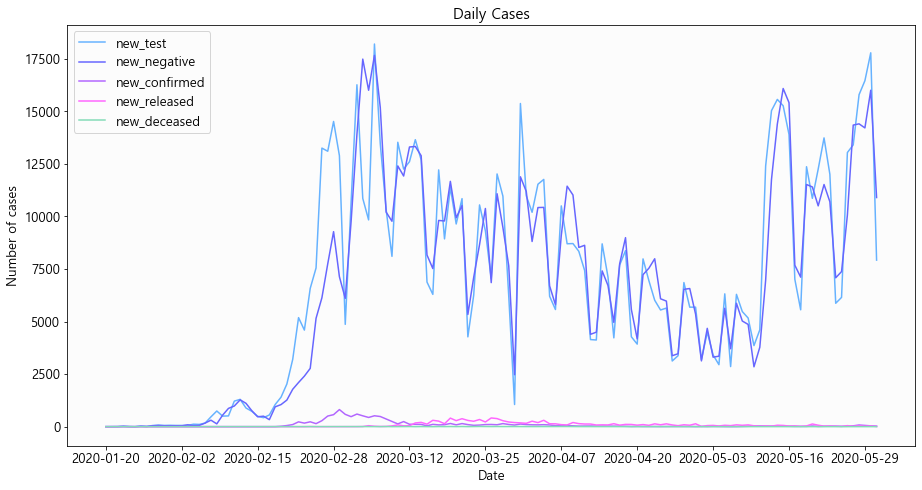

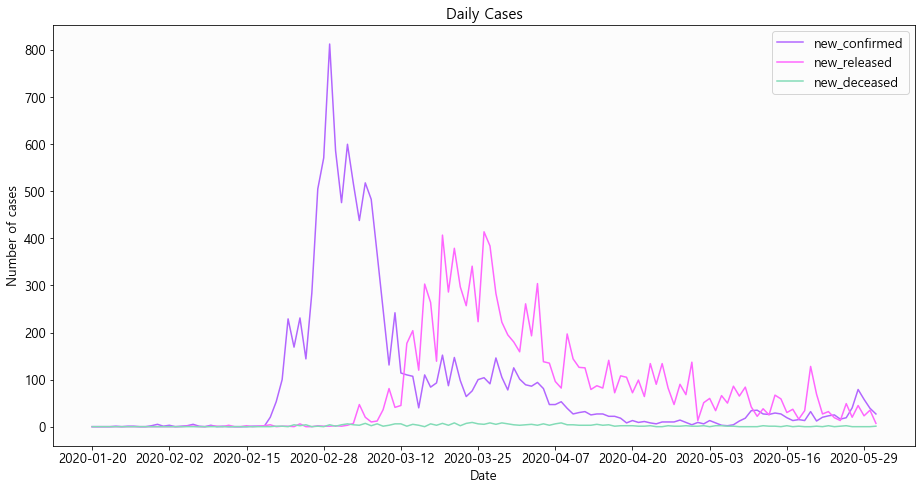

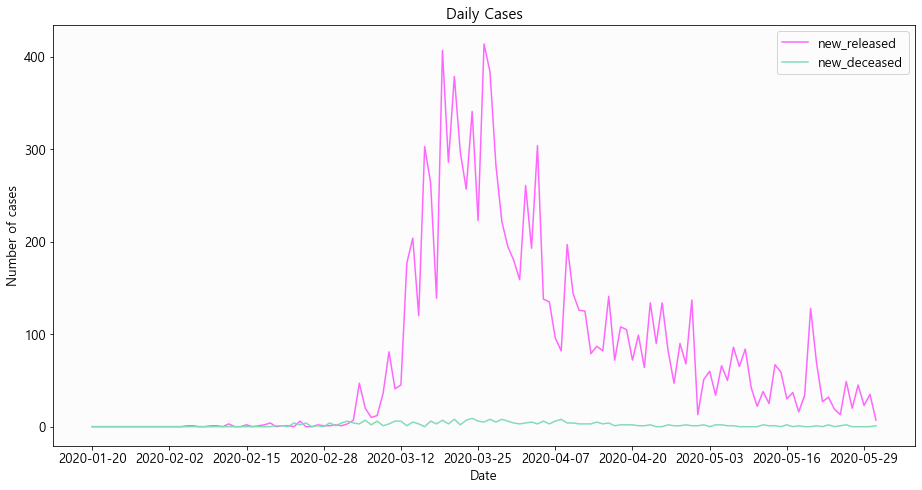

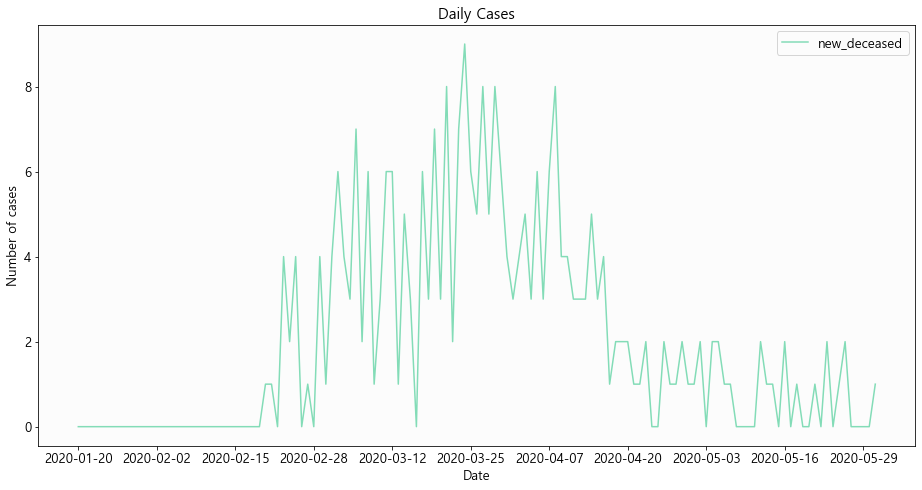

In [48]:
plot_test(test_raw, [10, 12, 13, 14], len(test_raw.columns), 'Daily')

In [49]:
cause_raw = pd.read_csv(file_paths[5])
print(f'Number of unique causes: {len(cause_raw.infection_case.unique())}\n')
print('[6 causes with the most confirmed cases]')
cause = cause_raw.sort_values('confirmed', ascending=False)
display(cause.head(6))

Number of unique causes: 51

[6 causes with the most confirmed cases]


case_id          province             city  group        infection_case  \
29   1200001             Daegu           Nam-gu   True    Shincheonji Church   
37   1200009             Daegu                -  False  contact with patient   
38   1200010             Daegu                -  False                   etc   
102  6000001  Gyeongsangbuk-do  from other city   True    Shincheonji Church   
16   1000017             Seoul                -  False       overseas inflow   
75   2000010       Gyeonggi-do                -  False       overseas inflow   

     confirmed  latitude longitude  
29      4510.0  35.84008  128.5667  
37       920.0         -         -  
38       737.0         -         -  
102      566.0         -         -  
16       346.0         -         -  
75       252.0         -         -

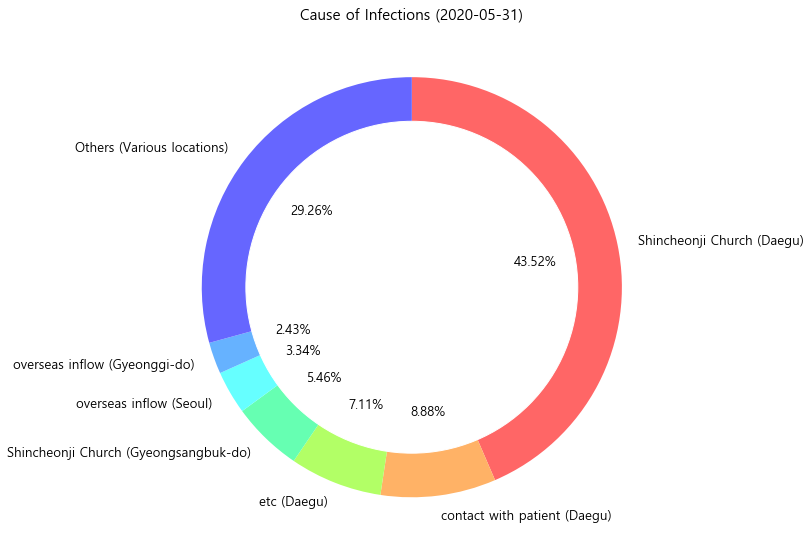

In [50]:
# Put causes other than those with the 6 most confirmed cases into others
cause.loc[len(cause), :] = cause[cause.confirmed<cause.confirmed.iloc[5]].sum()
cause.loc[len(cause)-1, 'case_id'] = 0
cause.loc[len(cause)-1, 'province'] = 'Various locations'
cause.loc[len(cause)-1, 'city'] = 'Various cities'
cause.loc[len(cause)-1, 'group'] = 'Various groups'
cause.loc[len(cause)-1, 'infection_case'] = 'Others'
cause.loc[len(cause)-1, 'latitude'] = '-'
cause.loc[len(cause)-1, 'longitude'] = '-'
cause_with_others = cause[cause.confirmed >= cause.confirmed.iloc[5]]

# Plot distribution
fig, ax = plt.subplots(figsize=(11, 11))
plt.title(f'Cause of Infections ({last_update})', fontsize=15)
colors = color_list
pop_circle=plt.Circle((0,0), 0.79, color='white')
plt.pie(cause_with_others.confirmed, autopct='%.2f%%'
        , labels=cause_with_others.infection_case + ' (' + cause_with_others.province + ')'
        , colors = colors
        , startangle=90
        , counterclock=False)
p=plt.gcf()
p.gca().add_artist(pop_circle)
plt.show()

In [51]:
cause_group = cause_raw.groupby('group').sum().sort_values('confirmed', ascending=False)
cause_group.index = ['group', 'individual']
print('[Type of infections]')
cause_group

[Type of infections]


case_id  confirmed
group       212300354     7174.0
individual  154300329     3190.0

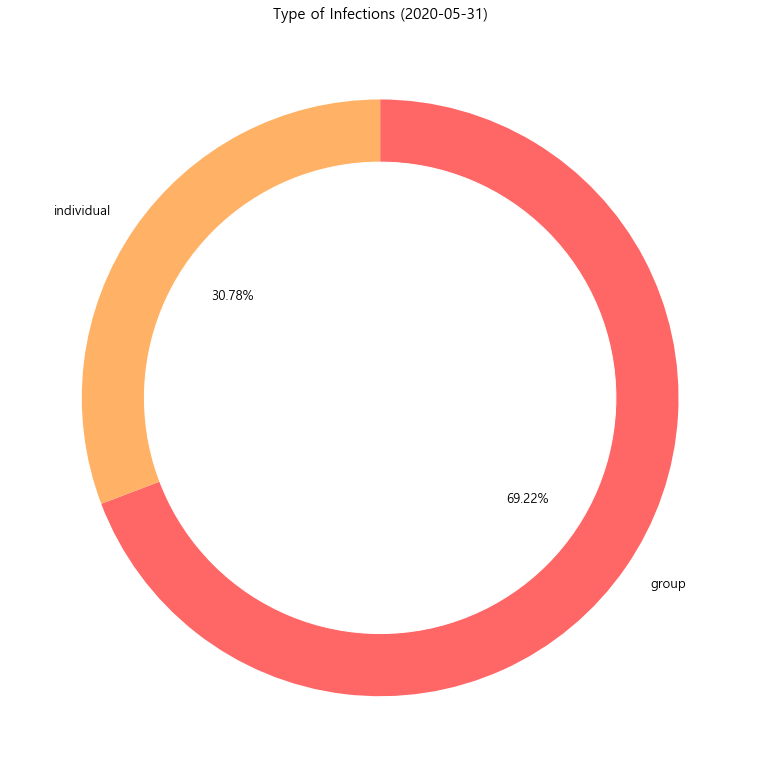

In [52]:
fig, ax = plt.subplots(figsize=(11, 11))
plt.title(f'Type of Infections ({last_update})', fontsize=15)
colors = color_list
pop_circle=plt.Circle((0,0), 0.79, color='white')
plt.pie(cause_group.confirmed
        , autopct='%.2f%%'
        , labels=cause_group.index
        , colors=colors
        , startangle=90
        , counterclock=False)
p=plt.gcf()
p.gca().add_artist(pop_circle)
plt.show()

In [53]:
weather_raw = pd.read_csv(file_paths[6])
display(weather_raw.head(3).append(weather_raw.tail(3)))
data_col = pd.to_datetime(weather_raw['date']).dt.date
date_range = (max(data_col) - min(data_col)).days + 1
print(f'Date range: {date_range} days')
print(f'# {min(data_col)} to {max(data_col)}')

code          province        date  avg_temp  min_temp  max_temp  \
0      10000             Seoul  2016-01-01       1.2      -3.3       4.0   
1      11000             Busan  2016-01-01       5.3       1.1      10.9   
2      12000             Daegu  2016-01-01       1.7      -4.0       8.0   
25804  60000  Gyeongsangbuk-do  2020-05-31      18.5      11.2      24.7   
25805  61000  Gyeongsangnam-do  2020-05-31      19.3      14.6      24.6   
25806  70000           Jeju-do  2020-05-31      19.7      17.1      23.6   

       precipitation  max_wind_speed  most_wind_direction  \
0                0.0             3.5                 90.0   
1                0.0             7.4                340.0   
2                0.0             3.7                270.0   
25804            0.0             5.0                180.0   
25805            0.0             4.0                140.0   
25806            0.0             6.2                 70.0   

       avg_relative_humidity  
0                       73.0  
1                       52.1  
2                       70.5  
25804                   77.4  
25805                   71.5  
25806                   88.1

Date range: 1613 days
# 2016-01-01 to 2020-05-31


In [54]:
## Stats by group
print('Number of locations in weather data:', len(weather_raw.province.unique()))
print(sorted(weather_raw.province.unique()))
print()
print('Number of locations in location data:', len(location_raw.province.unique()))
print(sorted(location_raw.province.unique()))

Number of locations in weather data: 16
['Busan', 'Chungcheongbuk-do', 'Chungcheongnam-do', 'Daegu', 'Daejeon', 'Gangwon-do', 'Gwangju', 'Gyeonggi-do', 'Gyeongsangbuk-do', 'Gyeongsangnam-do', 'Incheon', 'Jeju-do', 'Jeollabuk-do', 'Jeollanam-do', 'Seoul', 'Ulsan']

Number of locations in location data: 17
['Busan', 'Chungcheongbuk-do', 'Chungcheongnam-do', 'Daegu', 'Daejeon', 'Gangwon-do', 'Gwangju', 'Gyeonggi-do', 'Gyeongsangbuk-do', 'Gyeongsangnam-do', 'Incheon', 'Jeju-do', 'Jeollabuk-do', 'Jeollanam-do', 'Sejong', 'Seoul', 'Ulsan']


In [55]:
print('Number of wrong values before cleaning:', len(weather_raw.loc[ weather_raw.province=='Chunghceongbuk-do' ]))
print('# \'Chunghceongbuk-do\' is corrected to \'Chungcheongbuk-do\'')
weather_raw.loc[ weather_raw.province=='Chunghceongbuk-do', 'province' ] = 'Chungcheongbuk-do'
print('Number of unique locations after cleaning:', len(weather_raw.province.unique()))

Number of wrong values before cleaning: 0
# 'Chunghceongbuk-do' is corrected to 'Chungcheongbuk-do'
Number of unique locations after cleaning: 16


In [56]:
print('[Basic statistics - total]')
weather_raw.loc[:,'avg_temp':].describe().T

[Basic statistics - total]


count        mean         std   min   25%    50%  \
avg_temp               25792.0   13.693052    9.519496 -14.8   5.9   14.3   
min_temp               25802.0    9.495438    9.899467 -19.2   1.3    9.7   
max_temp               25804.0   18.611552    9.580450 -11.9  10.7   19.5   
precipitation          25807.0    1.412508    7.991702   0.0   0.0    0.0   
max_wind_speed         25798.0    5.116776    2.022527   1.0   3.8    4.7   
most_wind_direction    25778.0  196.026457  106.427142  20.0  90.0  230.0   
avg_relative_humidity  25787.0   65.553496   17.234220  10.4  53.4   66.6   

                         75%    max  
avg_temp                21.7   33.9  
min_temp                17.9   30.3  
max_temp                26.6   40.0  
precipitation            0.0  266.0  
max_wind_speed           6.0   29.4  
most_wind_direction    290.0  360.0  
avg_relative_humidity   78.6  100.0

In [57]:
print('[Average weather by location - sample]')
weather_stat = weather_raw.loc[:, 'province':].groupby('province').mean()
weather_stat.tail(3).T

[Average weather by location - sample]


province               Jeollanam-do       Seoul       Ulsan
avg_temp                  14.753379   12.840546   14.290329
min_temp                  11.799876    8.634594   10.075883
max_temp                  18.354123   17.845161   19.050899
precipitation              1.647799    1.393614    1.482145
max_wind_speed             7.980100    4.525574    4.697830
most_wind_direction      183.099814  209.422360  258.561686
avg_relative_humidity     65.073945   57.565840   66.006014

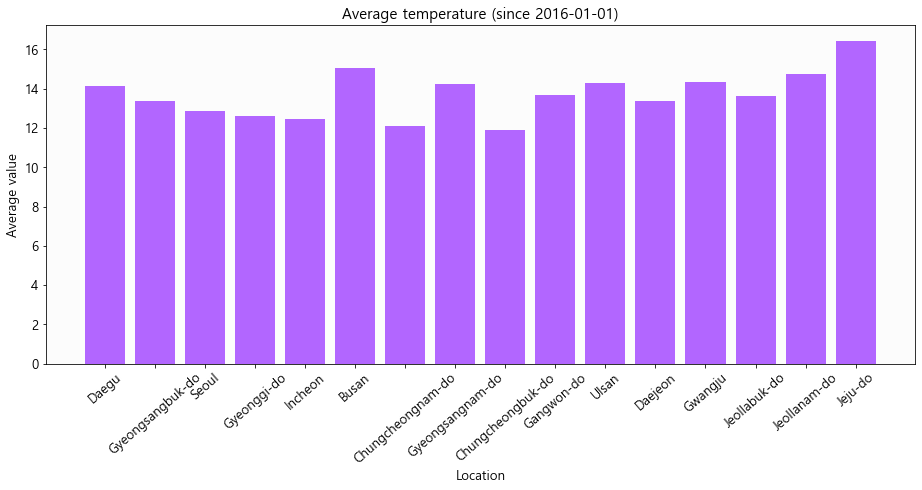

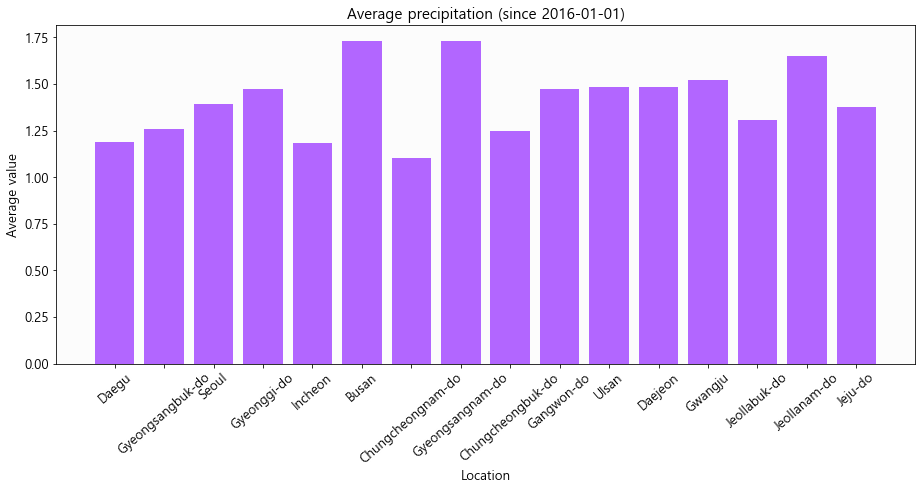

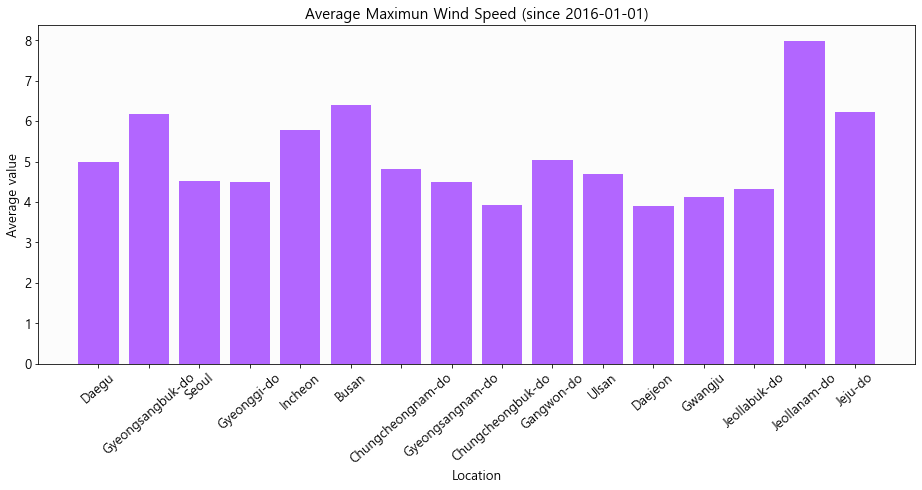

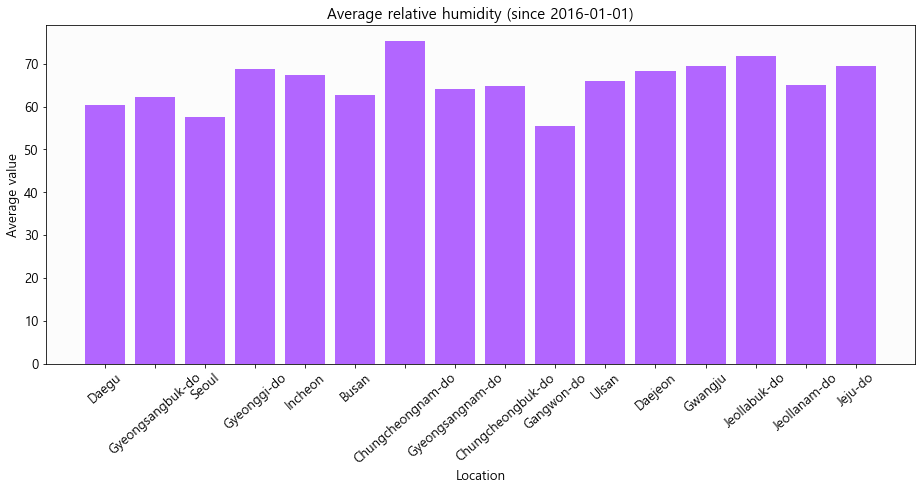

In [58]:
# Create a dataframe with selective average features
weather_avg = pd.DataFrame(
    [weather_stat.index
     , weather_stat['avg_temp']
     , weather_stat['precipitation']
     , weather_stat['max_wind_speed']
     , weather_stat['avg_relative_humidity']]
    ).T
weather_avg.columns = ['location', 'temperature', 'precipitation'
                       , 'max_wind_speed', 'relative_humidity']

# Order by confirmed cases
sorter = list(pop_meta.location[pop_meta.location != 'Sejong'].values)
weather_avg.location = weather_avg.location.astype('category')
weather_avg.location.cat.set_categories(sorter, inplace=True)
weather_avg = weather_avg.sort_values(['location'])
weather_avg.index = range(len(weather_raw.province.unique()))

# Plot each feature
title_list = ['Average temperature', 'Average precipitation'
              , 'Average Maximun Wind Speed', 'Average relative humidity']
for col, title in zip(weather_avg.columns[1:], title_list):
    plt.figure(figsize=(13, 7))
    plt.title(f'{title} (since 2016-01-01)', fontsize=15)
    plt.xticks(rotation=41)
    plt.bar(weather_avg.location, weather_avg[col], color=color_list[7])
    plt.xlabel('Location')
    plt.ylabel('Average value')
    plt.show()

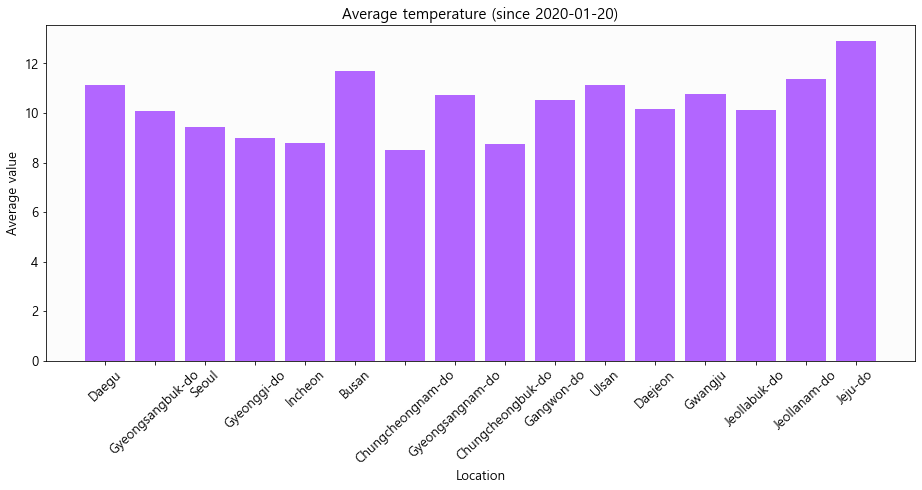

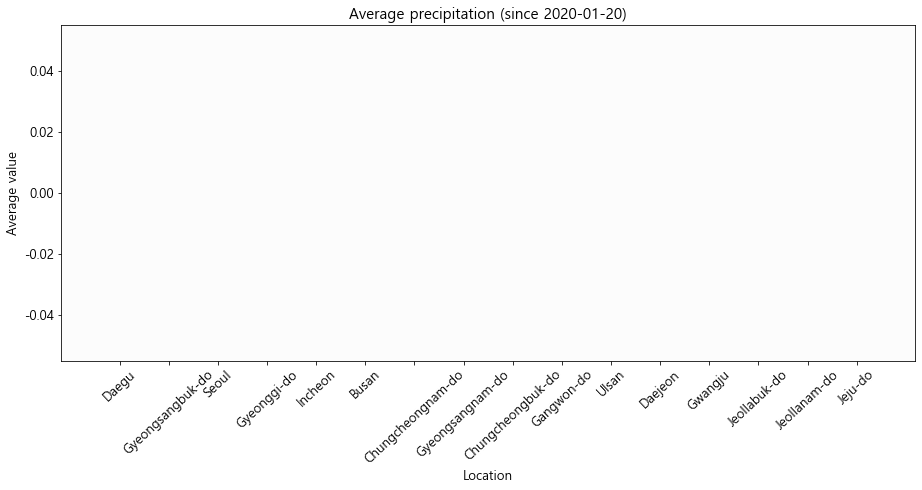

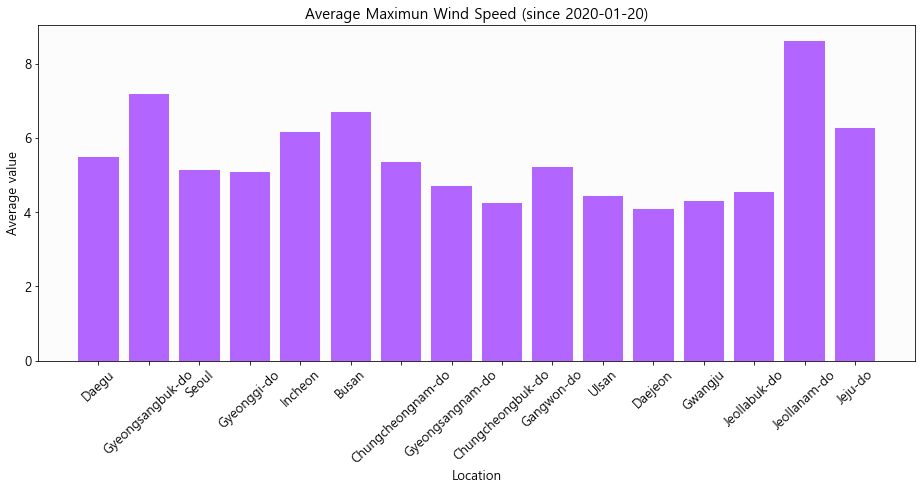

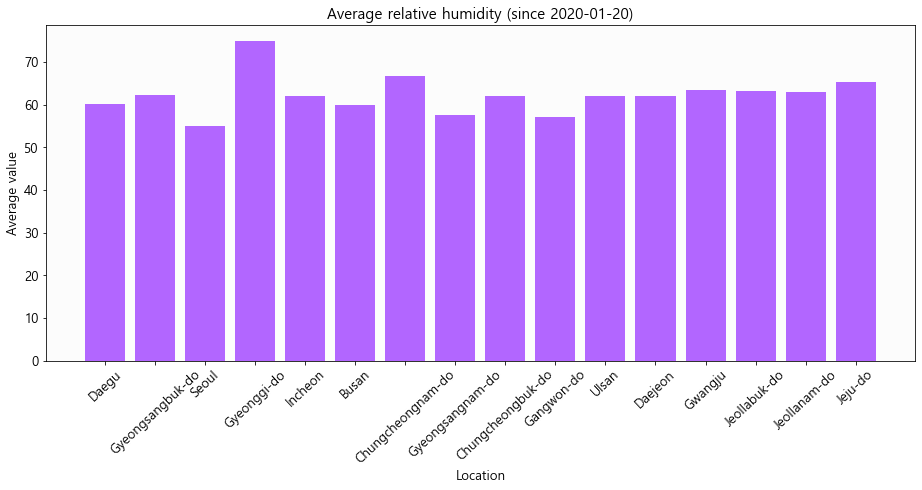

In [59]:
# create a dataframe
weather_covid = weather_raw[weather_raw.date >= '2020-01-20']
weather_cov_stat = weather_covid.loc[:, 'province':].groupby('province').mean()
weather_cov_avg = pd.DataFrame(
    [weather_cov_stat.index
     , weather_cov_stat['avg_temp']
     , weather_cov_stat['precipitation']
     , weather_cov_stat['max_wind_speed']
     , weather_cov_stat['avg_relative_humidity']]
    ).T
# order by confirmed cases
weather_cov_avg.columns = ['location', 'temperature', 'precipitation'
                           , 'max_wind_speed', 'relative_humidity']
weather_cov_avg.location = weather_cov_avg.location.astype('category')
weather_cov_avg.location.cat.set_categories(sorter, inplace=True)
weather_cov_avg = weather_cov_avg.sort_values(['location'])
# Plot features
for col, title in zip(weather_cov_avg.columns[1:], title_list):
    plt.figure(figsize=(13, 7))
    plt.title(f'{title} (since 2020-01-20)', fontsize=15)
    plt.xticks(rotation=43)
    plt.bar(weather_cov_avg.location, weather_cov_avg[col], color=color_list[7])
    plt.xlabel('Location')
    plt.ylabel('Average value')
    plt.show()

In [60]:
patient_raw = pd.read_csv(file_paths[7])
display(patient_raw.head(3).append(patient_raw.tail(3)))
data_col = pd.to_datetime(patient_raw['confirmed_date']).dt.date
date_range = (max(data_col) - min(data_col)).days + 1
print(f'Date range: {date_range} days')
print(f'# {min(data_col)} to {max(data_col)}')

patient_id  global_num     sex birth_year  age country province  \
0     1000000001         2.0    male       1964  50s   Korea    Seoul   
1     1000000002         5.0    male       1987  30s   Korea    Seoul   
2     1000000003         6.0    male       1964  50s   Korea    Seoul   
4001  7000000012         NaN  female        NaN  20s   Korea  Jeju-do   
4002  7000000013         NaN  female        NaN  10s   China  Jeju-do   
4003  7000000014         NaN  female        NaN  30s   Korea  Jeju-do   

             city disease        infection_case  infection_order infected_by  \
0       Gangseogu     NaN       overseas inflow              1.0         NaN   
1     Jungnang-gu     NaN       overseas inflow              1.0         NaN   
2       Jongno-gu     NaN  contact with patient              2.0  2002000001   
4001      Jeju-do     NaN       overseas inflow              NaN         NaN   
4002      Jeju-do     NaN       overseas inflow              NaN         NaN   
4003      Jeju-do     NaN         Itaewon Clubs              NaN         NaN   

     contact_number symptom_onset_date confirmed_date released_date  \
0                75         2020-01-22     2020-01-23    2020-02-05   
1                31                NaN     2020-01-30    2020-03-02   
2                17                NaN     2020-01-30    2020-02-19   
4001              9                NaN     2020-04-03    2020-05-05   
4002              6                NaN     2020-04-14    2020-04-26   
4003            NaN                NaN     2020-05-09           NaN   

     deceased_date     state  
0              NaN  released  
1              NaN  released  
2              NaN  released  
4001           NaN  released  
4002           NaN  released  
4003           NaN  isolated

Date range: 134 days
# 2020-01-20 to 2020-06-01


In [61]:
print(f'Number of confirmed cases in test data ({last_update}):', test_raw.iloc[-1, :].confirmed)

Number of confirmed cases in test data (2020-05-31): 11468


In [62]:
print('Unique gender values:', patient_raw.sex.unique())
print('Number of nan values:', patient_raw.sex.isna().sum())

Unique gender values: ['male' 'female' nan]
Number of nan values: 330


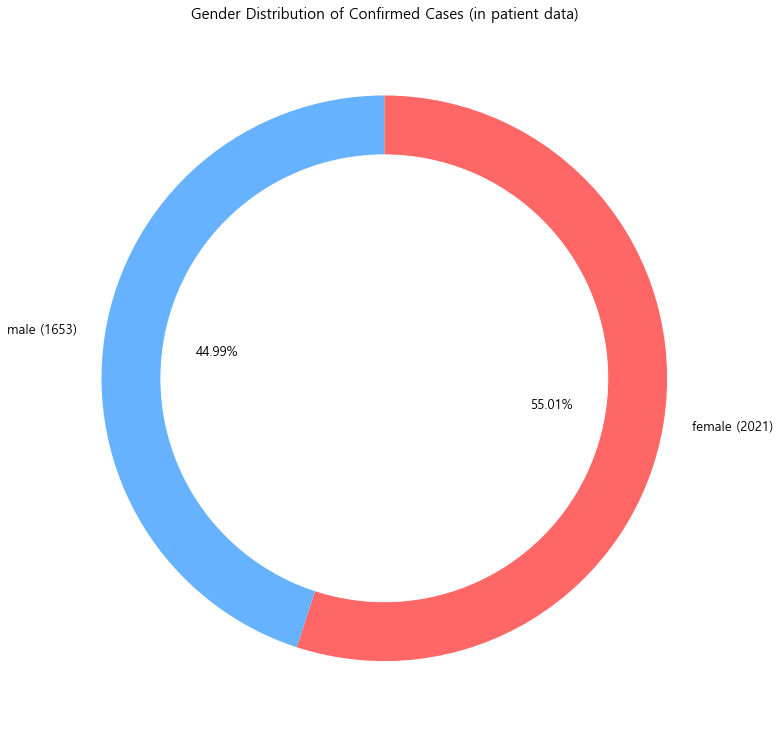

In [63]:
gender_dis = patient_raw[['patient_id', 'sex']].groupby('sex', as_index=False).count()
gender_dis.columns = ['gender', 'confirmed']

fig, ax = plt.subplots(figsize=(11, 11))
colors = [color_list[0] , color_list[5]]
plt.title('Gender Distribution of Confirmed Cases (in patient data)', fontsize=15)
pop_circle=plt.Circle((0,0), 0.79, color='white')
plt.pie(gender_dis.confirmed
        , labels=[f'female ({gender_dis.confirmed[0]})', f'male ({gender_dis.confirmed[1]})']
        , autopct='%.2f%%'
        , colors = colors
        , startangle=90
        , counterclock=False)
p=plt.gcf()
p.gca().add_artist(pop_circle)
plt.show()

In [64]:
# get proportion in patient data
gender_dis['proportion'] = round(gender_dis.iloc[:,-1]
                                 /sum(gender_dis.confirmed) * 100, 2).values
# get proportion in gender data
gender_raw_dis = gender_raw.iloc[-2:, [2,3]]
gender_raw_dis['proportion'] = round(gender_raw_dis.iloc[:,-1]
                                     /sum(gender_raw_dis.confirmed) * 100, 2).values
# show difference
print('[Gender distribution in patient data]')
display(gender_dis.sort_values('confirmed', ascending=False))
print('[Gender distribution in gender data]')
display(gender_raw_dis.sort_values('confirmed', ascending=False))

[Gender distribution in patient data]


gender  confirmed  proportion
0  female       2021       55.01
1    male       1653       44.99

[Gender distribution in gender data]


sex  confirmed  proportion
181  female       6673       58.19
180    male       4795       41.81

In [65]:
print('Number of unique infection orders:', len(patient_raw.infection_order.unique()))
print(patient_raw.infection_order.unique())
print('Number of non-nan values: ', len(patient_raw) - sum(patient_raw.infection_order.isna()))

Number of unique infection orders: 7
[ 1.  2.  3.  4.  5. nan  6.]
Number of non-nan values:  31


In [66]:
print('[Distribution by order]')
order_stat = patient_raw[['patient_id', 'infection_order']].groupby('infection_order').count()
order_stat.columns = ['no_of_patients']
display(order_stat)

[Distribution by order]


no_of_patients
infection_order                
1.0                          11
2.0                           8
3.0                           6
4.0                           2
5.0                           3
6.0                           1

In [67]:
print('[Basic statistics]')
patient_raw.contact_number.describe()

[Basic statistics]


count     680
unique     81
top         2
freq       86
Name: contact_number, dtype: object

In [68]:
print('[Count for each number]')
print(patient_raw.contact_number.value_counts() >0 )
patient_raw['contact_number'].fillna(0, inplace=True)
minus_count = patient_raw['contact_number'].str.isdigit()   # 숫자문자로만 구성 여부
patient_fill_na = patient_raw.copy()
patient_fill_na['contact_number'] = patient_raw['contact_number'].replace('-', 0)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(patient_fill_na['contact_number'])
zero_more_contact = patient_fill_na[patient_fill_na['contact_number' ].astype(int) > 0].sort_values(by='contact_number', ascending=False)
two_hundred_more_contact = zero_more_contact[zero_more_contact['contact_number'].astype(int) >= 200]
zero_more_contact

[Count for each number]
2     True
3     True
1     True
0     True
4     True
      ... 
43    True
20    True
47    True
78    True
89    True
Name: contact_number, Length: 81, dtype: bool
0         75
1         31
2         17
3          9
4          2
5         43
6          0
7          0
8         68
9          6
10        23
11         0
12       117
13        27
14         8
15         0
16         0
17         0
18         0
19         0
20         0
21         0
22         0
23         0
24         0
25         0
26         0
27         0
28         0
29         0
30         0
31         0
32         0
33         0
34         0
35         0
36         0
37         0
38         0
39         0
40         0
41         0
42         0
43         0
44         0
45         0
46         0
47         0
48         0
49         0
50         0
51         0
52         0
53         0
54         0
55         0
56         0
57         0
58         0
59         0
60         0
61         0
62 

patient_id  global_num     sex birth_year  age country  \
1478  2000000002         4.0    male       1964  50s   Korea   
1834  2000000358      8988.0  female       1970  50s   Korea   
1333  1500000002       372.0  female        NaN  60s   Korea   
2078  2000000602     10395.0  female       1995  20s   Korea   
1846  2000000370      9091.0    male       1982  30s   Korea   
...          ...         ...     ...        ...  ...     ...   
2501  4100000065         NaN    male       2018   0s   Korea   
522   1000000523     10146.0  female       1943  70s   Korea   
879   1100000017         NaN    male       1978  40s   Korea   
1094  1300000025      9945.0  female        NaN  10s   Korea   
2560  4100000124         NaN    male       1990  30s   Korea   

               province           city disease            infection_case  \
1478        Gyeonggi-do  Pyeongtaek-si     NaN           overseas inflow   
1834        Gyeonggi-do    Seongnam-si     NaN      contact with patient   
1333            Daejeon     Yuseong-gu     NaN                       etc   
2078        Gyeonggi-do       Gunpo-si     NaN           overseas inflow   
1846        Gyeonggi-do      Yongin-si     NaN      contact with patient   
...                 ...            ...     ...                       ...   
2501  Chungcheongnam-do     Cheonan-si     NaN      contact with patient   
522               Seoul     Gangnam-gu     NaN           overseas inflow   
879               Busan         Nam-gu     NaN  Cheongdo Daenam Hospital   
1094            Gwangju            NaN     NaN           overseas inflow   
2560  Chungcheongnam-do     Cheonan-si     NaN           overseas inflow   

      infection_order infected_by contact_number symptom_onset_date  \
1478              1.0         NaN             95                NaN   
1834              NaN  2000000205              9                NaN   
1333              NaN         NaN              9                NaN   
2078              NaN         NaN              9         2020-03-29   
1846              NaN  2000000371              9                NaN   
...               ...         ...            ...                ...   
2501              NaN  4100000032              1                NaN   
522               NaN         NaN              1                NaN   
879               NaN         NaN              1         2020-02-22   
1094              NaN         NaN              1         2020-03-31   
2560              NaN         NaN              1         2020-03-21   

     confirmed_date released_date deceased_date     state  
1478     2020-01-27    2020-02-09           NaN  released  
1834     2020-03-23           NaN           NaN  isolated  
1333     2020-02-22    2020-03-28           NaN  released  
2078     2020-04-08           NaN           NaN  isolated  
1846     2020-03-24           NaN           NaN  isolated  
...             ...           ...           ...       ...  
2501     2020-03-01    2020-03-18           NaN  released  
522      2020-04-03           NaN           NaN  released  
879      2020-02-23           NaN           NaN  released  
1094     2020-04-01           NaN           NaN  isolated  
2560     2020-03-25    2020-04-20           NaN  released  

[606 rows x 18 columns]

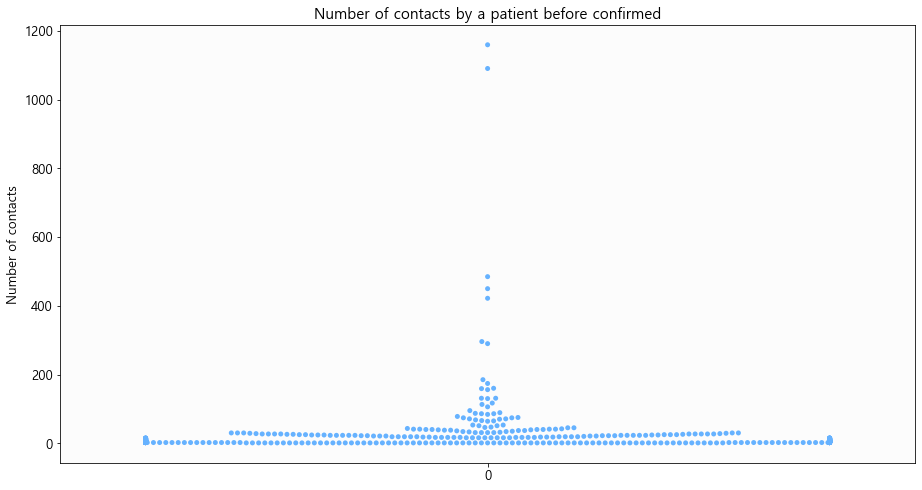

In [69]:
fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Number of contacts by a patient before confirmed', fontsize=15)
sns.swarmplot(data = zero_more_contact['contact_number'], color = color_list[5])
#ax.set_xticks(ax.get_xticks()[::7])
#ax.set_xlabel('Patients', size=13)
ax.set_ylabel('Number of contacts', size=13)
plt.show()

In [70]:
print('[Outliers with more than or equal to 200 contacts]')
idx1 = patient_raw.index
idx2 = two_hundred_more_contact.index
result = idx1.isin(idx2)
result
patient_outliers = patient_raw.loc[result].sort_values('contact_number', ascending=False)
patient_outliers
print('Number of outliers:', len(patient_outliers))
patient_outliers[ ['contact_number', 'sex', 'age', 'country', 'province', 'disease', 'infection_case', 'confirmed_date', 'state'] ]

[Outliers with more than or equal to 200 contacts]
Number of outliers: 7


contact_number     sex  age country     province disease  \
869             485    male  20s   China        Busan     NaN   
1070            450  female  40s   Korea      Gwangju     NaN   
1479            422    male  40s   China  Gyeonggi-do     NaN   
874             296  female  50s   Korea        Busan     NaN   
1482            290    male  30s   Korea  Gyeonggi-do     NaN   
1007           1160  female  60s   Korea        Daegu     NaN   
863            1091    male  10s   Korea        Busan     NaN   

            infection_case confirmed_date     state  
869     Shincheonji Church     2020-02-22  released  
1070       overseas inflow     2020-02-03  released  
1479  contact with patient     2020-02-01  released  
874     Shincheonji Church     2020-02-22  released  
1482       overseas inflow     2020-02-05  released  
1007    Shincheonji Church     2020-02-18  isolated  
863          Onchun Church     2020-02-21  released

In [71]:
print('[Inliers with less than 200 contacts]')
patient_inliers = patient_raw[ ~patient_raw.patient_id.isin(patient_outliers.patient_id) ]
print('Number of inliers:', len(patient_inliers))
print(f'Number of null contacts: {patient_inliers.contact_number.isna().sum()} (excluded)')
print('Number of non null contacts:', len(patient_inliers) - patient_inliers.contact_number.isna().sum())

[Inliers with less than 200 contacts]
Number of inliers: 3997
Number of null contacts: 0 (excluded)
Number of non null contacts: 3997


In [72]:
print('[Inliers - sample]')
patient_inliers = patient_fill_na[ ~patient_fill_na.patient_id.isin(patient_outliers.patient_id) ]
patient_inliers['contact_number'] = patient_inliers['contact_number'].astype('int')
display(patient_inliers.sort_values('contact_number', ascending=False)\
[ ['contact_number', 'sex', 'age', 'country', 'province', 'disease', 'infection_case', 'confirmed_date', 'state'] ].head(3))

[Inliers - sample]


contact_number   sex  age country           province disease  \
990              185  male  50s   Korea              Busan     NaN   
2526             174  male  50s   Korea  Chungcheongnam-do     NaN   
1006             160  male  10s   Korea              Busan     NaN   

            infection_case confirmed_date     state  
990                    etc     2020-04-18  isolated  
2526  contact with patient     2020-03-05  released  
1006                   etc     2020-05-29  isolated

In [73]:
print('[Average contacts by date - sample]')
patient_time_contact = patient_inliers[['contact_number', 'confirmed_date']].groupby('confirmed_date').mean()
patient_time_contact.head(3).append(patient_time_contact.tail(3))

[Average contacts by date - sample]


contact_number
confirmed_date                
2020-01-20                 0.0
2020-01-23                75.0
2020-01-26                16.0
2020-05-30                 0.0
2020-05-31                 0.0
2020-06-01                 0.0

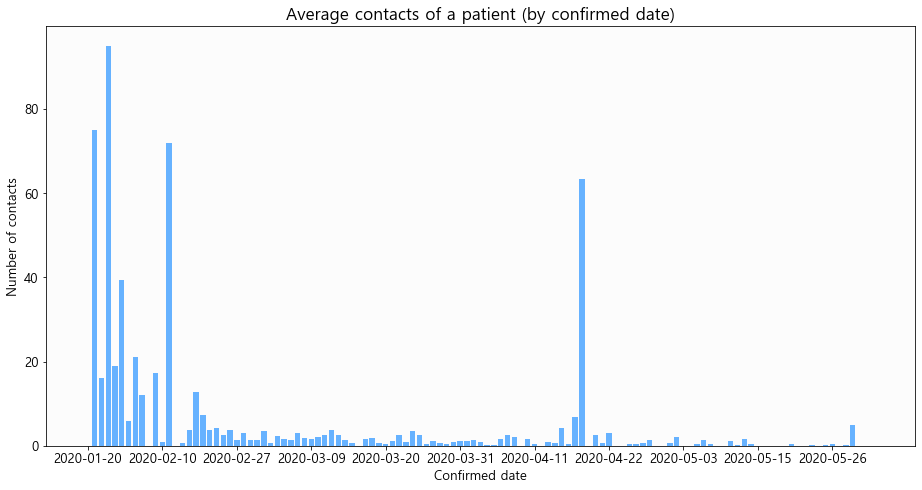

In [74]:
fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Average contacts of a patient (by confirmed date)', fontsize=17)
plt.bar(patient_time_contact.index
        , patient_time_contact.contact_number
        , color = color_list[5])
ax.set_xlabel('Confirmed date', size=13)
ax.set_ylabel('Number of contacts', size=13)
ax.set_xticks(ax.get_xticks()[::11])
plt.show()

In [75]:
route_raw = pd.read_csv(file_paths[8])
display(route_raw.head(3).append(route_raw.tail(3)))
data_col = pd.to_datetime(route_raw['date']).dt.date
date_range = (max(data_col) - min(data_col)).days + 1
print(f'Date range: {date_range} days')
print(f'# {min(data_col)} to {max(data_col)}')

patient_id  global_num        date          province         city  \
0     1000000001         2.0  2020-01-22       Gyeonggi-do     Gimpo-si   
1     1000000001         2.0  2020-01-24             Seoul      Jung-gu   
2     1000000002         5.0  2020-01-25             Seoul  Seongbuk-gu   
8089  6100000090         NaN  2020-03-25  Gyeongsangnam-do   Yangsan-si   
8090  6100000090         NaN  2020-03-25  Gyeongsangnam-do   Yangsan-si   
8091  6100000090         NaN  2020-03-25  Gyeongsangnam-do   Yangsan-si   

          type   latitude   longitude  
0      airport  37.615246  126.715632  
1     hospital  37.567241  127.005659  
2          etc  37.592560  127.017048  
8089     store  35.336944  129.026389  
8090  hospital  35.335757  129.025003  
8091     store  35.336944  129.026389

Date range: 134 days
# 2020-01-20 to 2020-06-01


In [76]:
print(f'Number of logs: {len(route_raw)}')
print(f'Number of logged locations: {(len(route_raw.province.unique()))} (except for Sejong)')
print(sorted(route_raw.province.unique()))

Number of logs: 8092
Number of logged locations: 16 (except for Sejong)
['Busan', 'Chungcheongbuk-do', 'Chungcheongnam-do', 'Daegu', 'Daejeon', 'Gangwon-do', 'Gwangju', 'Gyeonggi-do', 'Gyeongsangbuk-do', 'Gyeongsangnam-do', 'Incheon', 'Jeju-do', 'Jeollabuk-do', 'Jeollanam-do', 'Seoul', 'Ulsan']


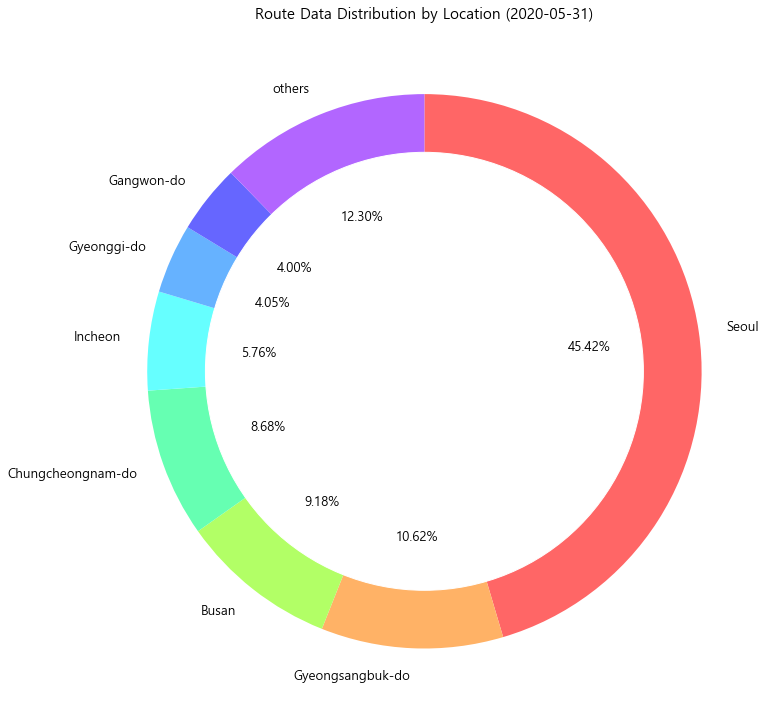

In [77]:
# Make a dataframe
route_location = pd.DataFrame()
route_location['location'] = route_raw.groupby('province').count().index
route_location['logs'] = route_raw.groupby('province').count().patient_id.values
# Order by the number of logs
route_location = route_location.sort_values('logs', ascending=False)
route_location
# Put other than top 7 locations into others
route_location.loc['others', 'logs'] = route_location.iloc[7:,1].sum()
route_location.loc['others', 'location'] = 'others'
# Keep only 7 & others rows
route_location = route_location[ route_location.logs >= route_location.iloc[6,1]]
# Plot distribution
fig, ax = plt.subplots(figsize=(11, 11))
colors = color_list
plt.title(f'Route Data Distribution by Location ({last_update})', fontsize=15)
pop_circle=plt.Circle((0,0), 0.79, color='white')
plt.pie(route_location.logs
        , labels=route_location.location
        , colors = colors
        , autopct='%.2f%%'
        , startangle=90
        , counterclock=False)
p=plt.gcf()
p.gca().add_artist(pop_circle)
plt.show()

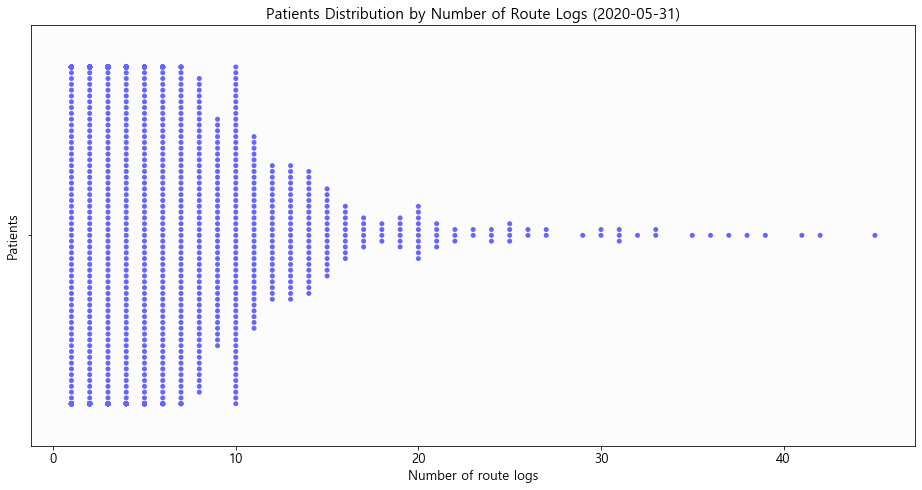

In [78]:
# make a dataframe
route_patient = pd.DataFrame()
route_patient['patient'] = route_raw.groupby('patient_id').count().index
route_patient['logs'] = route_raw.groupby('patient_id').count().date.values
route_patient = route_patient.sort_values('logs', ascending=False)
route_patient.head(3).append(route_patient.tail(3))
# histogram
fig, ax = plt.subplots(figsize=(13, 7))
plt.title(f'Patients Distribution by Number of Route Logs ({last_update})', fontsize=15)
ax.set_xlabel('Number of route logs', size=13)
ax.set_ylabel('Patients', size=13)
sns.swarmplot(route_patient.logs.values, color = color_list[6])
plt.show()

In [79]:
print('[Basic stats]')
route_patient.logs.describe()

[Basic stats]


count    1472.000000
mean        5.497283
std         5.616209
min         1.000000
25%         2.000000
50%         4.000000
75%         7.000000
max        45.000000
Name: logs, dtype: float64

In [80]:
print('Number of outliers (by rule of \'Q3+1.5*IQR\'):', len(route_patient[ route_patient.logs > 14 ]))

Number of outliers (by rule of 'Q3+1.5*IQR'): 90


In [81]:
print('[Edge cases - patients with the 3 most route logs]')
edge_ids = route_patient.head(3).patient.values
patient_raw[ (patient_raw.patient_id == edge_ids[0]) | (patient_raw.patient_id == edge_ids[1]) | (patient_raw.patient_id== edge_ids[2]) ].T

[Edge cases - patients with the 3 most route logs]


416                845                 2356
patient_id               1000000417         1000000846          3009000014
global_num                     9644              11375                 NaN
sex                          female                NaN                male
birth_year                     1992                NaN                1969
age                             20s                NaN                 50s
country                       Korea              Korea               Korea
province                      Seoul              Seoul          Gangwon-do
city                        Mapo-gu                etc            Wonju-si
disease                         NaN                NaN                 NaN
infection_case      overseas inflow  KB Life Insurance  Shincheonji Church
infection_order                 NaN                NaN                 NaN
infected_by                     NaN                NaN                 NaN
contact_number                    0                  0                  17
symptom_onset_date              NaN                NaN                 NaN
confirmed_date           2020-03-29         2020-05-27          2020-03-04
released_date                   NaN                NaN          2020-03-28
deceased_date                   NaN                NaN                 NaN
state                      released           isolated            released

Number of unique activities:  25


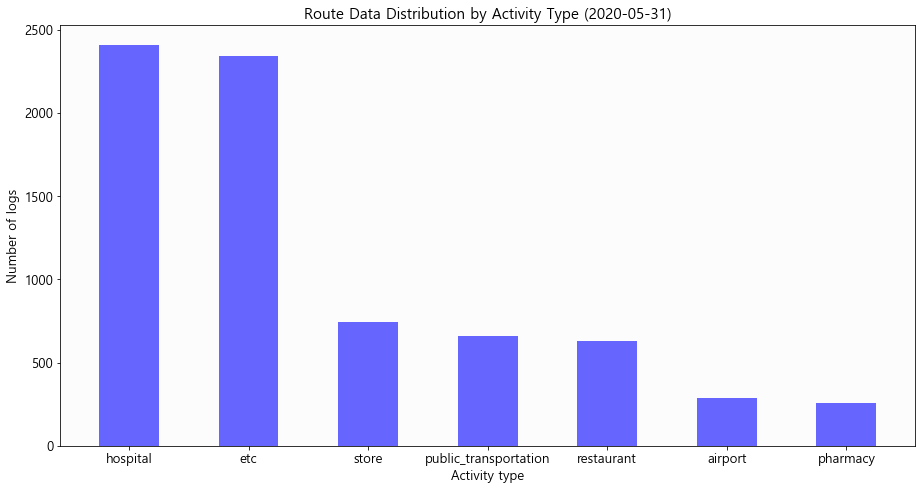

In [82]:
# Make a dataframe
route_type = pd.DataFrame()
route_type['activity'] = route_raw.groupby('type').count().index
route_type['logs'] = route_raw.groupby('type').count().patient_id.values
route_type = route_type.sort_values('logs', ascending=False)
print('Number of unique activities: ', len(route_type))
# Plot distribution
fig, ax = plt.subplots(figsize=(13, 7))
plt.title(f'Route Data Distribution by Activity Type ({last_update})', fontsize=15)
ax.set_xlabel('Activity type', size=13)
ax.set_ylabel('Number of logs', size=13)
plt.bar(route_type.activity[:7], route_type.logs[:7], color = color_list[6], width=0.5)
plt.show()

In [83]:
seoul_raw = pd.read_csv(file_paths[9])
display(seoul_raw.head(3).append(seoul_raw.tail(3)))
data_col = pd.to_datetime(seoul_raw['date']).dt.date
date_range = (max(data_col) - min(data_col)).days + 1
print(f'Date range: {date_range} days')
print(f'# {min(data_col)} to {max(data_col)}')

date  hour  birth_year     sex province           city  fp_num
0       2020-01-01     0          20  female    Seoul      Dobong-gu   19140
1       2020-01-01     0          20    male    Seoul      Dobong-gu   19950
2       2020-01-01     0          20  female    Seoul  Dongdaemun-gu   25450
863997  2020-04-30    23          20  female    Seoul     Yongsan-gu   18570
863998  2020-04-30    23          30  female    Seoul   Seodaemun-gu   21100
863999  2020-04-30    23          40    male    Seoul     Gangnam-gu   45730

Date range: 121 days
# 2020-01-01 to 2020-04-30


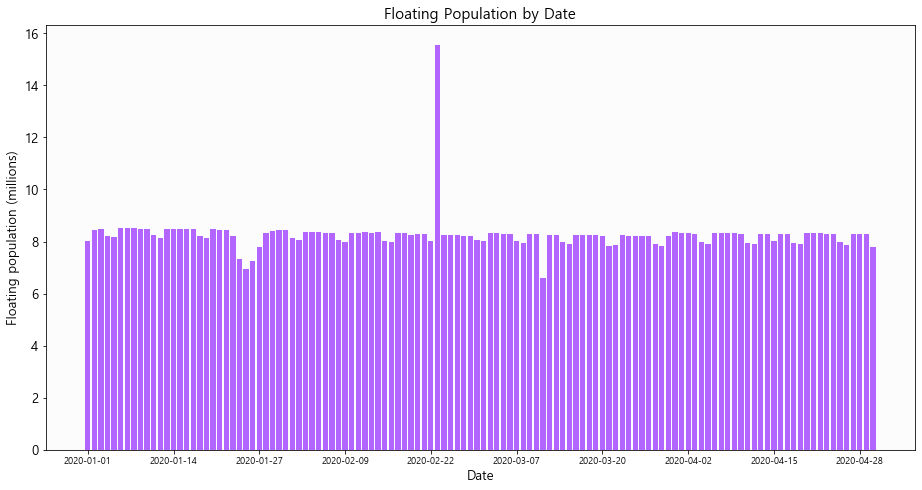

In [84]:
fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Floating Population by Date', size=15)
plt.bar(seoul_raw.date.unique()
       , seoul_raw.groupby(['date', 'hour']).sum()\
         .groupby('date').mean().apply(lambda x: x/1000000)\
         .fp_num.values
       , color=color_list[7])
ax.set_xlabel('Date', size=13)
ax.set_ylabel('Floating population (millions)', size=13)
plt.xticks(rotation=0, size=9)
ax.set_xticks(ax.get_xticks()[::13])
plt.show()

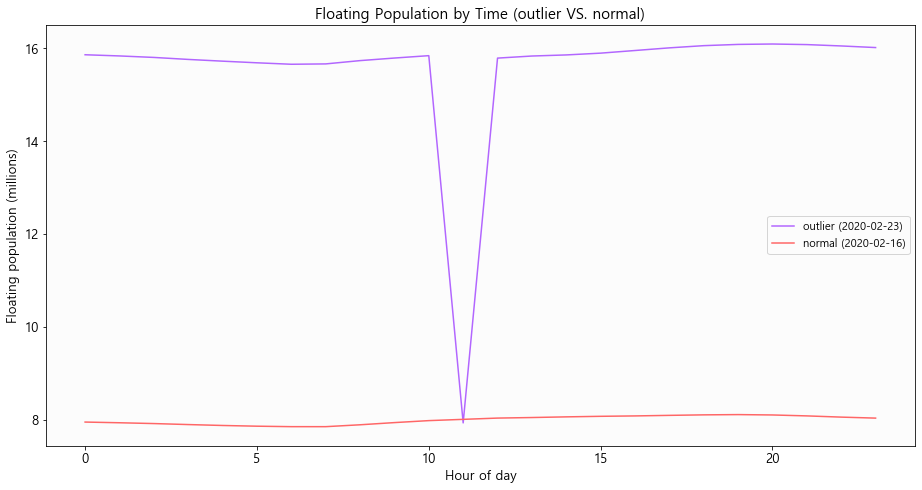

In [85]:
fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Floating Population by Time (outlier VS. normal)', size=15)
outlier = seoul_raw[ seoul_raw.date == '2020-02-23' ].groupby('hour')\
                                                     .sum().apply(lambda x: x/1000000)\
                                                     .fp_num
normal = seoul_raw[ seoul_raw.date == '2020-02-16' ].groupby('hour')\
                                                     .sum().apply(lambda x: x/1000000)\
                                                     .fp_num
plt.plot(outlier, color=color_list[7])
plt.plot(normal, color=color_list[0])
ax.set_xlabel('Hour of day', size=13)
ax.set_ylabel('Floating population (millions)', size=13)
plt.legend(['outlier (2020-02-23)', 'normal (2020-02-16)'], fontsize=11, loc='center right')
plt.show()

In [86]:
print('[Before havling \'fp_num\'')
display(seoul_raw[seoul_raw.date=='2020-02-23'][seoul_raw.hour!=11].tail(1))
seoul_raw.loc[ (seoul_raw.date=='2020-02-23') & (seoul_raw.hour!=11), 'fp_num' ] /= 2
print('[After havling \'fp_num\'')
display(seoul_raw[seoul_raw.date=='2020-02-23'][seoul_raw.hour!=11].tail(1))

[Before havling 'fp_num'


date  hour  birth_year   sex province        city  fp_num
388799  2020-02-23    23          70  male    Seoul  Yongsan-gu   17000

[After havling 'fp_num'


date  hour  birth_year   sex province        city  fp_num
388799  2020-02-23    23          70  male    Seoul  Yongsan-gu  8500.0

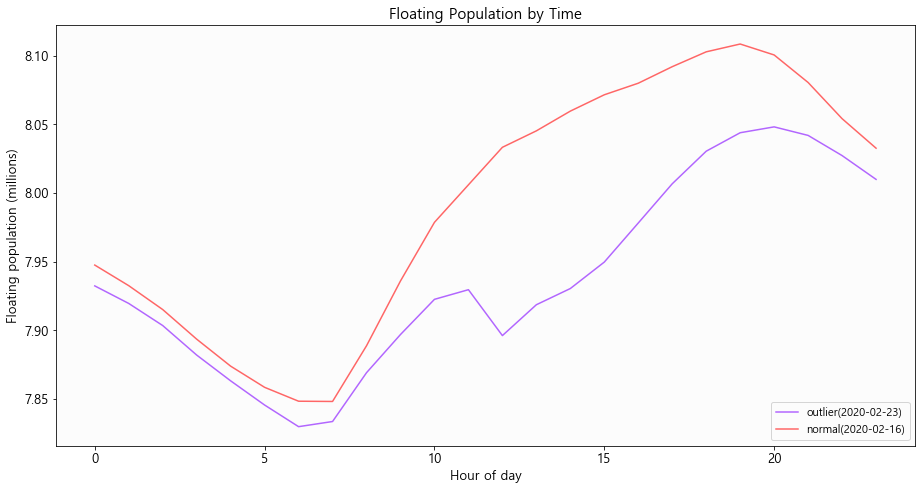

In [87]:
fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Floating Population by Time', size=15)
plt.plot(seoul_raw[ seoul_raw.date == '2020-02-23' ].groupby('hour')\
                                                    .sum().apply(lambda x: x/1000000)\
                                                    .fp_num
         , color=color_list[7])
plt.plot(normal, color=color_list[0])
ax.set_ylabel('Floating population (millions)', size=13)
ax.set_xlabel('Hour of day', size=13)
plt.legend(['outlier(2020-02-23)', 'normal(2020-02-16)'], fontsize=11, loc='lower right')
plt.show()

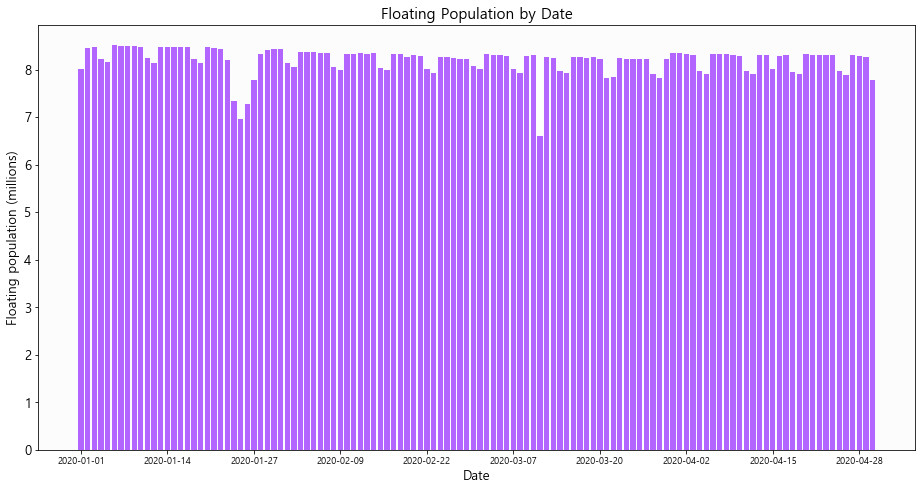

In [88]:
fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Floating Population by Date', size=15)
plt.bar(seoul_raw.date.unique()
       , seoul_raw.groupby(['date', 'hour']).sum()\
         .groupby('date').mean().apply(lambda x: x/1000000)\
         .fp_num.values
       , color=color_list[7])
ax.set_xlabel('Date', size=13)
ax.set_ylabel('Floating population (millions)', size=13)
plt.xticks(rotation=0, size=9)
ax.set_xticks(ax.get_xticks()[::13])
plt.show()

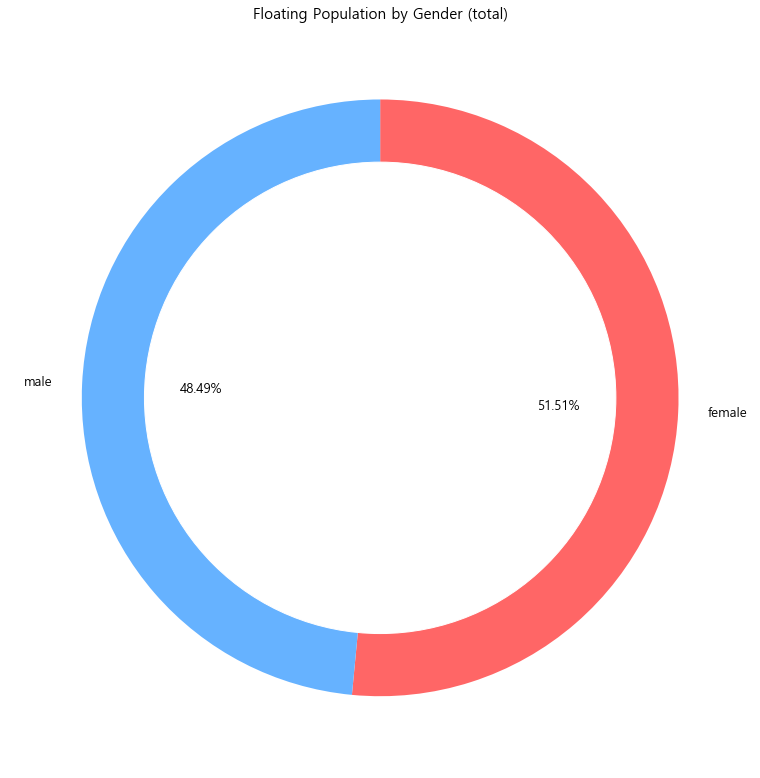

In [89]:
# get 2 separate tables by gender
seoul_female, seoul_male = seoul_raw[seoul_raw.sex == 'female'], seoul_raw[seoul_raw.sex == 'male']
# pie chart
fig, ax = plt.subplots(figsize=(11, 11))
colors = [color_list[0] , color_list[5]]
plt.title('Floating Population by Gender (total)', size=15)
pop_circle=plt.Circle((0,0), 0.79, color='white')
plt.pie([seoul_female.fp_num.sum()
         , seoul_male.fp_num.sum()]
        , labels=['female', 'male']
        , colors = colors
        , autopct='%.2f%%'
        , startangle=90
        , counterclock=False)
p=plt.gcf()
p.gca().add_artist(pop_circle)
plt.show()

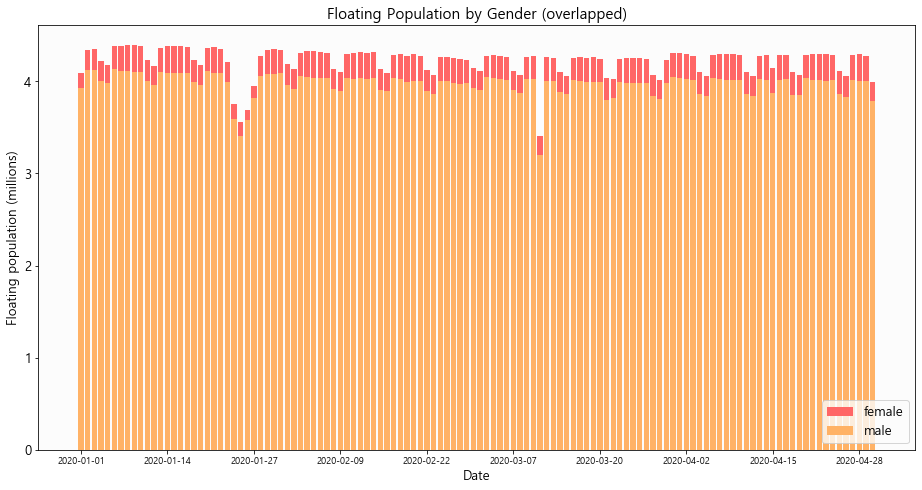

In [90]:
fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Floating Population by Gender (overlapped)', size=15)
for each, i in zip([seoul_female, seoul_male], range(2)):
    plt.bar(each.date.unique()
       , each.groupby(['date', 'hour']).sum()\
        .groupby('date').mean().apply(lambda x: x/1000000)\
        .fp_num.values
       , color=color_list[i])
ax.set_xlabel('Date', size=13)
ax.set_ylabel('Floating population (millions)', size=13)
plt.xticks(rotation=0, size=9)
plt.legend(['female', 'male'], loc='lower right')
ax.set_xticks(ax.get_xticks()[::13])
plt.show()

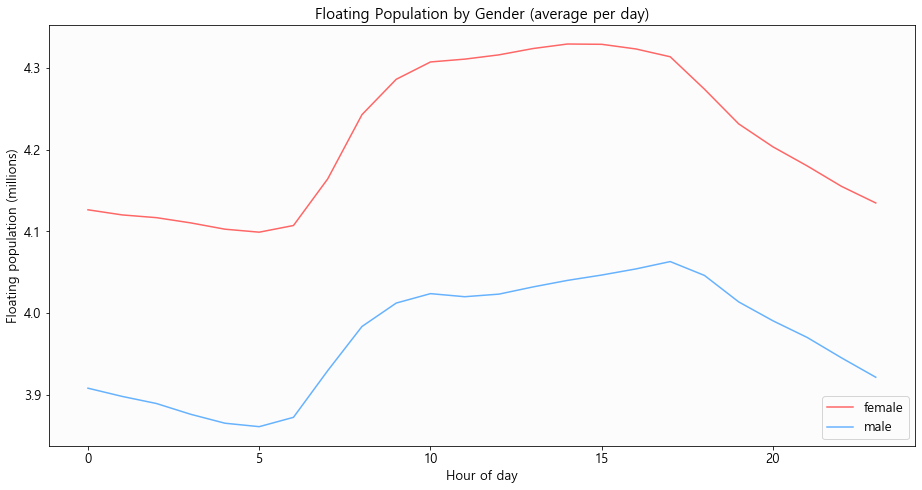

In [91]:
fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Floating Population by Gender (average per day)', size=15)
plt.plot(seoul_female.groupby(['date', 'hour']).sum()\
         .groupby('hour').mean().apply(lambda x: x/1000000)\
         .fp_num
         , color=color_list[0])
plt.plot(seoul_male.groupby(['date', 'hour']).sum()\
         .groupby('hour').mean().apply(lambda x: x/1000000)\
         .fp_num
         , color=color_list[5])
ax.set_ylabel('Floating population (millions)', size=13)
ax.set_xlabel('Hour of day', size=13)
plt.legend(['female', 'male'], loc='lower right')
plt.show()

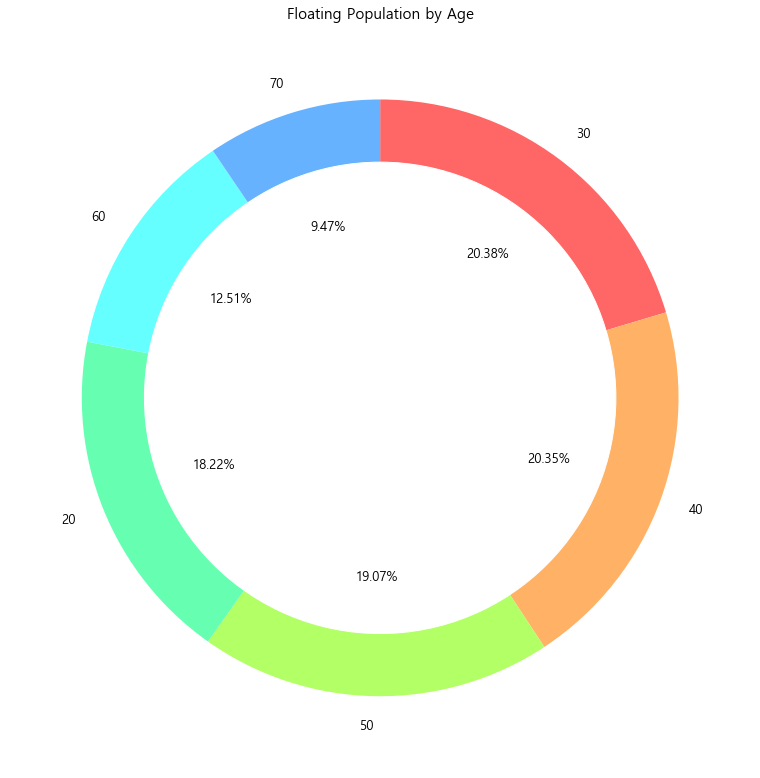

In [92]:
float_age_order = list(seoul_raw.groupby('birth_year').sum().sort_values('fp_num', ascending=False).index)
fig, ax = plt.subplots(figsize=(11, 11))
plt.title('Floating Population by Age', size=15)
pop_circle=plt.Circle((0,0), 0.79, color='white')
colors=color_list
plt.pie(seoul_raw.groupby('birth_year').sum().sort_values('fp_num', ascending=False).fp_num
        , labels=float_age_order
        , colors=colors
        , autopct='%.2f%%'
        , startangle=90
        , counterclock=False)
p=plt.gcf()
p.gca().add_artist(pop_circle)
plt.show()

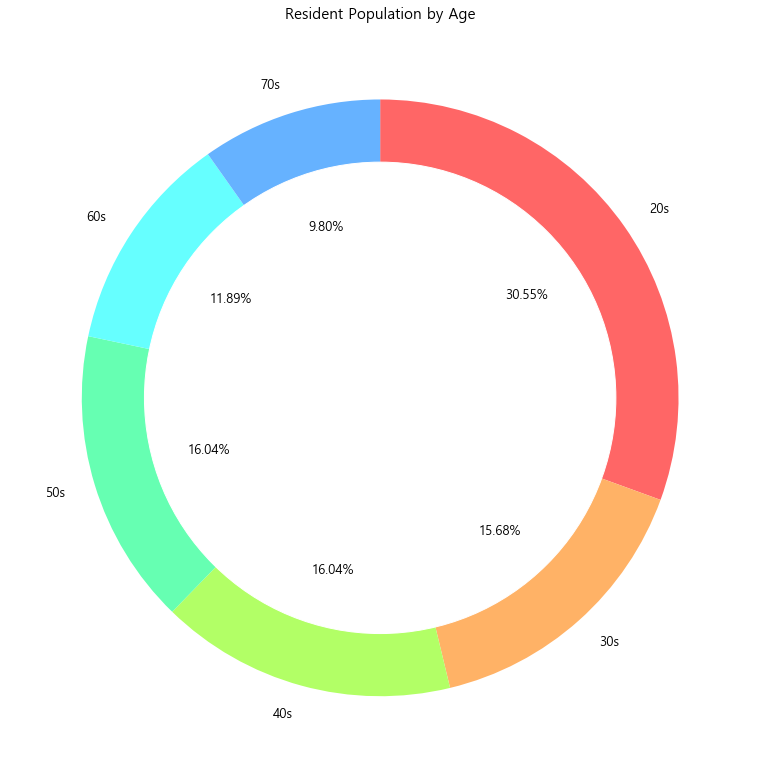

In [93]:
seoul_pop_dis = {'20s': 682490 + 841476 + 1539441, '30s': 1572046, '40s': 1608068
                 , '50s': 1608155, '60s': 1192140, '70s': 681810 + 255068 + 39036 + 6197}
fig, ax = plt.subplots(figsize=(11, 11))
plt.title('Resident Population by Age', size=15)
pop_circle=plt.Circle((0,0), 0.79, color='white')
colors=color_list
plt.pie(seoul_pop_dis.values()
        , labels=seoul_pop_dis.keys()
        , colors=colors
        , autopct='%.2f%%'
        , startangle=90
        , counterclock=False)
p=plt.gcf()
p.gca().add_artist(pop_circle)
plt.show()

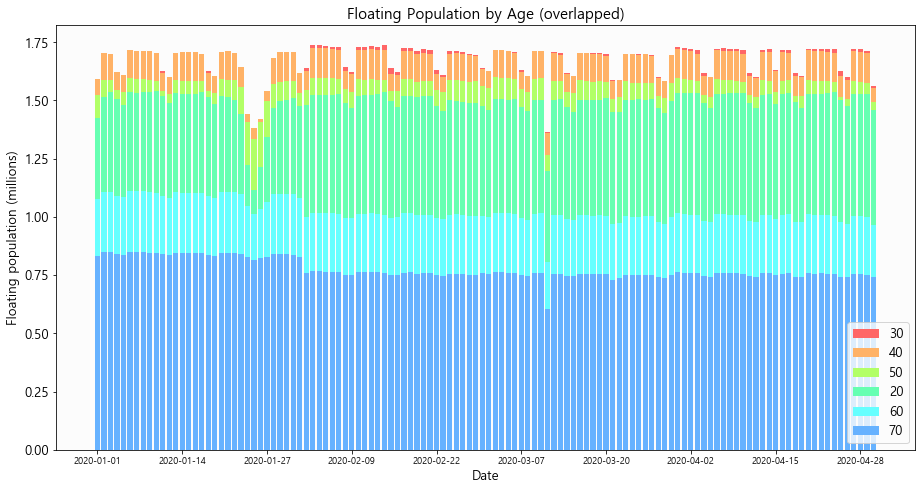

In [94]:
fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Floating Population by Age (overlapped)', size=15)
for age, i in zip(float_age_order, range(len(float_age_order))):
    plt.bar(seoul_raw.date.unique()
            , seoul_raw[seoul_raw.birth_year==age].groupby(['date', 'hour']).sum()\
            .groupby('date').mean().apply(lambda x: x/1000000)\
            .fp_num.values
            , color=color_list[i])
ax.set_xlabel('Date', size=13)
ax.set_ylabel('Floating population (millions)', size=13)
plt.xticks(rotation=0, size=9)
plt.legend(float_age_order
           , loc='lower right'
          )
ax.set_xticks(ax.get_xticks()[::13])
plt.show()

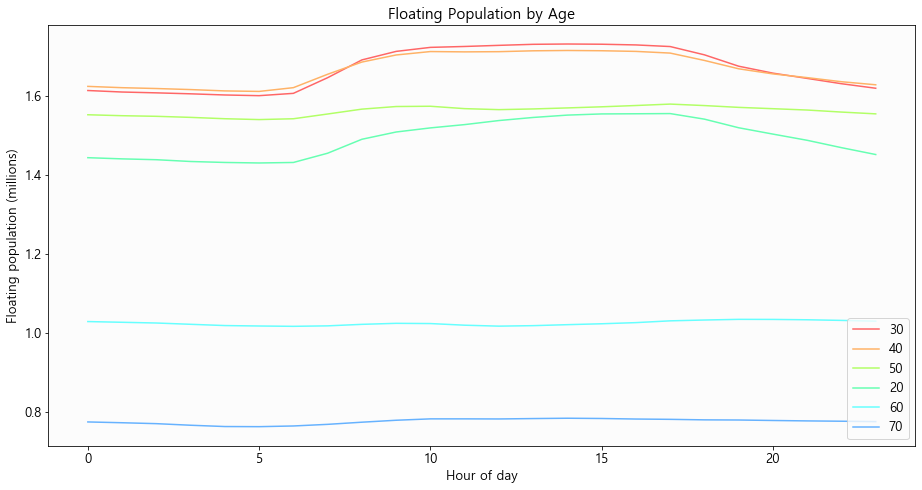

In [95]:
fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Floating Population by Age', size=15)
for age, i in zip(float_age_order, np.arange(len(float_age_order))):
    plt.plot(seoul_raw[seoul_raw.birth_year==age].groupby(['date', 'hour']).sum()\
             .groupby('hour').mean().apply(lambda x: x/1000000)\
             .fp_num
             , color=color_list[i])
ax.set_ylabel('Floating population (millions)', size=13)
ax.set_xlabel('Hour of day', size=13)
plt.legend(float_age_order, loc='lower right')
plt.show()

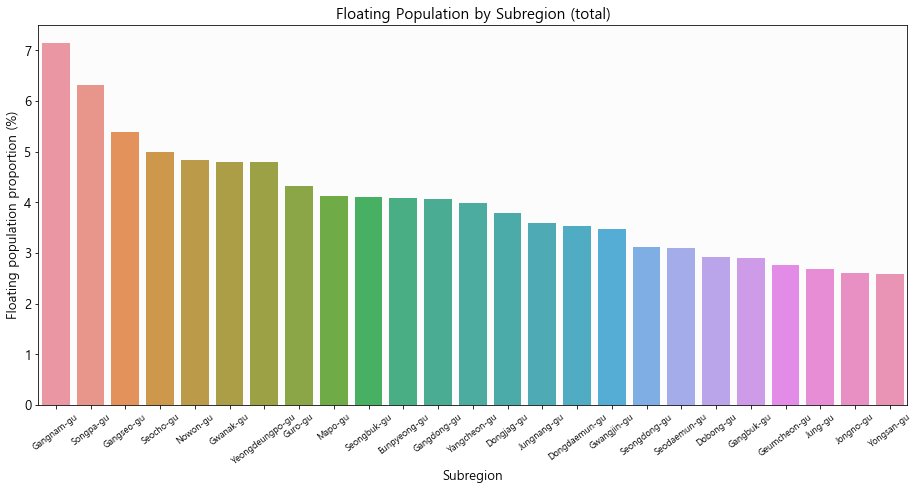

In [96]:
float_area_order = list(seoul_raw.groupby('city').sum().sort_values('fp_num', ascending=False).index)

fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Floating Population by Subregion (total)', size=15)
sns.barplot(float_area_order
           , seoul_raw.groupby('city').sum().sort_values('fp_num', ascending=False).fp_num/(seoul_raw.fp_num.sum())*100)
ax.set_xlabel('Subregion', size=13)
ax.set_ylabel('Floating population proportion (%)', size=13)
plt.xticks(rotation=37, size=9)
plt.show()

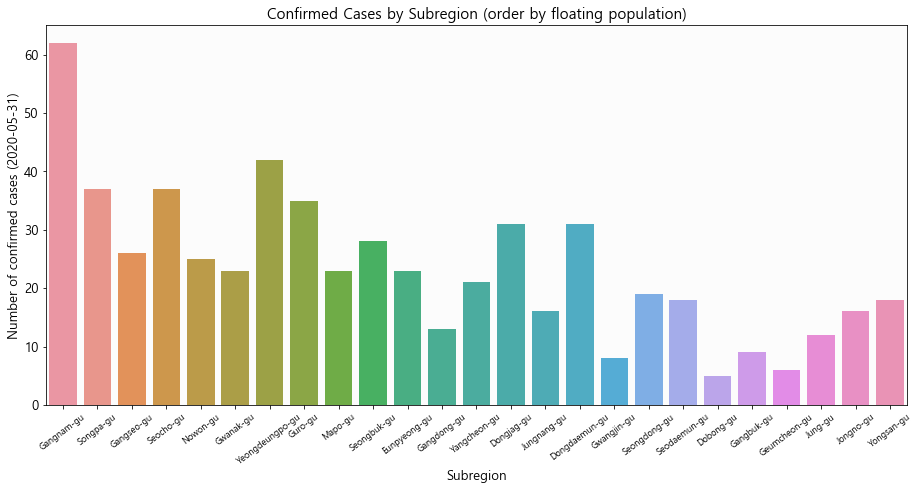

In [97]:
seoul_confirmed = [62, 37, 26, 37, 25
                   , 23, 42, 35, 23, 28
                   , 23, 13, 21, 31, 16
                   , 31, 8, 19, 18, 5
                   , 9, 6, 12, 16, 18]
float_area_order = list(seoul_raw.groupby('city').sum().sort_values('fp_num', ascending=False).index)

fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Confirmed Cases by Subregion (order by floating population)', size=15)
sns.barplot(float_area_order
           , seoul_confirmed)
ax.set_xlabel('Subregion', size=13)
ax.set_ylabel(f'Number of confirmed cases ({last_update})', size=13)
plt.xticks(rotation=37, size=9)
plt.show()

In [98]:
search_raw = pd.read_csv(file_paths[10])
display(search_raw.head(3).append(search_raw.tail(3)))
data_col = pd.to_datetime(search_raw['date']).dt.date
date_range = (max(data_col) - min(data_col)).days + 1
print(f'Date range: {date_range} days')
print(f'# {min(data_col)} to {max(data_col)}')

date     cold      flu  pneumonia  coronavirus
0     2016-01-01  0.11663  0.05590    0.15726      0.00736
1     2016-01-02  0.13372  0.17135    0.20826      0.00890
2     2016-01-03  0.14917  0.22317    0.19326      0.00845
1610  2020-05-29  0.16454  0.04599    0.11699      4.95803
1611  2020-05-30  0.12208  0.03299    0.09090      3.41698
1612  2020-05-31  0.11990  0.03499    0.08436      3.25944

Date range: 1613 days
# 2016-01-01 to 2020-05-31


No handles with labels found to put in legend.


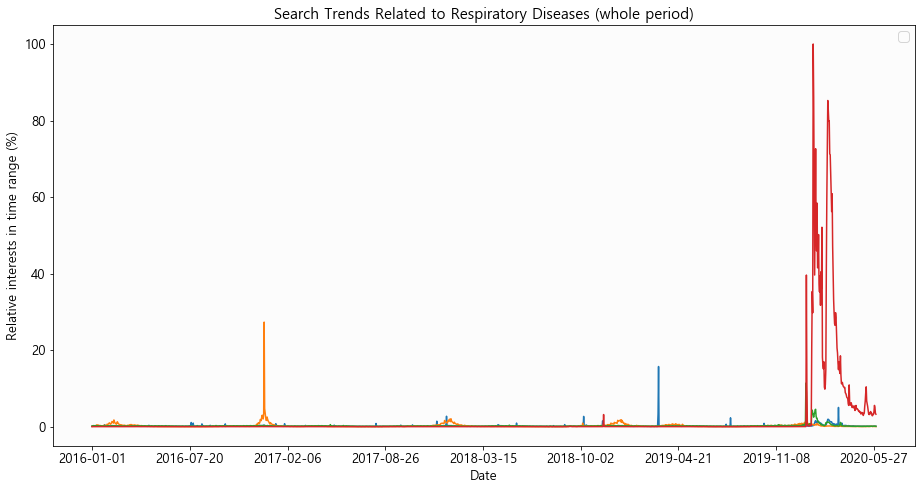

In [99]:
fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Search Trends Related to Respiratory Diseases (whole period)', size=15)
ax.set_xlabel('Date', size=13)
ax.set_ylabel('Relative interests in time range (%)', size=13)
for column in search_raw.columns[1:]:
    plt.plot(search_raw.date, search_raw[column])
ax.set_xticks(ax.get_xticks()[::int(len(search_raw.date.unique())/8)])
ax.legend()
plt.show()

No handles with labels found to put in legend.


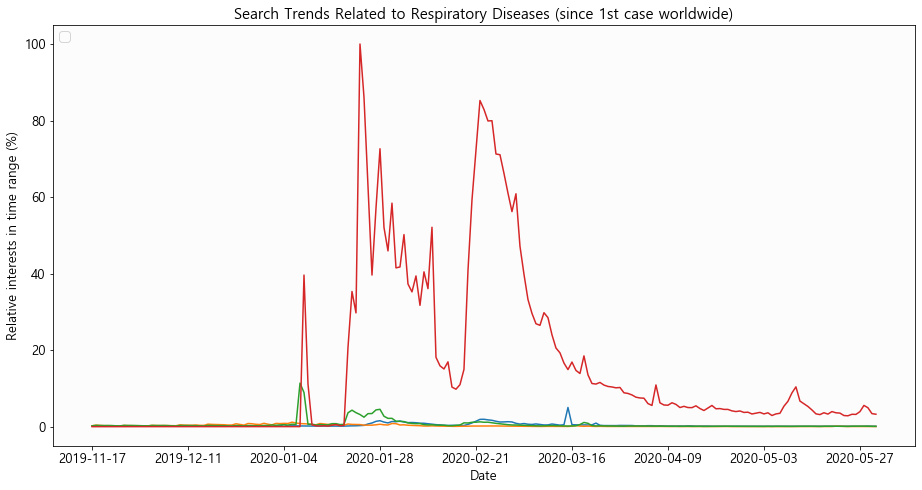

In [100]:
fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Search Trends Related to Respiratory Diseases (since 1st case worldwide)', size=15)
ax.set_xlabel('Date', size=13)
ax.set_ylabel('Relative interests in time range (%)', size=13)
for column in search_raw.columns[1:]:
    plt.plot(search_raw.date[search_raw.date >= '2019-11-17']
             , search_raw[search_raw.date >= '2019-11-17'][column])
ax.set_xticks(ax.get_xticks()[::int(len(search_raw.date[search_raw.date >= '2019-11-17'])/8)])
ax.legend(loc='upper left')
plt.show()

No handles with labels found to put in legend.


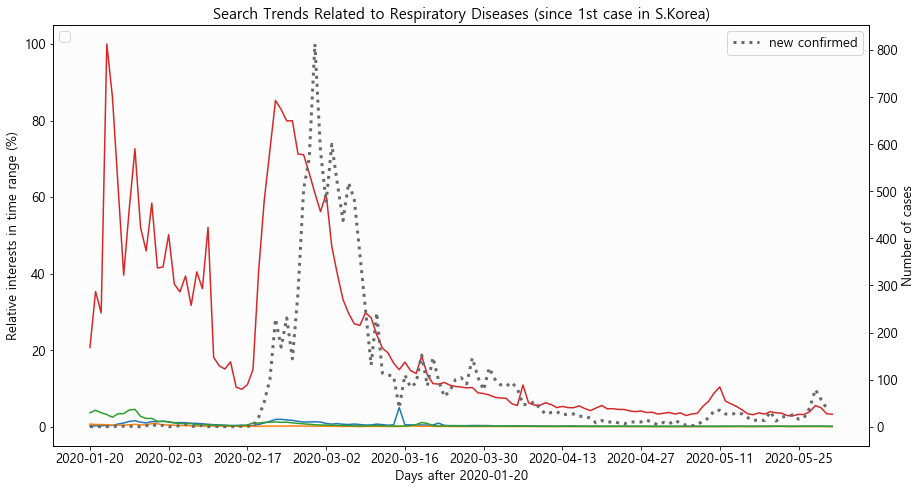

In [101]:
# search trends after 1st case in S.Korea
fig, ax1 = plt.subplots(figsize=(13, 7))
plt.title('Search Trends Related to Respiratory Diseases (since 1st case in S.Korea)', size=15)
ax1.set_xlabel('Days after 2020-01-20', size=13)
ax1.set_ylabel('Relative interests in time range (%)', size=13)
for column in search_raw.columns[1:]:
    ax1.plot(search_raw[search_raw.date >= '2020-01-20'].date
             , search_raw[search_raw.date >= '2020-01-20'][column])
ax1.set_xticks(ax1.get_xticks()[::14])
ax1.legend(loc='upper left')
# daily new cases
ax2 = ax1.twinx()
ax2.grid(False)
ax2.set_ylabel("Number of cases", size=13)
ax2.plot(test_raw.date[:-1]
         , test_raw.new_confirmed[:-1]
         , label='new confirmed', color='dimgray', ls=':', lw=3)
ax2.set_xticks(ax2.get_xticks()[::14])
ax2.legend(loc='upper right')

plt.show()

In [102]:
policy_raw = pd.read_csv(file_paths[11])
display(policy_raw.head(3).append(policy_raw.tail(3)))
data_col = pd.to_datetime(policy_raw['start_date']).dt.date
date_range = (max(data_col) - min(data_col)).days + 1
print(f'Date range: {date_range} days')
print(f'# {min(data_col)} to {max(data_col)}')

policy_id country            type                      gov_policy  \
0           1   Korea           Alert  Infectious Disease Alert Level   
1           2   Korea           Alert  Infectious Disease Alert Level   
2           3   Korea           Alert  Infectious Disease Alert Level   
55         56   Korea  Transformation                Logistics center   
56         57   Korea  Transformation                Wearing of masks   
57         58   Korea  Transformation                Wearing of masks   

                                               detail  start_date    end_date  
0                                      Level 1 (Blue)  2020-01-03  2020-01-19  
1                                    Level 2 (Yellow)  2020-01-20  2020-01-27  
2                                    Level 3 (Orange)  2020-01-28  2020-02-22  
55  On-site inspection of major logistics faciliti...  2020-05-29  2020-06-11  
56  Mandatory wearing of passenger mask domestic, ...  2020-05-27         NaN  
57  Drivers such as buses and taxis can refuse to ...  2020-05-26         NaN

Date range: 148 days
# 2020-01-03 to 2020-05-29


In [103]:
print(f'[Null values]\n{policy_raw.isna().sum()}')

[Null values]
policy_id      0
country        0
type           0
gov_policy     0
detail         2
start_date     0
end_date      35
dtype: int64


In [104]:
print('[Redundancy check]')
print('Is policy_id just index + 1?')
print(f'# {(policy_raw.index + 1 == policy_raw.policy_id).all()}')
print('Unique countries in \'country\' column:')
print(f'# {policy_raw.country.unique()[0]}')

[Redundancy check]
Is policy_id just index + 1?
# True
Unique countries in 'country' column:
# Korea


In [105]:
if ( sum(policy_raw.index+1==policy_raw.policy_id) == len(policy_raw) 
   ) and ( len(policy_raw.country.unique()) == 1 ):
    policy_compact = policy_raw.iloc[:, 2:]
print('[Sample data - compact version]')
display(policy_compact.tail(3))
print('[Basic numbers]')
display(policy_compact.describe())

[Sample data - compact version]


type        gov_policy  \
55  Transformation  Logistics center   
56  Transformation  Wearing of masks   
57  Transformation  Wearing of masks   

                                               detail  start_date    end_date  
55  On-site inspection of major logistics faciliti...  2020-05-29  2020-06-11  
56  Mandatory wearing of passenger mask domestic, ...  2020-05-27         NaN  
57  Drivers such as buses and taxis can refuse to ...  2020-05-26         NaN

[Basic numbers]


type                     gov_policy  detail  start_date  \
count            58                             58      56          58   
unique            8                             22      54          32   
top     Immigration  Special Immigration Procedure  Strong  2020-04-16   
freq             15                             13       2           7   

          end_date  
count           23  
unique          13  
top     2020-06-03  
freq             5

[Policy type distribution]
Immigration       15
Education         15
Health             9
Technology         5
Social             4
Alert              4
Transformation     3
Administrative     3
Name: type, dtype: int64


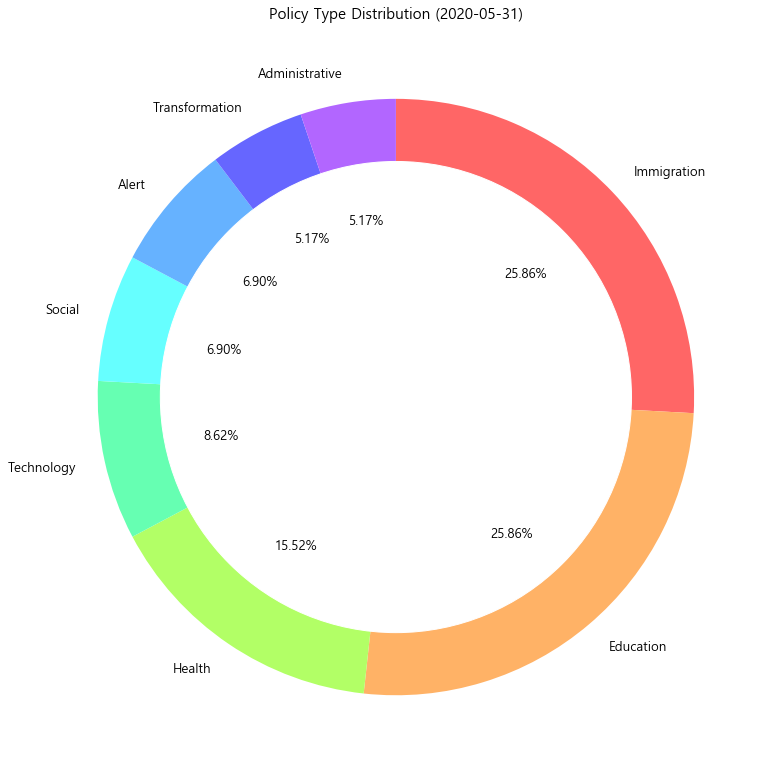

In [106]:
print('[Policy type distribution]')
print(policy_compact.type.value_counts())

# Distribution Graph
fig, ax = plt.subplots(figsize=(11, 11))
plt.title(f'Policy Type Distribution ({last_update})', fontsize=15)
colors=color_list
pop_circle = plt.Circle((0,0), 0.79, color='white')
plt.pie(policy_compact.type.value_counts()
        , labels = policy_compact.type.value_counts().index
        , autopct = '%.2f%%'
        , colors = colors
        , startangle = 90
        , counterclock = False)
p=plt.gcf()
p.gca().add_artist(pop_circle)
plt.show()

[Policy title distribution]
Special Immigration Procedure                    13
School Opening with Online Class                 10
Emergency Use Authorization of Diagnostic Kit     5
Infectious Disease Alert Level                    4
School Opening Delay                              4
Social Distancing Campaign                        3
Mask Distribution                                 2
Drive-Through Screening Center                    2
Wearing of masks                                  2
Self-Diagnosis App                                1
Close bars and clubs                              1
Mandatory Self-Quarantine & Diagonostic Tests     1
Open API                                          1
Electronic Wristbands                             1
School Closure                                    1
Mandatory 14-day Self-Quarantine                  1
Close karaoke                                     1
Logistics center                                  1
Self-Quarantine Safety Protection Ap

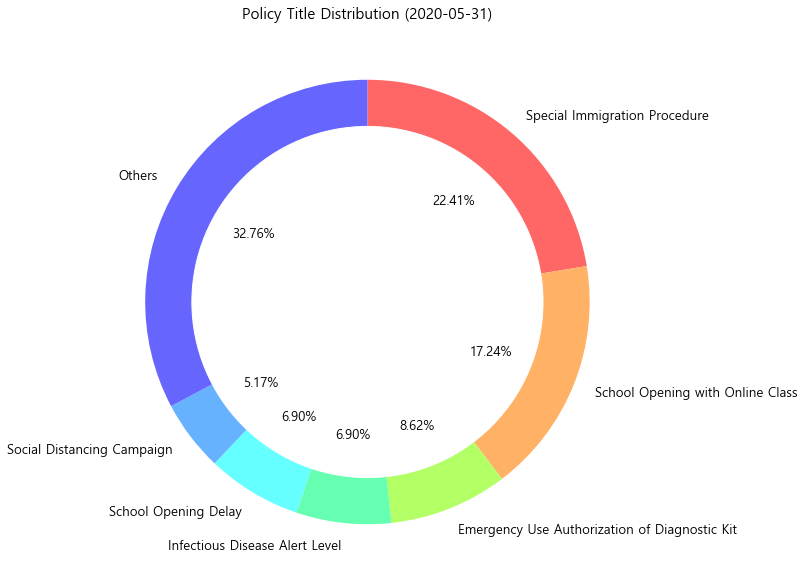

In [107]:
print('[Policy title distribution]')
print(policy_compact.gov_policy.value_counts())

# Put others than top 6 into others
policy_titles = pd.DataFrame(policy_compact.gov_policy.value_counts().items(), columns=['title', 'counts'])
policy_titles.loc[len(policy_titles), 'title'] = 'Others'
policy_titles.loc[len(policy_titles)-1, 'counts'] = policy_titles.iloc[6:, 1].sum()
policy_titles = pd.concat([policy_titles[:6], policy_titles[-1:]])

# Distribution Graph
fig, ax = plt.subplots(figsize=(11, 11))
colors=color_list
plt.title(f'Policy Title Distribution ({last_update})', fontsize=15)
pop_circle = plt.Circle((0,0), 0.79, color='white')
plt.pie(policy_titles['counts']
        , labels = policy_titles['title']
        , autopct = '%.2f%%'
        , colors = colors
        , startangle = 90
        , counterclock = False)
p=plt.gcf()
p.gca().add_artist(pop_circle)
plt.show()

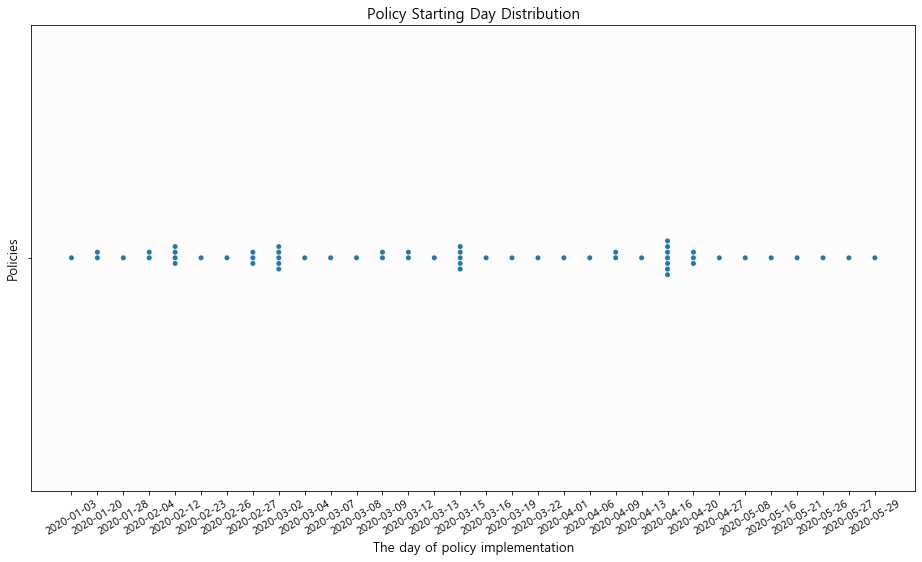

In [108]:
plt.title('Policy Starting Day Distribution', size=15)
sns.swarmplot(policy_compact.start_date)
plt.xticks(rotation=31, size=11)
plt.xlabel('The day of policy implementation', size=13)
plt.ylabel('Policies', size=13)
plt.show()

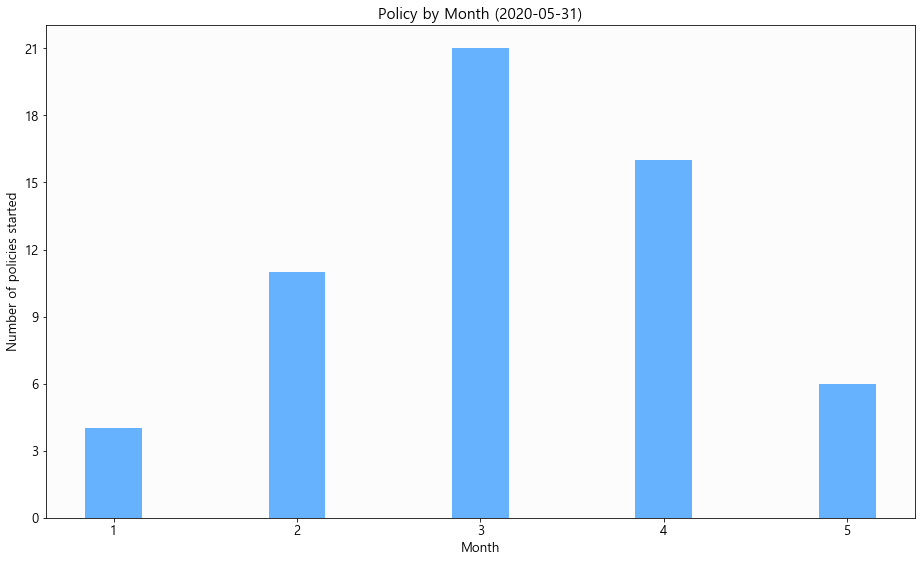

In [109]:
policy_by_day = pd.DataFrame(policy_raw.groupby('start_date').count().gov_policy)
policy_by_day['month'] = [ int(policy_by_day.index[i][6:7]) for i in range(len(policy_by_day)) ]
policy_by_month = policy_by_day.groupby('month').sum()
plt.title(f'Policy by Month ({last_update})', size=15)
# sns.barplot(policy_by_month.index
#             , policy_by_month.gov_policy)
plt.bar(policy_by_month.index
        , policy_by_month.gov_policy
        , width=0.31
        , color=color_list[5])
plt.xlabel('Month', size=13)
plt.ylabel('Number of policies started', size=13)
plt.yticks(np.arange(0, max(policy_by_month.gov_policy)+1, 3))
# plt.tight_layout()
plt.show()

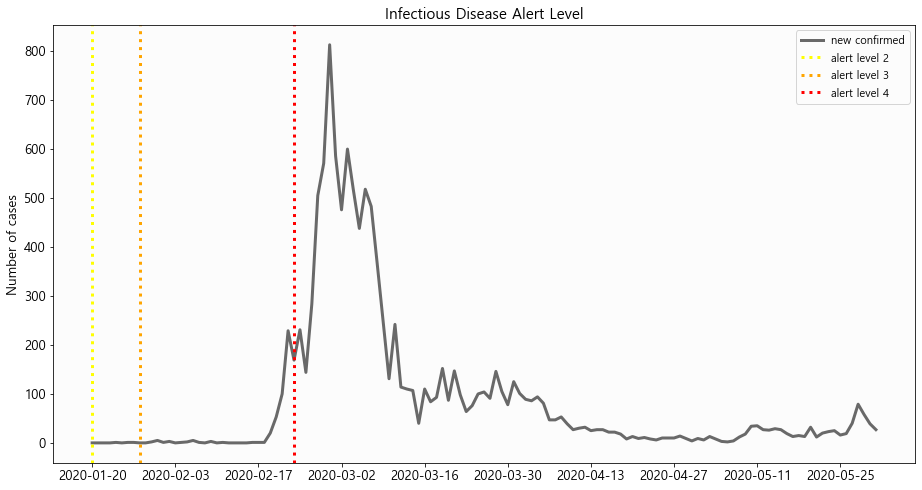

In [110]:
policy_alerts = policy_compact[ policy_compact.type == 'Alert' ]
fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Infectious Disease Alert Level', size=15)
plt.plot(test_raw.date.unique(), test_raw.new_confirmed
         , color='dimgray'
         , lw=3)
ax.set_xticks(ax.get_xticks()[::14])
for day, color in zip(policy_alerts.start_date.values[1:], ['yellow', 'orange', 'red']):
    ax.axvline(day, ls=':', color=color, lw=3)
ax.legend(['new confirmed', 'alert level 2', 'alert level 3', 'alert level 4'], fontsize=11)
plt.ylabel('Number of cases')
plt.show()

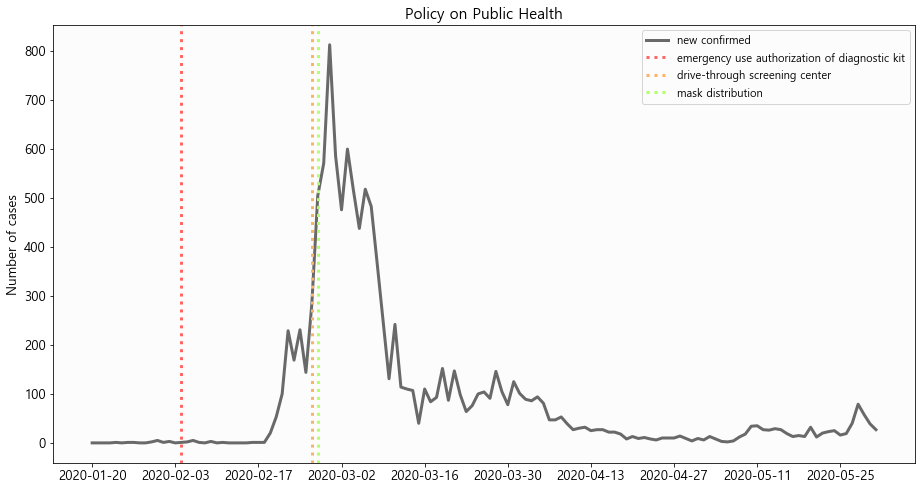

In [111]:
## 1. Get the first implemented health policies by type and title
first_policy = { i[1].start_date.values[0]: i[0].lower() 
                for i in policy_raw[policy_raw.type=='Health'].groupby(['gov_policy']) }
first_policy = dict(sorted(first_policy.items()))

## 2. Plot starting dates
fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Policy on Public Health', size=15)
plt.plot(test_raw.date.unique(), test_raw.new_confirmed
         , color='dimgray', lw=3)
ax.set_xticks(ax.get_xticks()[::14])
for date, color in zip(first_policy.keys(), color_list[:4]):
    ax.axvline(date, ls=':', color=color, lw=3)
ax.legend(['new confirmed'] + list(first_policy.values())
          , fontsize=11, loc='upper right')
plt.ylabel('Number of cases')
plt.show()

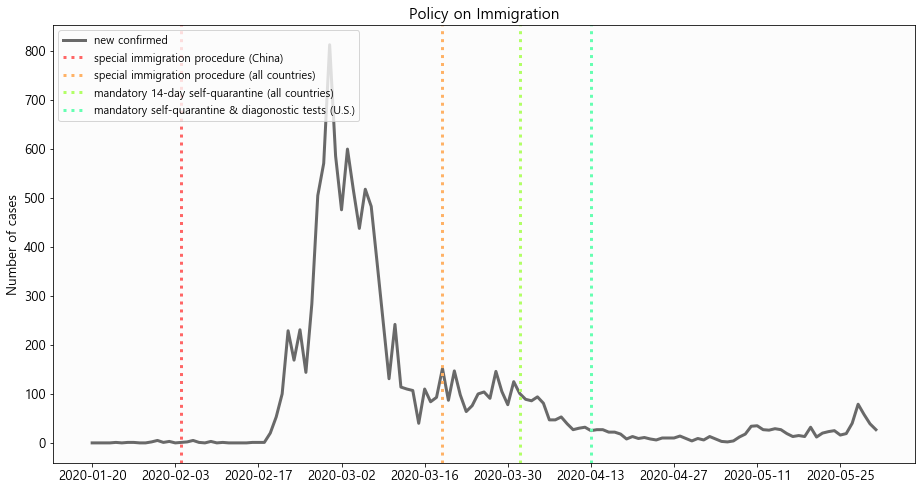

In [112]:
## 1. Get the oldest and recent policies on immigration
policy_immi = policy_raw[ policy_raw.type == 'Immigration' ].head(1).append(
              policy_raw[ policy_raw.type == 'Immigration' ].tail(3))
policy_list = list( map(add # 1) add policy titles + country names
                        , map( lambda x: x.lower() # 2) lower case policy titles
                              , policy_immi.gov_policy.values)
                        , map( lambda x: ' (' + x[5:].replace(' the', '') +')' # 3) simplify country names
                              , policy_immi.detail.values)
                       ) 
                  )

## 2. Plot starting dates
fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Policy on Immigration', size=15)
plt.plot(test_raw.date.unique(), test_raw.new_confirmed
         , color='dimgray'
         , lw=3)
ax.set_xticks(ax.get_xticks()[::14])
for day, color in zip(policy_immi.start_date.unique(), color_list[:4]):
    ax.axvline(day, ls=':', color=color, lw=3)
ax.legend(['new confirmed'] + policy_list, fontsize=11
           , loc='upper left')
plt.ylabel('Number of cases')
plt.show()

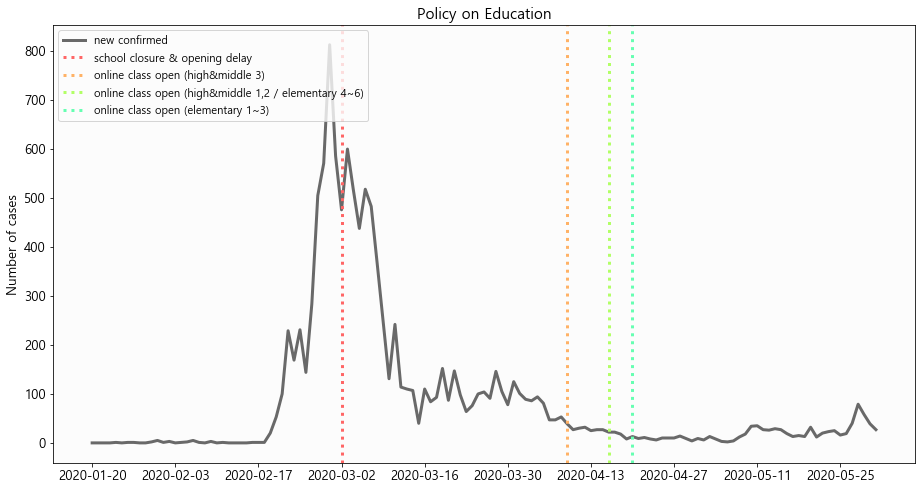

In [113]:
# Various education policies started on the sames days
    # thus we better handle this empirically than systematically
    # cause it's not generalizable to other use cases
policy_edu = policy_compact[ policy_compact.type == 'Education' ]
fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Policy on Education', size=15)
plt.plot(test_raw.date.unique(), test_raw.new_confirmed
         , color='dimgray'
         , lw=3)
ax.set_xticks(ax.get_xticks()[::14])
for day, color in zip(policy_edu.start_date.unique(), color_list[:4]):
    ax.axvline(day, ls=':', color=color, lw=3)
ax.legend(['new confirmed', 'school closure & opening delay'
           , 'online class open (high&middle 3)'
           , 'online class open (high&middle 1,2 / elementary 4~6)'
           , 'online class open (elementary 1~3)'], fontsize=11
           , loc='upper left')
plt.ylabel('Number of cases')
plt.show()

In [114]:
print('[Datasets we\'ve been through]')
[ i[:-4] for i in file_names ]

[Datasets we've been through]


['TimeAge',
 'TimeProvince',
 'Region',
 'TimeGender',
 'Time',
 'Case',
 'Weather',
 'PatientInfo',
 'PatientRoute',
 'SeoulFloating',
 'SearchTrend',
 'Policy']

In [115]:
age_0s = age_raw[age_raw['age'] == '0s']
age_10s = age_raw[age_raw['age'] == '10s']
age_20s = age_raw[age_raw['age'] == '20s']
age_30s = age_raw[age_raw['age'] == '30s']
age_40s = age_raw[age_raw['age'] == '40s']
age_50s = age_raw[age_raw['age'] == '50s']
age_60s = age_raw[age_raw['age'] == '60s']
age_70s = age_raw[age_raw['age'] == '70s']
age_80s = age_raw[age_raw['age'] == '80s']

In [116]:
def getTrainTest(data):
    X = data.index.factorize()[0].reshape(-1,1)
    y = data['confirmed'].values
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
    return X_train, X_test, y_train, y_test

In [117]:
def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred, average='weighted')
    recall = recall_score(y_test, pred, average='weighted')
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}'.format(accuracy, precision, recall))

In [118]:
def printMseRmse(y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    print('MSE: {0:.3f}, RMSE :{1:.3f}' .format(mse, rmse))
    print('Variance score : {0:.3f}' .format(r2_score(y_test,y_pred)))

In [119]:
def getLinearRegression(data):
    X_train, X_test, y_train, y_test = getTrainTest(data)
    lnr_clf = LinearRegression()
    lnr_clf.fit(X_train, y_train)
    lnr_clf.score(X_train, y_train)
    lnr_clf_pred = lnr_clf.predict(X_test)
    printMseRmse(y_test, lnr_clf_pred)
    return lnr_clf

In [120]:
def getLogisticRegression(data):
    X_train, X_test, y_train, y_test = getTrainTest(data)
    lgr_clf = LogisticRegression()
    lgr_clf.fit(X_train, y_train)
    lgr_clf.score(X_train, y_train)
    lgr_clf_pred = lgr_clf.predict(X_test)
    printMseRmse(y_test, lgr_clf_pred)
    get_clf_eval(y_test, lgr_clf_pred)
    return lgr_clf

In [121]:
def getLrKnnClassifier(data, lgr_clf, knn_clf):
    X_train, X_test, y_train, y_test = getTrainTest(data)
    lgr_clf = LogisticRegression()
    lgr_clf._estimator_type = "classifier"
    vo_clf = VotingClassifier(estimators=[('lr', lgr_clf), ('knn', knn_clf)], voting='soft')
    vo_clf.fit(X_train, y_train)
    vo_clf_pred = vo_clf.predict(X_test)
    get_clf_eval(y_test, vo_clf_pred)
    return vo_clf

In [122]:
def getKNeighborsClassifier(data, n_neighbors):
    X_train, X_test, y_train, y_test = getTrainTest(data)
    knn_clf = KNeighborsClassifier(n_neighbors)
    knn_clf.fit(X_train, y_train)
    knn_clf_pred = knn_clf.predict(X_test)
    get_clf_eval(y_test, knn_clf_pred)
    return knn_clf

In [123]:
def getRidgeRegression(data):
    X_train, X_test, y_train, y_test = getTrainTest(data)
    # 릿지에 사용될 alpha 파라미터의 값을 정의
    regr_cv = RidgeCV(cv=5, alphas = [0.1, 1, 10, 100])
    model_cv = regr_cv.fit(X_train, y_train)
    ridge = Ridge(model_cv.alpha_)
    ridge.fit(X_train, y_train)
    return ridge

In [124]:
def getLassoRegression(data):
    X_train, X_test, y_train, y_test = getTrainTest(data)
    regr_cv = LassoCV(cv=5, alphas = [0.1, 1, 10, 100])
    model_cv = regr_cv.fit(X_train, y_train)
    lasso = Lasso(model_cv.alpha_)
    lasso.fit(X_train, y_train)
    return lasso

In [125]:
def getElasticNetRegression(data):
    X_train, X_test, y_train, y_test = getTrainTest(data)
    regr_cv = ElasticNetCV(cv=5, l1_ratio = [.1, .5, .7, .9, .95, .99, 1],alphas = [0.1, 1, 10, 100])
    model_cv = regr_cv.fit(X_train, y_train)
    elastic = ElasticNet(alpha = model_cv.alpha_,
                        l1_ratio = model_cv.l1_ratio_)
    elastic.fit(X_train, y_train)
    return elastic

In [126]:
def getLinearSVR(data):
    X_train, X_test, y_train, y_test = getTrainTest(data)
    lnr_svr = LinearSVR(random_state=0)
    lnr_svr.fit(X_train, y_train)
    y_pred = lnr_svr.predict(X_test)
    printMseRmse(y_test, y_pred)
    return lnr_svr

In [151]:
def getRandomForestClassifier(data):
    params = {
        'n_estimators' : [100, 200, 300],
        'max_depth' : [6, 8, 10, 12],
        'min_samples_leaf' : [8, 12, 18],
        'min_samples_split' : [8, 16, 20]
    }
    X_train, X_test, y_train, y_test = getTrainTest(data)
    rf_clf = RandomForestClassifier(random_state=0, n_jobs=-1)
    rf_grid_cv = GridSearchCV(rf_clf, param_grid=params, cv=2, n_jobs=-1)
    rf_grid_cv.fit(X_train, y_train)

    print('최적 하이퍼 파라미터:\n' ,rf_grid_cv.best_params_)
    print('최고 예측 정확도: {0:.4f}' .format(rf_grid_cv.best_score_))
    rf_clf = rf_grid_cv.best_estimator_
    return rf_clf

In [157]:
def getAdaBoostClassifier(data):
    params = {
        'learning_rate': [0.1, 0.2, 0.3, 0.5, 0.9, 1],
        'n_estimators' : [10,20,30,50,100, 200, 300],
    }
    X_train, X_test, y_train, y_test = getTrainTest(data)
    ada_clf = AdaBoostClassifier(random_state=0)
    ada_grid_cv = GridSearchCV(ada_clf, param_grid=params, cv=2, n_jobs=-1)
    ada_grid_cv.fit(X_train, y_train)
    print('최적 하이퍼 파라미터:\n' ,ada_grid_cv.best_params_)
    print('최고 예측 정확도: {0:.4f}' .format(ada_grid_cv.best_score_))
    ada_clf = ada_grid_cv.best_estimator_
    ada_clf.fit(X_train, y_train)
    return ada_clf

In [158]:
def getGradientBoostingClassifier(data):
    params = {
        'n_estimators' : [10, 20, 50, 100],
        'learning_rate' : [0.1, 0.3, 0.5, 0.7, 1],
        'max_depth' : [6, 8, 10 ],
        'min_samples_leaf' : [4, 8, 12 ],
        'min_samples_split' : [4 ,8, 16 ]
    }
    X_train, X_test, y_train, y_test = getTrainTest(data)
    gbm_clf = GradientBoostingClassifier(random_state=0)
    gbm_grid_cv = GridSearchCV(gbm_clf, param_grid=params, cv=2, n_jobs=-1)
    gbm_grid_cv.fit(X_train, y_train)
    print('최적 하이퍼 파라미터:\n' ,gbm_grid_cv.best_params_)
    print('최고 예측 정확도: {0:.4f}' .format(gbm_grid_cv.best_score_))
    gbm_clf = gbm_grid_cv.best_estimator_
    gbm_clf.fit(X_train, y_train)
    return gbm_clf

In [130]:
# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds):
    # 지정된 n_folds값으로 KFold 생성
    kf = KFold(n_splits=n_folds, shuffle=False, random_state=0)
    # 추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화
    train_fold_pred = np.zeros((X_train_n.shape[0], 1))
    test_pred = np.zeros((X_test_n.shape[0], n_folds))
    print(model.__class__.__name__, ' model 시작 ')
    
    for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        # 입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 세트 추출
        print('\t 폴드 세트: ', folder_counter, ' 시작 ')
        X_tr = X_train_n[train_index]
        y_tr = y_train_n[train_index]
        X_te = X_train_n[valid_index]
        
        # 폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행
        model.fit(X_tr, y_tr)
        # 폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장.
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1, 1)
        # 입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장
        test_pred[:, folder_counter] = model.predict(X_test_n)
        
    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1, 1)
    
    # train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred, test_pred_mean

In [131]:
def getStackingEsemble(data, knn_clf, rf_clf, lgr_clf, ada_clf):
    # 스테킹으로 만들어진 데이터 세트를 학습, 예측할 최종 모델
    lr_final = LogisticRegression(C=10)
    X_train, X_test, y_train, y_test = getTrainTest(data)
    knn_train, knn_test = get_stacking_base_datasets(knn_clf, X_train, y_train, X_test, 7)
    rf_train, rf_test = get_stacking_base_datasets(rf_clf, X_train, y_train, X_test, 7)
    lgr_train, lgr_test = get_stacking_base_datasets(lgr_clf, X_train, y_train, X_test, 7)
    ada_train, ada_test = get_stacking_base_datasets(ada_clf, X_train, y_train, X_test, 7)
    Stack_final_X_train = np.concatenate((knn_train, rf_train, lgr_train, ada_train), axis = 1)
    Stack_final_X_test = np.concatenate((knn_test, rf_test, lgr_test, ada_test), axis = 1)
    print('원본 학습 피처 데이터 shape:', X_train.shape, '원본 테스트 피처 shape', X_test.shape)
    print('스태킹 학습 피처 데이터 shape:', Stack_final_X_train.shape,
         '스태킹 테스트 피처 데이터 shape:', Stack_final_X_test.shape)
    lr_final.fit(Stack_final_X_train, y_train)
    stack_final = lr_final.predict(Stack_final_X_test)
    print('최종 메타 모델의 예츨 정확도: {0:.4f}'.format(accuracy_score(y_test, stack_final)))
    return lr_final

In [132]:
# 스테킹으로 만들어진 데이터 세트를 학습, 예측할 최종 모델
lr_final = LogisticRegression(C=10)

# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds):
    # 지정된 n_folds값으로 KFold 생성
    kf = KFold(n_splits=n_folds, shuffle=False, random_state=0)
    # 추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화
    train_fold_pred = np.zeros((X_train_n.shape[0], 1))
    test_pred = np.zeros((X_test_n.shape[0], n_folds))
    print(model.__class__.__name__, ' model 시작 ')
    
    for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        # 입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 세트 추출
        print('\t 폴드 세트: ', folder_counter, ' 시작 ')
        X_tr = X_train_n[train_index]
        y_tr = y_train_n[train_index]
        X_te = X_train_n[valid_index]
        
        # 폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행
        model.fit(X_tr, y_tr)
        # 폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장.
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1, 1)
        # 입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장
        test_pred[:, folder_counter] = model.predict(X_test_n)
        
    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1, 1)
    
    # train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred, test_pred_mean

In [133]:
def convertToMatrix(data, step):
    X, Y =[], []
    for i in range(len(data)-step):
        d=i+step  
        X.append(data[i:d,])
        Y.append(data[d,])
    return np.array(X), np.array(Y)

In [134]:
def getSimpleRnnTrainTestX(df, step, Tp, Predict):
    values=df.values
    train,test = values[0:Tp,:], values[Tp:Predict,:]
    test = np.append(test,np.repeat(test[-1,],step))
    train = np.append(train,np.repeat(train[-1,],step))
 
    trainX,trainY = convertToMatrix(train,step)
    testX,testY = convertToMatrix(test,step)
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    return trainX, testX, trainY, testY

In [135]:
def getSimpleRnn(data, step):
    X = data.index.factorize()[0].reshape(-1,1)
    y = data['confirmed'].values
    X_train, X_test, y_train, y_test = getTrainTest(data)
    N = len(X)    
    Tp = len(X_train)
    Predict = N + prediction_days
    x = np.zeros(Predict)
    x = x.astype(float)
    for i in range(Predict):
        if(i < len(y)):
            x[i] += y[i] 
        else:
            x[i] += y[len(y)-1]
            x += 2*np.random.rand(Predict)
    df = pd.DataFrame(x)
    
    trainX, testX, trainY, testY = getSimpleRnnTrainTestX(df, step, Tp , Predict)
    model = Sequential()
    model.add(SimpleRNN(units=32, input_shape=(1,step), activation="relu"))
    model.add(Dense(8, activation="relu")) 
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='rmsprop')
    model.summary()

    model.fit(trainX,trainY, epochs=100, batch_size=16, verbose=2)
    return model, df, trainX, testX

In [152]:
lnr_clf = None
lgr_clf = None
knn_clf = None
lrknn_clf = None
ridge = None
lasso = None
elastic = None
lnr_svr = None
rf_clf = None
ada_clf = None
gbm_clf = None
stack_esem = None
simple_rnn = None
clfs = []
clfs.append(lnr_clf)
clfs.append(lgr_clf)
clfs.append(knn_clf)
clfs.append(lrknn_clf)
clfs.append(ridge)
clfs.append(lasso)
clfs.append(elastic)
clfs.append(lnr_svr)
clfs.append(rf_clf)
clfs.append(ada_clf)
clfs.append(gbm_clf)
clfs.append(stack_esem)
clfs.append(simple_rnn)
clfs_list = []

In [153]:
prediction_days = 10
#len(X)
#lnr_predict_data = lnr_clf.predict(np.arange(len(X)-1,len(X)+prediction_days).reshape(-1,1))
#lnr_predict_date = np.arange(len(X)-1, len(X)+prediction_days)

In [205]:
def plot_draw_clfs(data, title_lists, title_index):
    clfs_list = []
    X = data.index.factorize()[0].reshape(-1,1)
    y = data['confirmed'].values
    X_train, X_test, y_train, y_test = getTrainTest(data)
    fig, ax = plt.subplots(figsize=(13, 7))
    plt.title('Cumulative Confirmed Cases ('+ title_lists[title_index]+')', fontsize=15)
    ax.set_xlabel('Date', size=13)
    ax.set_ylabel('Number of cases', size=13)
    plt.scatter(X, y,color=color_list[0])   
    predict_date = np.arange(len(X)-1, len(X)+prediction_days)
    for i, clf in enumerate(clfs):
        if i < len(clfs) - 2:
            if i == 0:
                clf = getLinearRegression(data)
            elif i == 1:
                clf = getLogisticRegression(data)
            elif i == 2:
                clf = getKNeighborsClassifier(data, 1)
            elif i == 3:
                clf = getLrKnnClassifier(data, clfs[1], clfs[2])
            elif i == 4:
                clf = getRidgeRegression(data)
            elif i == 5:
                clf = getLassoRegression(data)
            elif i == 6:
                clf = getElasticNetRegression(data)
            elif i == 7:
                clf = getLinearSVR(data)
            elif i == 8:
                clf = getRandomForestClassifier(data)
            elif i == 9:
                clf = getAdaBoostClassifier(data)
            elif i == 10:
                clf = getLinearRegression(data)
                #getGradientBoostingClassifier(data)
            clfs[i] = clf
            plt.plot( data.date.unique()
            , clf.predict(X), color=color_list[i])
            clfs_list.append(clf.__class__.__name__)
            predict_data = clf.predict(np.arange(len(X)-1,len(X)+prediction_days).reshape(-1,1))
            plt.plot(predict_date, predict_data, ".", color=color_list[i])
            clfs_list.append(clf.__class__.__name__+" predict")        
        elif i == len(clfs) -2: #stacking esemble 일 경우
            #print(clfs)
            clf = getStackingEsemble(data, clfs[2], clfs[8], clfs[1], clfs[9])
            Stack_final_X = np.concatenate((X, X, X, X), axis = 1)
            plt.plot(data.date.unique()
            , clf.predict(Stack_final_X), color=color_list[i])
            clfs_list.append(clf.__class__.__name__)
            predict_X = predict_date.reshape(-1,1)
            Stack_final_predict_X = np.concatenate((predict_X, predict_X, predict_X, predict_X), axis=1)
            predict_data = clf.predict(Stack_final_predict_X).reshape(-1, 1)
            plt.plot(predict_date, predict_data, ".", color=color_list[i])
            clfs_list.append(clf.__class__.__name__+" predict")
        elif i == len(clfs) -1: #simple rnn일 경우 
            simple_rnn, rnn_df, trainX, testX = getSimpleRnn(data, 4)
            trainPredict = simple_rnn.predict(trainX)
            testPredict= simple_rnn.predict(testX)
            index = rnn_df.index.values
            predicted = np.concatenate((trainPredict, testPredict), axis=0)
            plt.plot(index,predicted, color=color_list[i])
            clfs_list.append(simple_rnn.__class__.__name__+" predict")
    clfs_list.append(title_lists[title_index]+"s confirmed")
    print(clfs_list)
    ax.legend(clfs_list, fontsize=5
          , loc='lower right')
    ax.set_xticks(ax.get_xticks()[::13])
    plt.show()

In [184]:
age_0s_df = pd.DataFrame({'date':age_0s['date'], 'confirmed':age_0s['confirmed']})
age_10s_df = pd.DataFrame({'date':age_10s['date'], 'confirmed':age_10s['confirmed']})
age_20s_df = pd.DataFrame({'date':age_20s['date'], 'confirmed':age_20s['confirmed']})
age_30s_df = pd.DataFrame({'date':age_30s['date'], 'confirmed':age_30s['confirmed']})
age_40s_df = pd.DataFrame({'date':age_40s['date'], 'confirmed':age_40s['confirmed']})
age_50s_df = pd.DataFrame({'date':age_50s['date'], 'confirmed':age_50s['confirmed']})
age_60s_df = pd.DataFrame({'date':age_60s['date'], 'confirmed':age_60s['confirmed']})
age_70s_df = pd.DataFrame({'date':age_70s['date'], 'confirmed':age_70s['confirmed']})
age_80s_df = pd.DataFrame({'date':age_80s['date'], 'confirmed':age_80s['confirmed']})
age_df_lists = []
age_df_lists.append(age_0s_df)
age_df_lists.append(age_10s_df)
age_df_lists.append(age_20s_df)
age_df_lists.append(age_30s_df)
age_df_lists.append(age_40s_df)
age_df_lists.append(age_50s_df)
age_df_lists.append(age_60s_df)
age_df_lists.append(age_70s_df)
age_df_lists.append(age_80s_df)
age_title_lists = []
age_title_lists.append("0s")
age_title_lists.append("10s")
age_title_lists.append("20s")
age_title_lists.append("30s")
age_title_lists.append("40s")
age_title_lists.append("50s")
age_title_lists.append("60s")
age_title_lists.append("70s")
age_title_lists.append("80s")

MSE: 231.758, RMSE :15.224
Variance score : 0.798
MSE: 623.211, RMSE :24.964
Variance score : 0.456
오차 행렬
[[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]]
정확도: 0.1579, 정밀도: 0.0789, 재현율: 0.

Epoch 59/100
 - 0s - loss: 16.5121
Epoch 60/100
 - 0s - loss: 26.4866
Epoch 61/100
 - 0s - loss: 23.0857
Epoch 62/100
 - 0s - loss: 18.2352
Epoch 63/100
 - 0s - loss: 23.2478
Epoch 64/100
 - 0s - loss: 16.0793
Epoch 65/100
 - 0s - loss: 23.5977
Epoch 66/100
 - 0s - loss: 15.0610
Epoch 67/100
 - 0s - loss: 17.2497
Epoch 68/100
 - 0s - loss: 23.9309
Epoch 69/100
 - 0s - loss: 17.4252
Epoch 70/100
 - 0s - loss: 16.1517
Epoch 71/100
 - 0s - loss: 21.6045
Epoch 72/100
 - 0s - loss: 13.5040
Epoch 73/100
 - 0s - loss: 31.9220
Epoch 74/100
 - 0s - loss: 14.5482
Epoch 75/100
 - 0s - loss: 14.9968
Epoch 76/100
 - 0s - loss: 14.6507
Epoch 77/100
 - 0s - loss: 26.4441
Epoch 78/100
 - 0s - loss: 14.4688
Epoch 79/100
 - 0s - loss: 16.3431
Epoch 80/100
 - 0s - loss: 20.1243
Epoch 81/100
 - 0s - loss: 14.3234
Epoch 82/100
 - 0s - loss: 23.7054
Epoch 83/100
 - 0s - loss: 18.7456
Epoch 84/100
 - 0s - loss: 21.0955
Epoch 85/100
 - 0s - loss: 22.6291
Epoch 86/100
 - 0s - loss: 15.6799
Epoch 87/100
 - 0s -

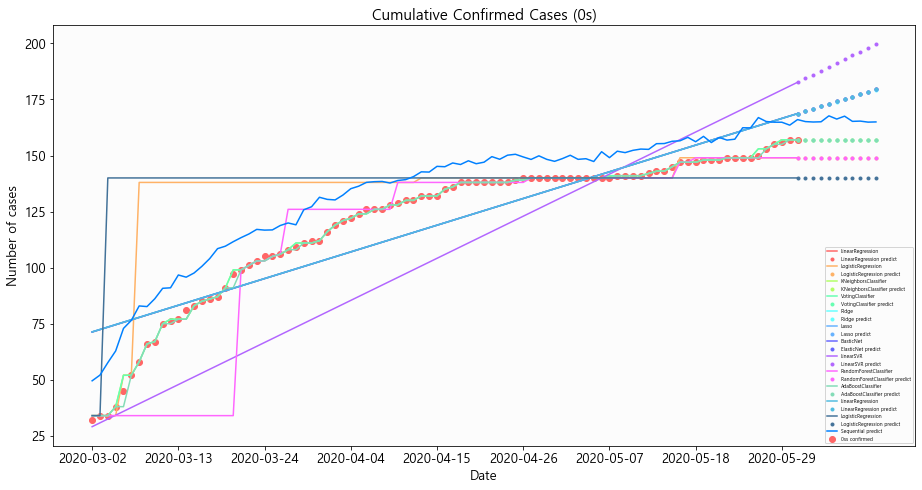

MSE: 3531.025, RMSE :59.422
Variance score : 0.744
MSE: 2770.789, RMSE :52.638
Variance score : 0.799
오차 행렬
[[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 

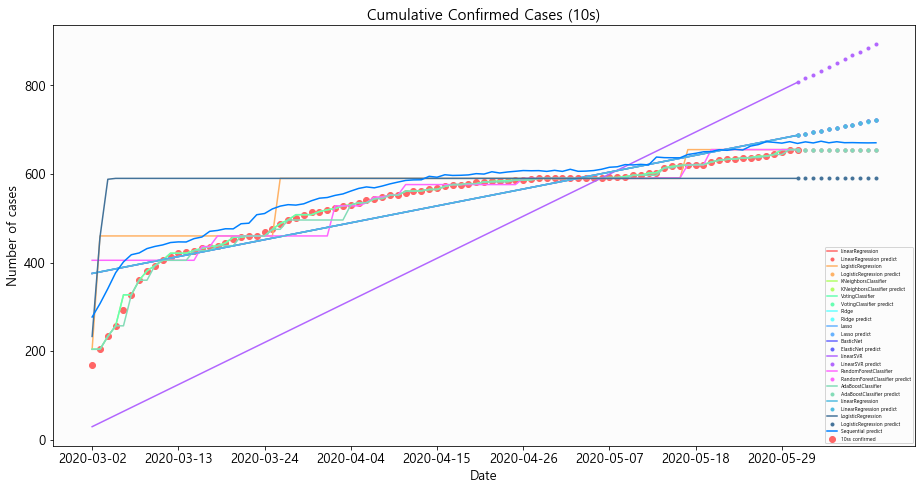

MSE: 59979.490, RMSE :244.907
Variance score : 0.726
MSE: 25423.947, RMSE :159.449
Variance score : 0.884
오차 행렬
[[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0

['LinearRegression', 'LinearRegression predict', 'LogisticRegression', 'LogisticRegression predict', 'KNeighborsClassifier', 'KNeighborsClassifier predict', 'VotingClassifier', 'VotingClassifier predict', 'Ridge', 'Ridge predict', 'Lasso', 'Lasso predict', 'ElasticNet', 'ElasticNet predict', 'LinearSVR', 'LinearSVR predict', 'RandomForestClassifier', 'RandomForestClassifier predict', 'AdaBoostClassifier', 'AdaBoostClassifier predict', 'LinearRegression', 'LinearRegression predict', 'LogisticRegression', 'LogisticRegression predict', 'Sequential predict', '20ss confirmed']


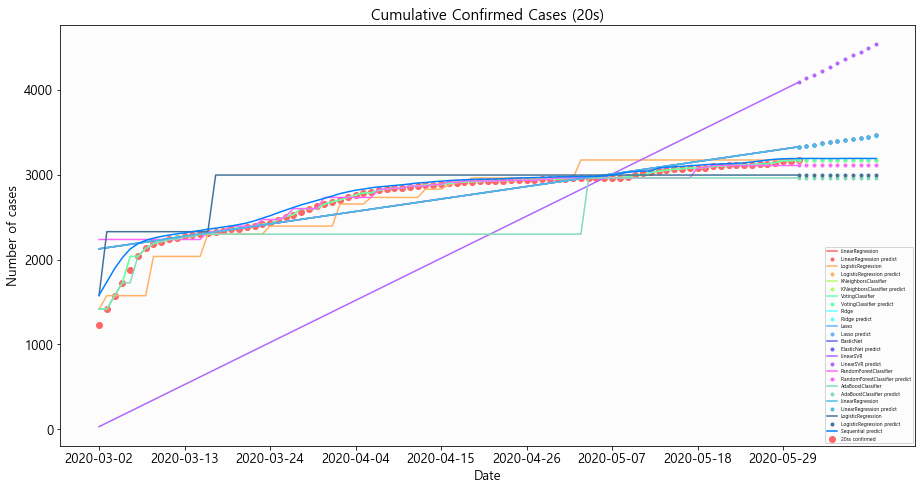

MSE: 7146.311, RMSE :84.536
Variance score : 0.814
MSE: 3952.526, RMSE :62.869
Variance score : 0.897
오차 행렬
[[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 

['LinearRegression', 'LinearRegression predict', 'LogisticRegression', 'LogisticRegression predict', 'KNeighborsClassifier', 'KNeighborsClassifier predict', 'VotingClassifier', 'VotingClassifier predict', 'Ridge', 'Ridge predict', 'Lasso', 'Lasso predict', 'ElasticNet', 'ElasticNet predict', 'LinearSVR', 'LinearSVR predict', 'RandomForestClassifier', 'RandomForestClassifier predict', 'AdaBoostClassifier', 'AdaBoostClassifier predict', 'LinearRegression', 'LinearRegression predict', 'LogisticRegression', 'LogisticRegression predict', 'Sequential predict', '30ss confirmed']


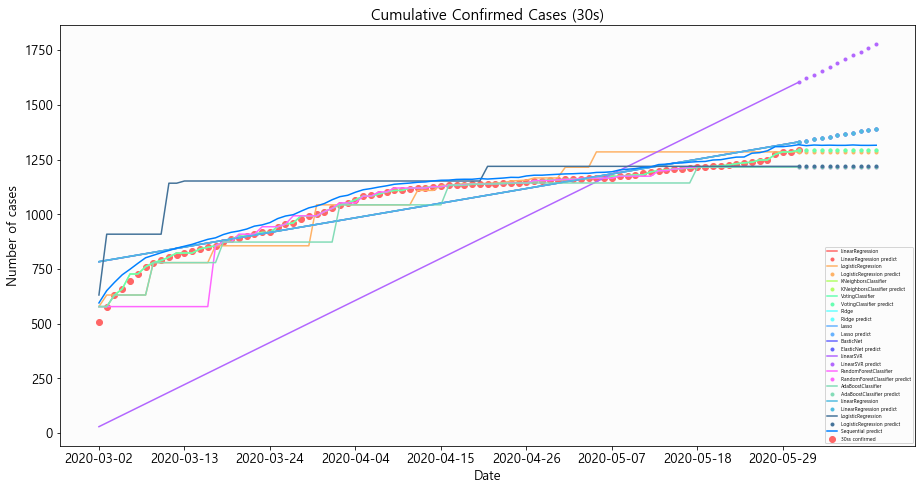

MSE: 15242.097, RMSE :123.459
Variance score : 0.677
MSE: 2061.895, RMSE :45.408
Variance score : 0.956
오차 행렬
[[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

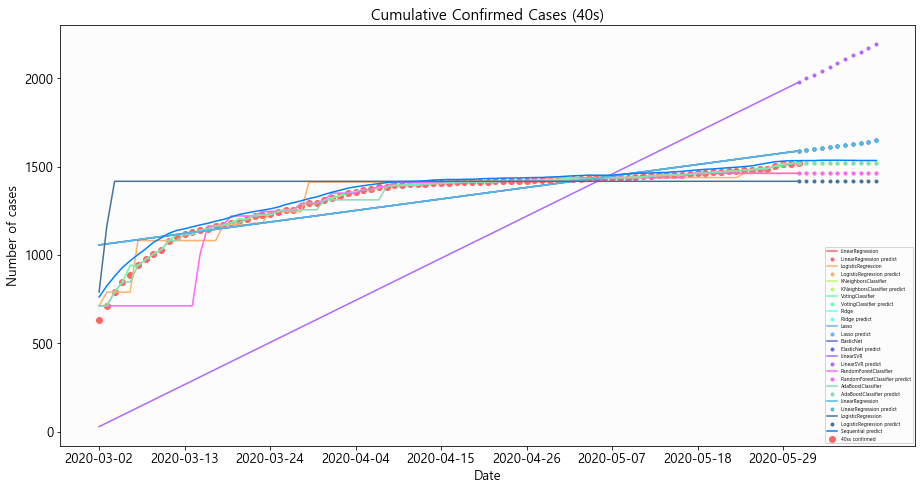

MSE: 35177.661, RMSE :187.557
Variance score : 0.607
MSE: 4886.684, RMSE :69.905
Variance score : 0.945
오차 행렬
[[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0

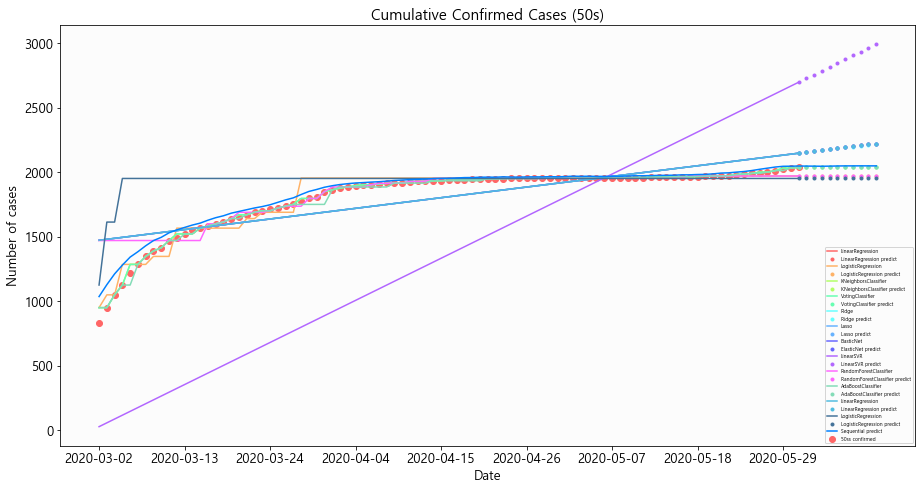

MSE: 18044.081, RMSE :134.328
Variance score : 0.653
MSE: 7861.105, RMSE :88.663
Variance score : 0.849
오차 행렬
[[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0

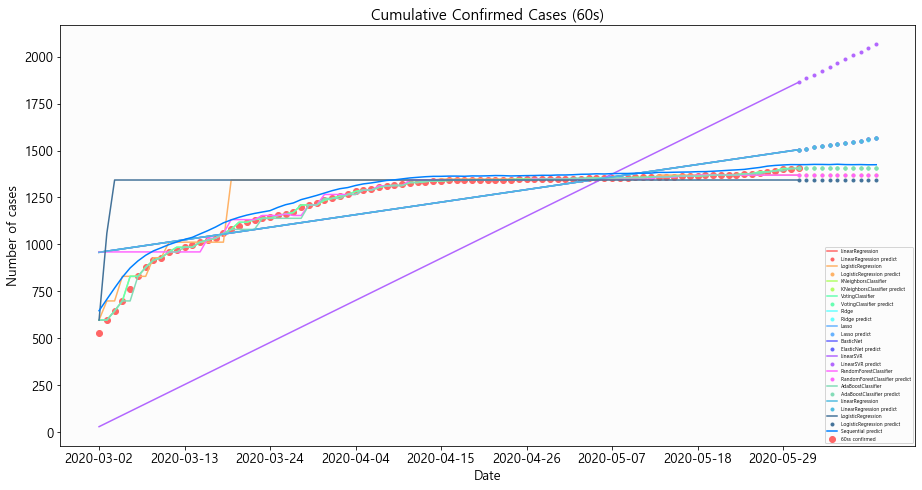

MSE: 8002.641, RMSE :89.457
Variance score : 0.593
MSE: 7156.526, RMSE :84.596
Variance score : 0.636
오차 행렬
[[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1

Epoch 48/100
 - 0s - loss: 517.8900
Epoch 49/100
 - 0s - loss: 474.8651
Epoch 50/100
 - 0s - loss: 500.8266
Epoch 51/100
 - 0s - loss: 431.0696
Epoch 52/100
 - 0s - loss: 453.9787
Epoch 53/100
 - 0s - loss: 464.8658
Epoch 54/100
 - 0s - loss: 418.6693
Epoch 55/100
 - 0s - loss: 438.1397
Epoch 56/100
 - 0s - loss: 436.8891
Epoch 57/100
 - 0s - loss: 410.9806
Epoch 58/100
 - 0s - loss: 391.3338
Epoch 59/100
 - 0s - loss: 380.3840
Epoch 60/100
 - 0s - loss: 452.0490
Epoch 61/100
 - 0s - loss: 391.1985
Epoch 62/100
 - 0s - loss: 403.3265
Epoch 63/100
 - 0s - loss: 446.2995
Epoch 64/100
 - 0s - loss: 502.6594
Epoch 65/100
 - 0s - loss: 392.6527
Epoch 66/100
 - 0s - loss: 374.5074
Epoch 67/100
 - 0s - loss: 360.6194
Epoch 68/100
 - 0s - loss: 469.4917
Epoch 69/100
 - 0s - loss: 357.5454
Epoch 70/100
 - 0s - loss: 366.8987
Epoch 71/100
 - 0s - loss: 367.5626
Epoch 72/100
 - 0s - loss: 461.2021
Epoch 73/100
 - 0s - loss: 338.4937
Epoch 74/100
 - 0s - loss: 361.8880
Epoch 75/100
 - 0s - loss: 3

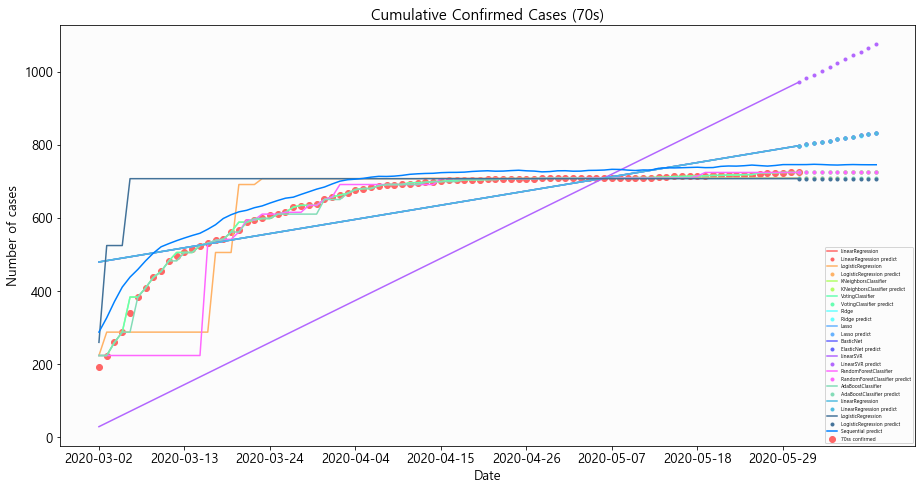

MSE: 5390.541, RMSE :73.420
Variance score : 0.637
MSE: 2078.842, RMSE :45.594
Variance score : 0.860
오차 행렬
[[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

Epoch 48/100
 - 0s - loss: 258.5701
Epoch 49/100
 - 0s - loss: 289.7358
Epoch 50/100
 - 0s - loss: 314.0851
Epoch 51/100
 - 0s - loss: 270.8261
Epoch 52/100
 - 0s - loss: 252.5308
Epoch 53/100
 - 0s - loss: 266.5371
Epoch 54/100
 - 0s - loss: 271.6912
Epoch 55/100
 - 0s - loss: 298.0191
Epoch 56/100
 - 0s - loss: 260.2364
Epoch 57/100
 - 0s - loss: 252.4979
Epoch 58/100
 - 0s - loss: 281.0379
Epoch 59/100
 - 0s - loss: 288.4575
Epoch 60/100
 - 0s - loss: 243.7078
Epoch 61/100
 - 0s - loss: 252.5071
Epoch 62/100
 - 0s - loss: 298.8324
Epoch 63/100
 - 0s - loss: 247.0733
Epoch 64/100
 - 0s - loss: 256.6886
Epoch 65/100
 - 0s - loss: 239.0749
Epoch 66/100
 - 0s - loss: 229.6733
Epoch 67/100
 - 0s - loss: 311.1274
Epoch 68/100
 - 0s - loss: 252.9312
Epoch 69/100
 - 0s - loss: 230.7533
Epoch 70/100
 - 0s - loss: 273.5598
Epoch 71/100
 - 0s - loss: 255.6703
Epoch 72/100
 - 0s - loss: 232.1160
Epoch 73/100
 - 0s - loss: 231.5918
Epoch 74/100
 - 0s - loss: 303.9950
Epoch 75/100
 - 0s - loss: 2

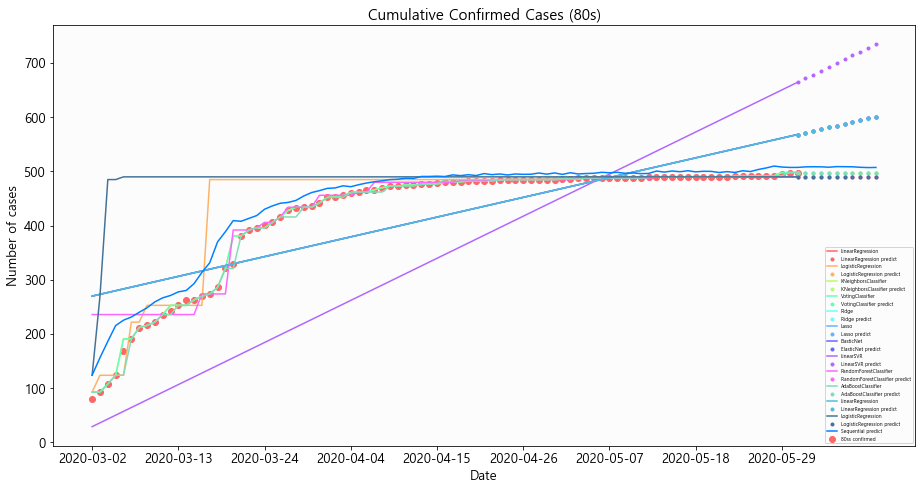

In [185]:
for i, age_df in enumerate(age_df_lists):
    clfs_list = []
    plot_draw_clfs(age_df, age_title_lists, i)

In [230]:
# location list by order of confirmed cases (based on latest data)
loc_list = location_raw[location_raw.date==location_raw.date.iloc[-1]]\
            .sort_values('confirmed', ascending = False)\
            .province.unique()

In [231]:
#age_0s = age_raw[age_raw['age'] == '0s
#age_0s_df = pd.DataFrame({'date':age_0s['date'], 'confirmed':age_0s['confirmed']})
loc_list
loc_confirm_dfs = [] 
for loc_name in loc_list:
    loc_raw = location_raw[location_raw.province==loc_name]
    loc_confirm_dfs.append(pd.DataFrame({'date':loc_raw['date'], 'confirmed':loc_raw['confirmed']}))

MSE: 2165156.671, RMSE :1471.447
Variance score : 0.776
MSE: 561324.259, RMSE :749.216
Variance score : 0.942
오차 행렬
[[9 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 

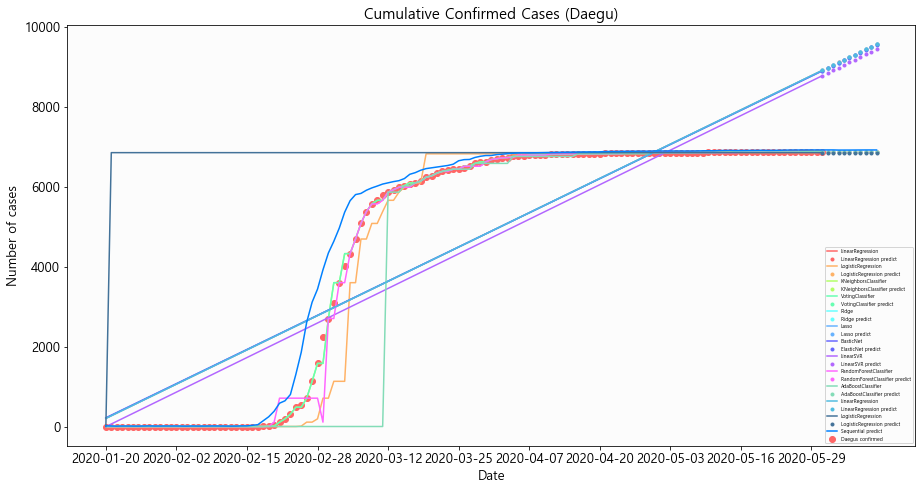

MSE: 76211.803, RMSE :276.065
Variance score : 0.793
MSE: 29307.370, RMSE :171.194
Variance score : 0.920
오차 행렬
[[9 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0

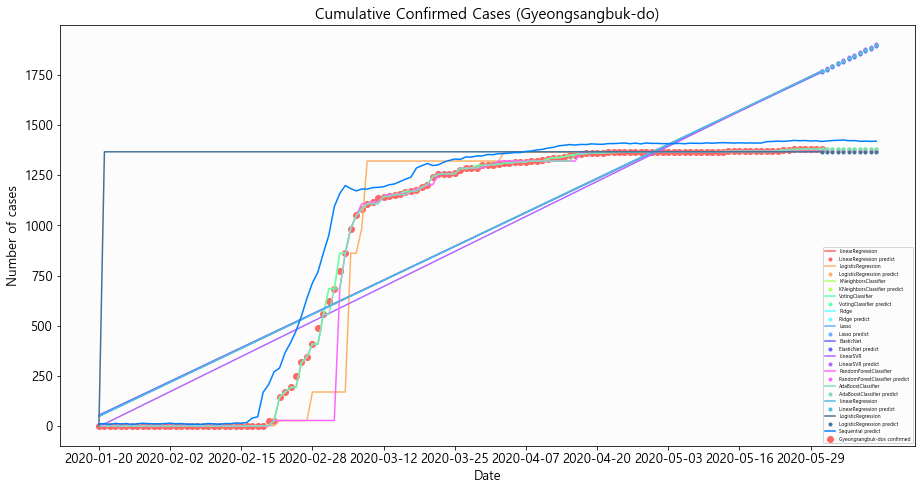

MSE: 4398.797, RMSE :66.323
Variance score : 0.945
MSE: 10735.741, RMSE :103.613
Variance score : 0.865
오차 행렬
[[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

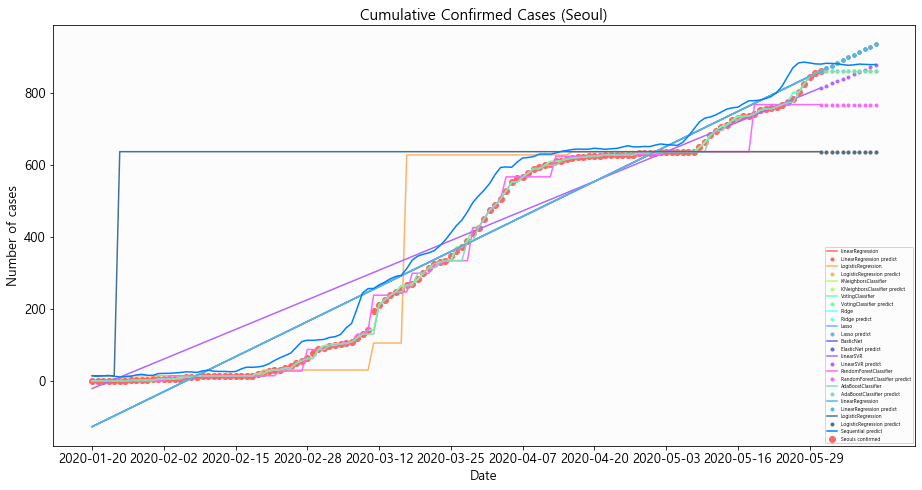

MSE: 5608.181, RMSE :74.888
Variance score : 0.933
MSE: 23639.889, RMSE :153.753
Variance score : 0.717
오차 행렬
[[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 

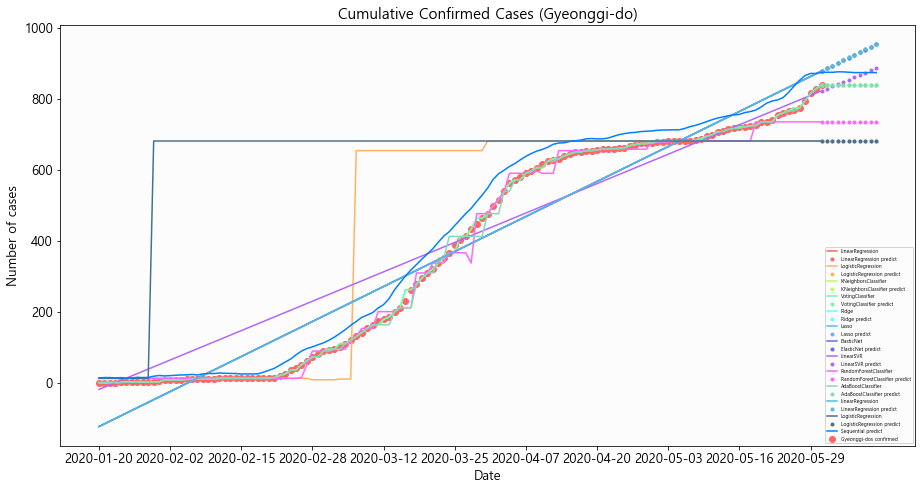

MSE: 164.850, RMSE :12.839
Variance score : 0.927
MSE: 314.519, RMSE :17.735
Variance score : 0.861
오차 행렬
[[9 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]]
정확도: 0.4444, 정밀도: 0.4198, 재현율: 0.

Epoch 59/100
 - 0s - loss: 11.4233
Epoch 60/100
 - 0s - loss: 13.4458
Epoch 61/100
 - 0s - loss: 11.9102
Epoch 62/100
 - 0s - loss: 13.4675
Epoch 63/100
 - 0s - loss: 11.3026
Epoch 64/100
 - 0s - loss: 14.0566
Epoch 65/100
 - 0s - loss: 11.2035
Epoch 66/100
 - 0s - loss: 14.3246
Epoch 67/100
 - 0s - loss: 11.3882
Epoch 68/100
 - 0s - loss: 10.8525
Epoch 69/100
 - 0s - loss: 13.2376
Epoch 70/100
 - 0s - loss: 11.0828
Epoch 71/100
 - 0s - loss: 14.4495
Epoch 72/100
 - 0s - loss: 12.1729
Epoch 73/100
 - 0s - loss: 11.5650
Epoch 74/100
 - 0s - loss: 12.1225
Epoch 75/100
 - 0s - loss: 12.4672
Epoch 76/100
 - 0s - loss: 10.6535
Epoch 77/100
 - 0s - loss: 11.7832
Epoch 78/100
 - 0s - loss: 12.6641
Epoch 79/100
 - 0s - loss: 12.8065
Epoch 80/100
 - 0s - loss: 11.1793
Epoch 81/100
 - 0s - loss: 11.8295
Epoch 82/100
 - 0s - loss: 10.7627
Epoch 83/100
 - 0s - loss: 11.0842
Epoch 84/100
 - 0s - loss: 10.7608
Epoch 85/100
 - 0s - loss: 11.5493
Epoch 86/100
 - 0s - loss: 11.4336
Epoch 87/100
 - 0s -

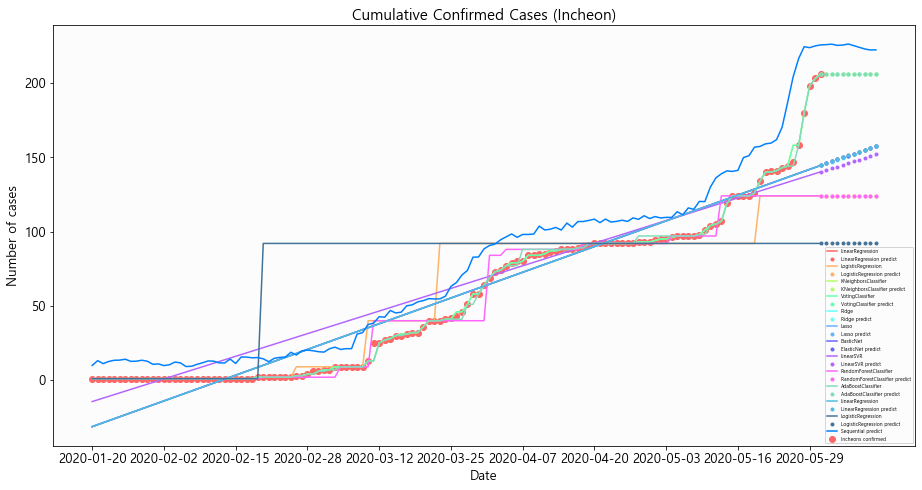

MSE: 554.001, RMSE :23.537
Variance score : 0.837
MSE: 163.333, RMSE :12.780
Variance score : 0.952
오차 행렬
[[9 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]]
정확도: 0.5185, 정밀도: 0.4265, 재현율: 0.5185
오차 행렬
[[9 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 

Epoch 95/100
 - 0s - loss: 20.5097
Epoch 96/100
 - 0s - loss: 22.4363
Epoch 97/100
 - 0s - loss: 19.5833
Epoch 98/100
 - 0s - loss: 21.8143
Epoch 99/100
 - 0s - loss: 19.5376
Epoch 100/100
 - 0s - loss: 19.6126
['LinearRegression', 'LinearRegression predict', 'LogisticRegression', 'LogisticRegression predict', 'KNeighborsClassifier', 'KNeighborsClassifier predict', 'VotingClassifier', 'VotingClassifier predict', 'Ridge', 'Ridge predict', 'Lasso', 'Lasso predict', 'ElasticNet', 'ElasticNet predict', 'LinearSVR', 'LinearSVR predict', 'RandomForestClassifier', 'RandomForestClassifier predict', 'AdaBoostClassifier', 'AdaBoostClassifier predict', 'LinearRegression', 'LinearRegression predict', 'LogisticRegression', 'LogisticRegression predict', 'Sequential predict', 'Busans confirmed']


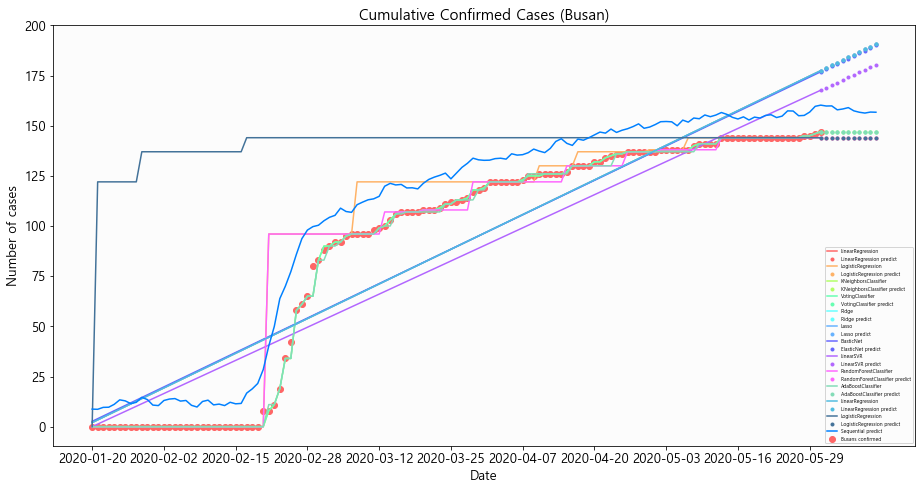

MSE: 754.469, RMSE :27.468
Variance score : 0.811
MSE: 252.630, RMSE :15.894
Variance score : 0.937
오차 행렬
[[10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  

Epoch 42/100
 - 0s - loss: 43.4932
Epoch 43/100
 - 0s - loss: 41.6240
Epoch 44/100
 - 0s - loss: 43.6095
Epoch 45/100
 - 0s - loss: 40.6146
Epoch 46/100
 - 0s - loss: 38.1223
Epoch 47/100
 - 0s - loss: 40.4367
Epoch 48/100
 - 0s - loss: 42.0775
Epoch 49/100
 - 0s - loss: 35.5838
Epoch 50/100
 - 0s - loss: 38.5506
Epoch 51/100
 - 0s - loss: 32.4361
Epoch 52/100
 - 0s - loss: 34.6870
Epoch 53/100
 - 0s - loss: 38.4716
Epoch 54/100
 - 0s - loss: 33.3645
Epoch 55/100
 - 0s - loss: 30.8451
Epoch 56/100
 - 0s - loss: 33.6322
Epoch 57/100
 - 0s - loss: 31.6678
Epoch 58/100
 - 0s - loss: 30.4851
Epoch 59/100
 - 0s - loss: 29.6197
Epoch 60/100
 - 0s - loss: 31.3960
Epoch 61/100
 - 0s - loss: 26.8305
Epoch 62/100
 - 0s - loss: 29.4801
Epoch 63/100
 - 0s - loss: 24.4932
Epoch 64/100
 - 0s - loss: 30.6025
Epoch 65/100
 - 0s - loss: 28.7635
Epoch 66/100
 - 0s - loss: 26.1518
Epoch 67/100
 - 0s - loss: 24.7045
Epoch 68/100
 - 0s - loss: 25.3614
Epoch 69/100
 - 0s - loss: 29.6900
Epoch 70/100
 - 0s -

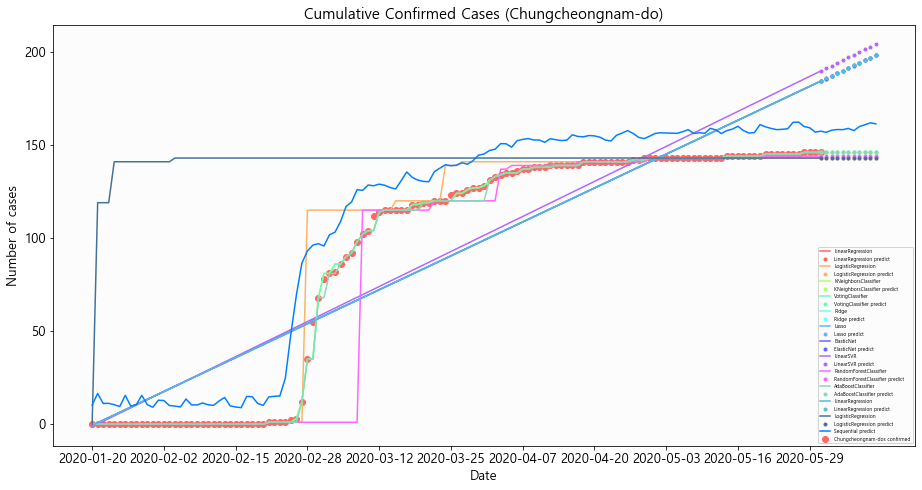

MSE: 368.311, RMSE :19.191
Variance score : 0.853
MSE: 544.370, RMSE :23.332
Variance score : 0.783
오차 행렬
[[9 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]]
정확도: 0.5185, 정밀도: 0.4224, 재현율: 0.5185
오차 행렬
[[9 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 

Epoch 86/100
 - 0s - loss: 14.0045
Epoch 87/100
 - 0s - loss: 14.2527
Epoch 88/100
 - 0s - loss: 14.9084
Epoch 89/100
 - 0s - loss: 15.3191
Epoch 90/100
 - 0s - loss: 13.4667
Epoch 91/100
 - 0s - loss: 13.3296
Epoch 92/100
 - 0s - loss: 17.5085
Epoch 93/100
 - 0s - loss: 15.6738
Epoch 94/100
 - 0s - loss: 13.5833
Epoch 95/100
 - 0s - loss: 14.8818
Epoch 96/100
 - 0s - loss: 15.9367
Epoch 97/100
 - 0s - loss: 13.8036
Epoch 98/100
 - 0s - loss: 14.0056
Epoch 99/100
 - 0s - loss: 14.3457
Epoch 100/100
 - 0s - loss: 13.4085
['LinearRegression', 'LinearRegression predict', 'LogisticRegression', 'LogisticRegression predict', 'KNeighborsClassifier', 'KNeighborsClassifier predict', 'VotingClassifier', 'VotingClassifier predict', 'Ridge', 'Ridge predict', 'Lasso', 'Lasso predict', 'ElasticNet', 'ElasticNet predict', 'LinearSVR', 'LinearSVR predict', 'RandomForestClassifier', 'RandomForestClassifier predict', 'AdaBoostClassifier', 'AdaBoostClassifier predict', 'LinearRegression', 'LinearRegressi

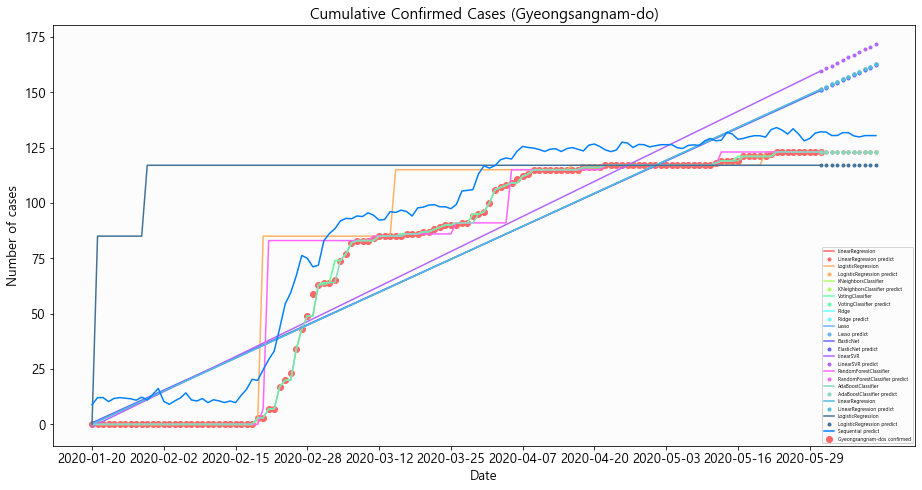

MSE: 40.296, RMSE :6.348
Variance score : 0.917
MSE: 213.667, RMSE :14.617
Variance score : 0.562
오차 행렬
[[10  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  2  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  4  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  0]]
정확도: 0.5556, 정밀도: 0.4250, 재현율: 0.5556
오차 행렬
[[10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 

Epoch 97/100
 - 0s - loss: 7.1976
Epoch 98/100
 - 0s - loss: 7.4044
Epoch 99/100
 - 0s - loss: 6.6351
Epoch 100/100
 - 0s - loss: 7.1428
['LinearRegression', 'LinearRegression predict', 'LogisticRegression', 'LogisticRegression predict', 'KNeighborsClassifier', 'KNeighborsClassifier predict', 'VotingClassifier', 'VotingClassifier predict', 'Ridge', 'Ridge predict', 'Lasso', 'Lasso predict', 'ElasticNet', 'ElasticNet predict', 'LinearSVR', 'LinearSVR predict', 'RandomForestClassifier', 'RandomForestClassifier predict', 'AdaBoostClassifier', 'AdaBoostClassifier predict', 'LinearRegression', 'LinearRegression predict', 'LogisticRegression', 'LogisticRegression predict', 'Sequential predict', 'Chungcheongbuk-dos confirmed']


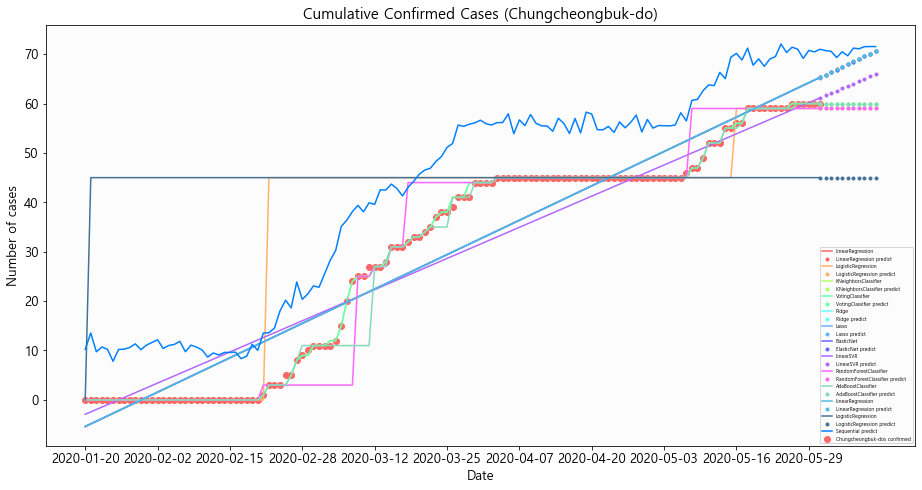

MSE: 37.517, RMSE :6.125
Variance score : 0.922
MSE: 49.481, RMSE :7.034
Variance score : 0.897
오차 행렬
[[10  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  2  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  1  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  0]]
정확도: 0.5185, 정밀도: 0.4741, 재현율: 0.5185
오차 행렬
[[10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0

['LinearRegression', 'LinearRegression predict', 'LogisticRegression', 'LogisticRegression predict', 'KNeighborsClassifier', 'KNeighborsClassifier predict', 'VotingClassifier', 'VotingClassifier predict', 'Ridge', 'Ridge predict', 'Lasso', 'Lasso predict', 'ElasticNet', 'ElasticNet predict', 'LinearSVR', 'LinearSVR predict', 'RandomForestClassifier', 'RandomForestClassifier predict', 'AdaBoostClassifier', 'AdaBoostClassifier predict', 'LinearRegression', 'LinearRegression predict', 'LogisticRegression', 'LogisticRegression predict', 'Sequential predict', 'Gangwon-dos confirmed']


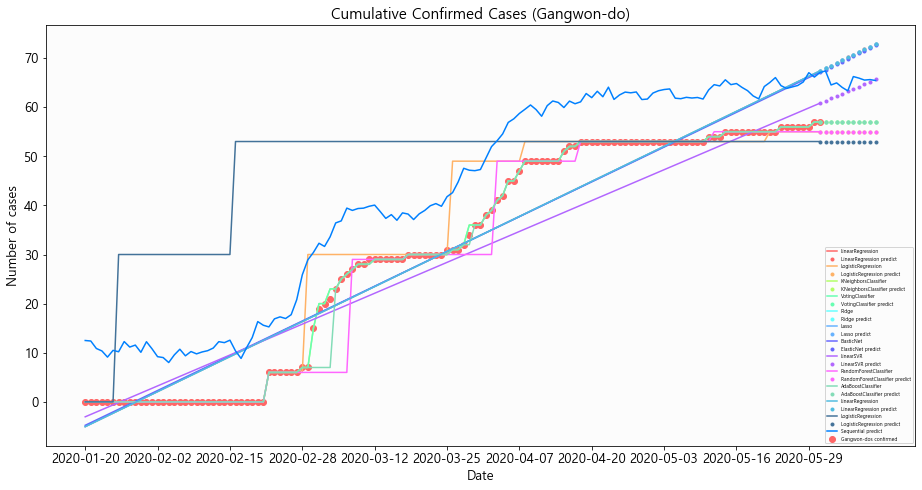

MSE: 41.625, RMSE :6.452
Variance score : 0.888
MSE: 77.222, RMSE :8.788
Variance score : 0.792
오차 행렬
[[10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2]]
정확도: 0.5556, 정밀도: 0.4864, 재현율: 0.5556
오차 행렬
[[10  0  0  0  0  0  0  0  0  0  0  0

Epoch 85/100
 - 0s - loss: 6.7563
Epoch 86/100
 - 0s - loss: 6.7561
Epoch 87/100
 - 0s - loss: 6.5606
Epoch 88/100
 - 0s - loss: 7.0121
Epoch 89/100
 - 0s - loss: 6.4243
Epoch 90/100
 - 0s - loss: 7.1087
Epoch 91/100
 - 0s - loss: 6.7344
Epoch 92/100
 - 0s - loss: 6.4620
Epoch 93/100
 - 0s - loss: 6.8836
Epoch 94/100
 - 0s - loss: 6.4587
Epoch 95/100
 - 0s - loss: 6.8860
Epoch 96/100
 - 0s - loss: 6.6147
Epoch 97/100
 - 0s - loss: 6.4523
Epoch 98/100
 - 0s - loss: 6.7525
Epoch 99/100
 - 0s - loss: 6.9343
Epoch 100/100
 - 0s - loss: 6.7515
['LinearRegression', 'LinearRegression predict', 'LogisticRegression', 'LogisticRegression predict', 'KNeighborsClassifier', 'KNeighborsClassifier predict', 'VotingClassifier', 'VotingClassifier predict', 'Ridge', 'Ridge predict', 'Lasso', 'Lasso predict', 'ElasticNet', 'ElasticNet predict', 'LinearSVR', 'LinearSVR predict', 'RandomForestClassifier', 'RandomForestClassifier predict', 'AdaBoostClassifier', 'AdaBoostClassifier predict', 'LinearRegressio

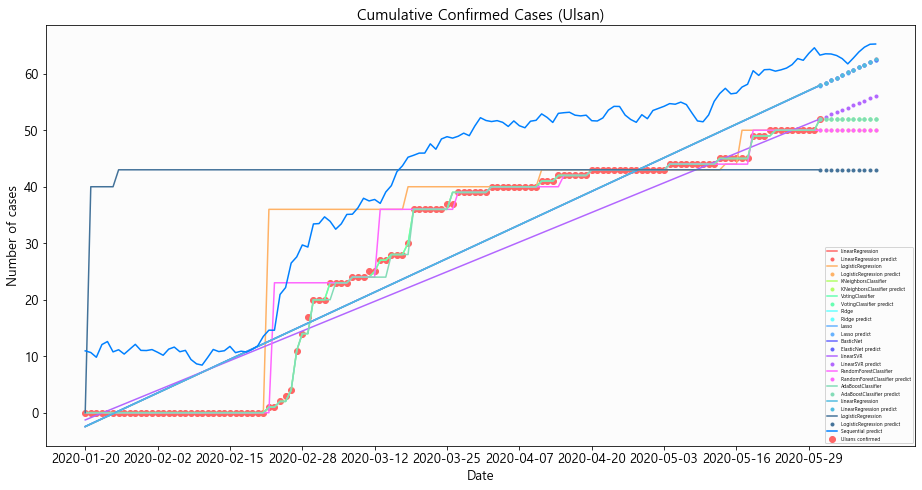

MSE: 110.488, RMSE :10.511
Variance score : 0.776
MSE: 36.296, RMSE :6.025
Variance score : 0.926
오차 행렬
[[10  0  0  0  0  0  0  0]
 [ 0  4  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0]
 [ 0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  2  0  0  0]
 [ 0  0  0  0  0  0  6  0]
 [ 0  0  0  0  0  0  0  3]]
정확도: 0.8519, 정밀도: 0.8519, 재현율: 0.8519
오차 행렬
[[10  0  0  0  0  0  0  0  0]
 [ 0  4  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  1  0  0]
 [ 0  0  0  0  0  0  0  6  0]
 [ 0  0  0  0  0  0  0  0  3]]
정확도: 0.9259, 정밀도: 0.9630, 재현율: 0.9259
오차 행렬
[[10  0  0  0  0  0  0  0  0]
 [ 0  4  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  1  0  0]
 [ 0  0  0  0  0  0  0  6  0]
 [ 0  0  0  0  0  0  0  0  3]]
정확도: 0.9259, 정밀도: 0.9630, 재현율: 0.9259
MSE: 129.61

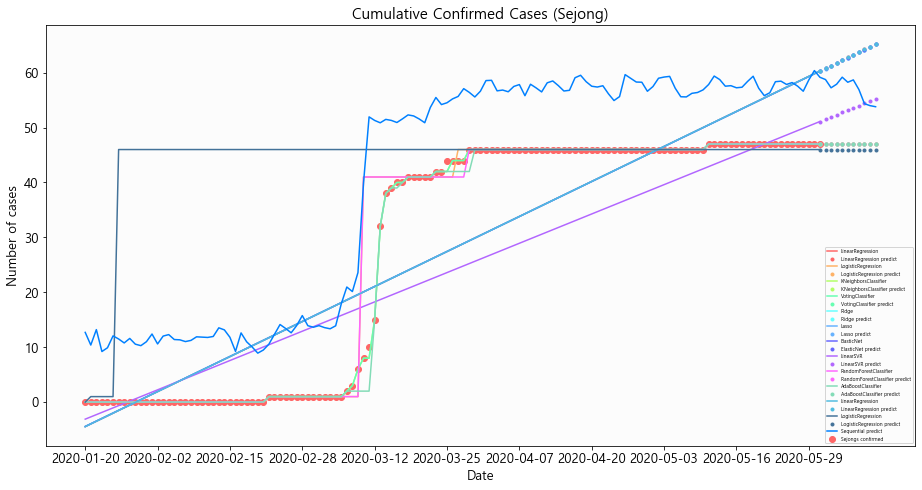

MSE: 26.193, RMSE :5.118
Variance score : 0.915
MSE: 33.815, RMSE :5.815
Variance score : 0.890
오차 행렬
[[10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1]]
정확도: 0.5926, 정밀도: 0.4630, 재현율: 0.5926
오차 행렬
[[10  0  0  0  0  0  0  0  0  0  0  0

Epoch 92/100
 - 0s - loss: 5.7960
Epoch 93/100
 - 0s - loss: 5.5204
Epoch 94/100
 - 0s - loss: 5.5563
Epoch 95/100
 - 0s - loss: 5.7223
Epoch 96/100
 - 0s - loss: 5.6946
Epoch 97/100
 - 0s - loss: 5.5658
Epoch 98/100
 - 0s - loss: 6.3679
Epoch 99/100
 - 0s - loss: 5.7925
Epoch 100/100
 - 0s - loss: 5.7170
['LinearRegression', 'LinearRegression predict', 'LogisticRegression', 'LogisticRegression predict', 'KNeighborsClassifier', 'KNeighborsClassifier predict', 'VotingClassifier', 'VotingClassifier predict', 'Ridge', 'Ridge predict', 'Lasso', 'Lasso predict', 'ElasticNet', 'ElasticNet predict', 'LinearSVR', 'LinearSVR predict', 'RandomForestClassifier', 'RandomForestClassifier predict', 'AdaBoostClassifier', 'AdaBoostClassifier predict', 'LinearRegression', 'LinearRegression predict', 'LogisticRegression', 'LogisticRegression predict', 'Sequential predict', 'Daejeons confirmed']


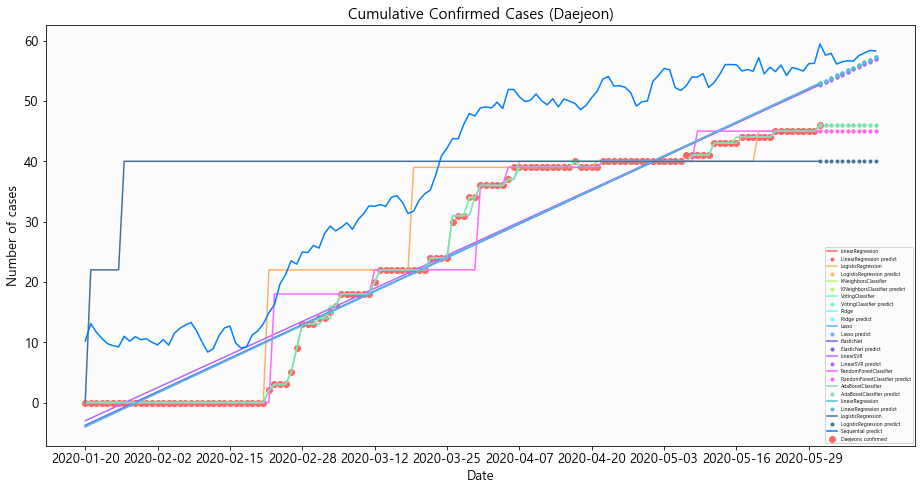

MSE: 10.773, RMSE :3.282
Variance score : 0.922
MSE: 3.037, RMSE :1.743
Variance score : 0.978
오차 행렬
[[4 0 0 0 0 0 0 0 0 0]
 [0 5 1 0 0 0 0 0 0 0]
 [0 0 2 1 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 3 0]
 [0 0 0 0 0 0 0 0 0 5]]
정확도: 0.8519, 정밀도: 0.8704, 재현율: 0.8519
오차 행렬
[[4 0 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0 0]
 [0 0 2 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 0 0]
 [0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 3 0]
 [0 0 0 0 0 0 0 0 0 0 5]]
정확도: 0.9259, 정밀도: 0.9815, 재현율: 0.9259
오차 행렬
[[4 0 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0 0]
 [0 0 2 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 0 0]
 [0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 3 0]
 [0 0 0 0 0 0 0 0 0 0 5]]
정확도: 0.9259, 정밀도: 0.9815, 재현

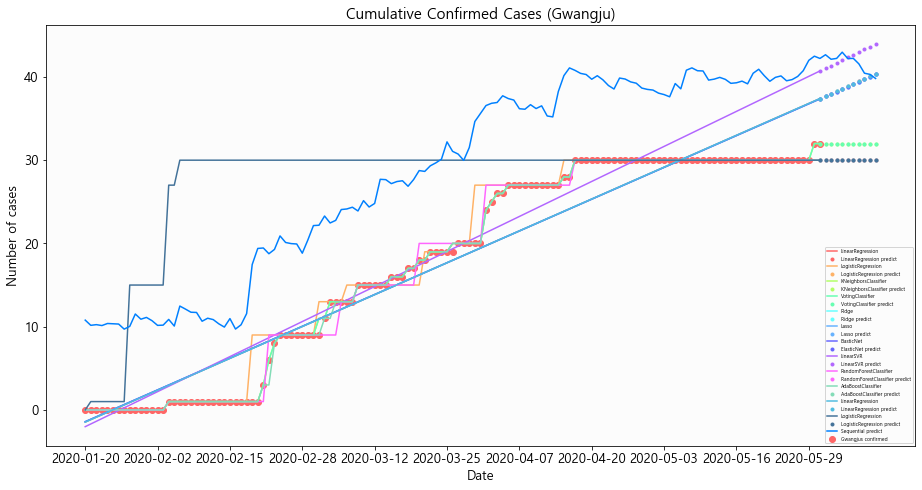

MSE: 2.466, RMSE :1.570
Variance score : 0.955
MSE: 5.370, RMSE :2.317
Variance score : 0.903
오차 행렬
[[0 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 2 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 2 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 2]]
정확도: 0.5556, 정밀도: 0.4527, 재현율: 0.5556
오차 행렬
[[2 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 7 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 3 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 2 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 2 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 2]]
정확도: 0.8889, 정밀도: 0.8735, 재현율: 0.8889
오차 행렬

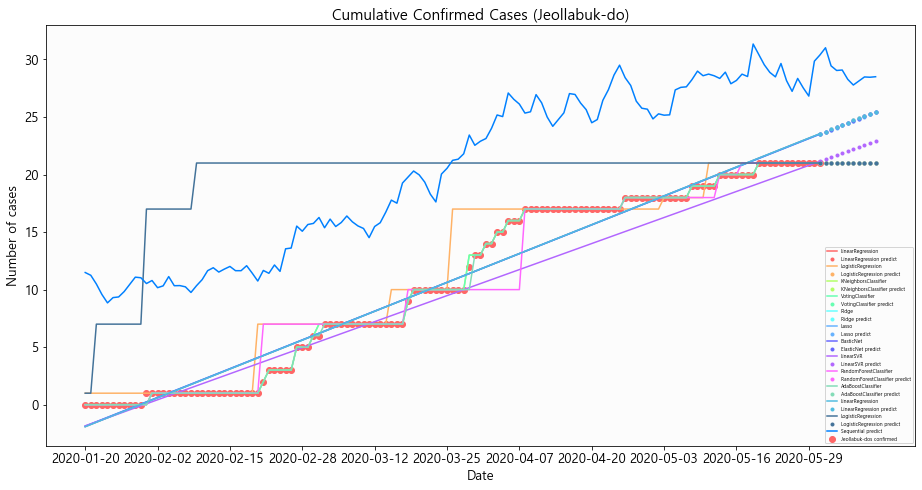

MSE: 3.260, RMSE :1.805
Variance score : 0.931
MSE: 5.741, RMSE :2.396
Variance score : 0.878
오차 행렬
[[10  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  3  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  4  0  0]
 [ 0  0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0  3]]
정확도: 0.7778, 정밀도: 0.6790, 재현율: 0.7778
오차 행렬
[[10  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  3  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  4  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  0  0  0  0  3]]
정확도: 0.9259, 정밀도: 0.9444, 재현율: 0.9259
오차 행렬
[[10  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  

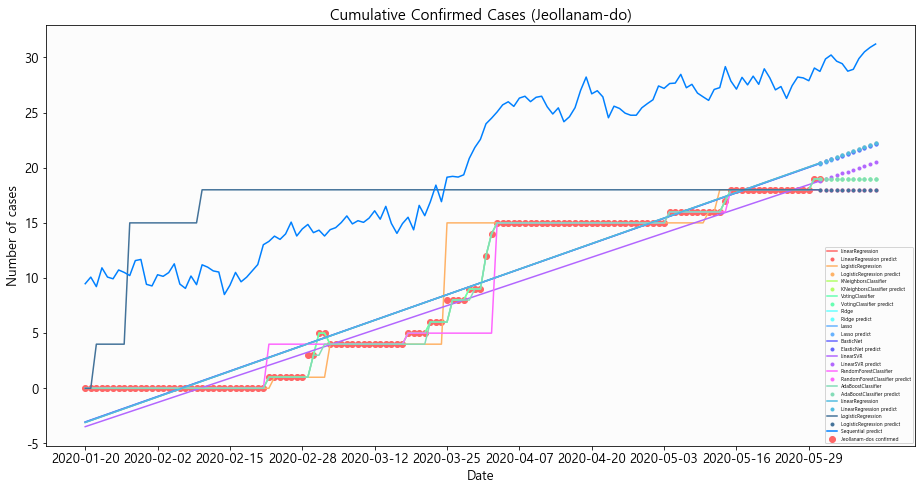

MSE: 2.150, RMSE :1.466
Variance score : 0.928
MSE: 1.407, RMSE :1.186
Variance score : 0.953
오차 행렬
[[9 1 0 0 0 0 0 0 0]
 [0 1 0 2 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 2 1 0]
 [0 0 0 0 0 0 0 2 0]
 [0 0 0 0 0 0 0 0 3]]
정확도: 0.7037, 정밀도: 0.7160, 재현율: 0.7037
오차 행렬
[[10  0  0  0  0  0  0  0  0  0  0]
 [ 0  2  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  0  0  0  0]
 [ 0  0  0  2  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  1  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  3  0  0]
 [ 0  0  0  0  0  0  0  0  0  2  0]
 [ 0  0  0  0  0  0  0  0  0  0  3]]
정확도: 0.8148, 정밀도: 0.8148, 재현율: 0.8148
오차 행렬
[[10  0  0  0  0  0  0  0  0  0  0]
 [ 0  2  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  0  0  0  0]
 [ 0  0  0  2  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  1  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  

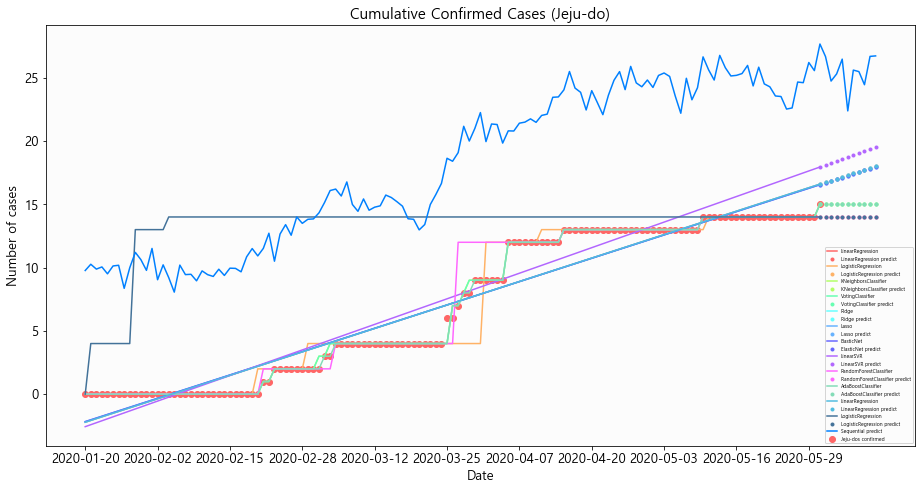

In [208]:
for i, loc_confirm_df in enumerate(loc_confirm_dfs):
    clfs_list = []
    plot_draw_clfs(loc_confirm_df, loc_list, i)

In [232]:
loc_list = np.append(loc_list, 'total')
loc_list

array(['Daegu', 'Gyeongsangbuk-do', 'Seoul', 'Gyeonggi-do', 'Incheon',
       'Busan', 'Chungcheongnam-do', 'Gyeongsangnam-do',
       'Chungcheongbuk-do', 'Gangwon-do', 'Ulsan', 'Sejong', 'Daejeon',
       'Gwangju', 'Jeollabuk-do', 'Jeollanam-do', 'Jeju-do', 'total'],
      dtype=object)

In [233]:
total_list = location_raw.groupby('date').sum().confirmed
total_df = total_list.to_frame()
total_df = total_df.reset_index()
total_df

date  confirmed
0    2020-01-20          1
1    2020-01-21          1
2    2020-01-22          1
3    2020-01-23          1
4    2020-01-24          2
..          ...        ...
128  2020-05-27      10743
129  2020-05-28      10815
130  2020-05-29      10873
131  2020-05-30      10907
132  2020-05-31      10934

[133 rows x 2 columns]

In [234]:
loc_confirm_dfs.append(total_df)
loc_confirm_dfs

[            date  confirmed
 2     2020-01-20          0
 19    2020-01-21          0
 36    2020-01-22          0
 53    2020-01-23          0
 70    2020-01-24          0
 ...          ...        ...
 2178  2020-05-27       6878
 2195  2020-05-28       6880
 2212  2020-05-29       6880
 2229  2020-05-30       6882
 2246  2020-05-31       6883
 
 [133 rows x 2 columns],
             date  confirmed
 14    2020-01-20          0
 31    2020-01-21          0
 48    2020-01-22          0
 65    2020-01-23          0
 82    2020-01-24          0
 ...          ...        ...
 2190  2020-05-27       1378
 2207  2020-05-28       1379
 2224  2020-05-29       1379
 2241  2020-05-30       1379
 2258  2020-05-31       1379
 
 [133 rows x 2 columns],
             date  confirmed
 0     2020-01-20          0
 17    2020-01-21          0
 34    2020-01-22          0
 51    2020-01-23          0
 68    2020-01-24          0
 ...          ...        ...
 2176  2020-05-27        802
 2193  2020-05-28 

MSE: 2165156.671, RMSE :1471.447
Variance score : 0.776
MSE: 561324.259, RMSE :749.216
Variance score : 0.942
오차 행렬
[[9 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 

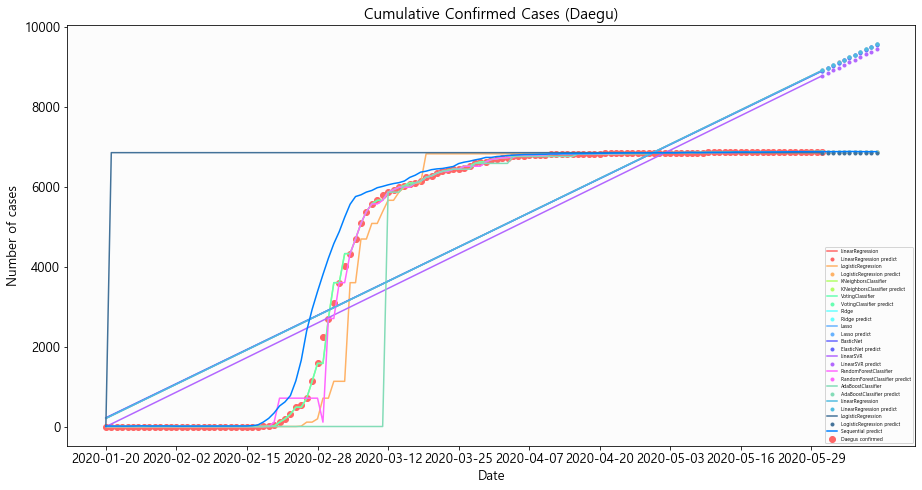

MSE: 76211.803, RMSE :276.065
Variance score : 0.793
MSE: 29307.370, RMSE :171.194
Variance score : 0.920
오차 행렬
[[9 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0

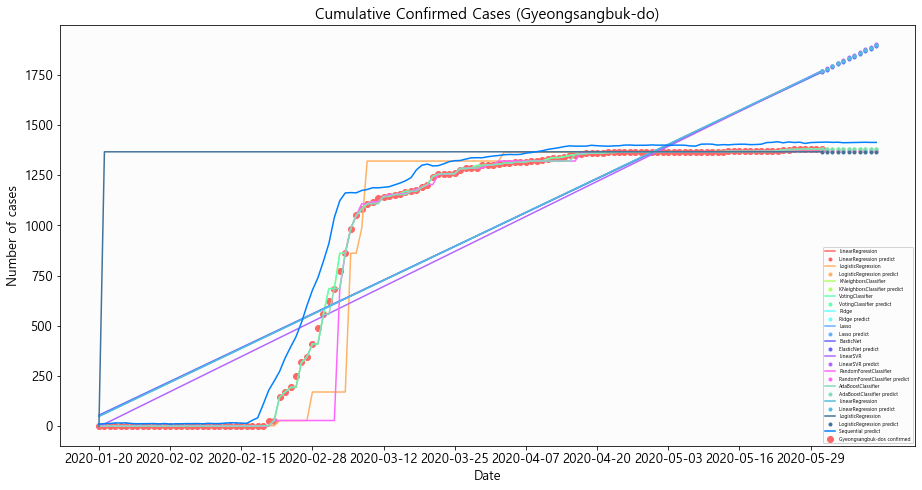

MSE: 4398.797, RMSE :66.323
Variance score : 0.945
MSE: 10735.741, RMSE :103.613
Variance score : 0.865
오차 행렬
[[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

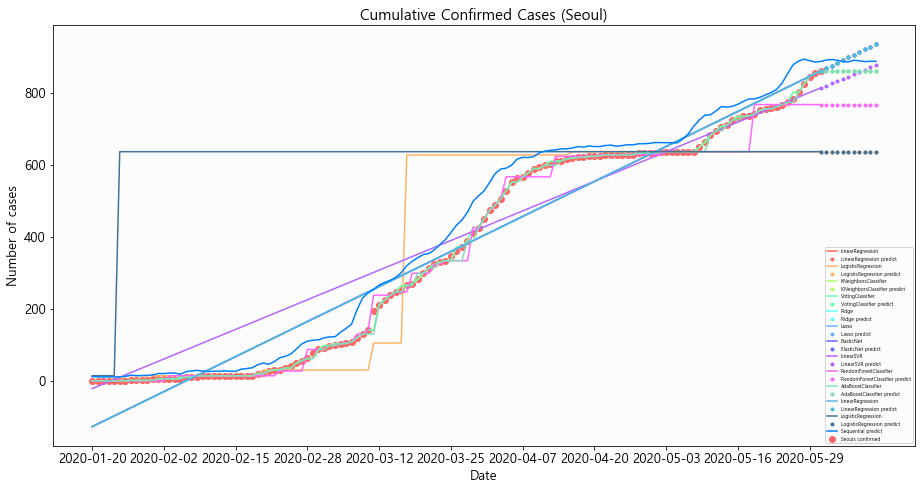

MSE: 5608.181, RMSE :74.888
Variance score : 0.933
MSE: 23639.889, RMSE :153.753
Variance score : 0.717
오차 행렬
[[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 

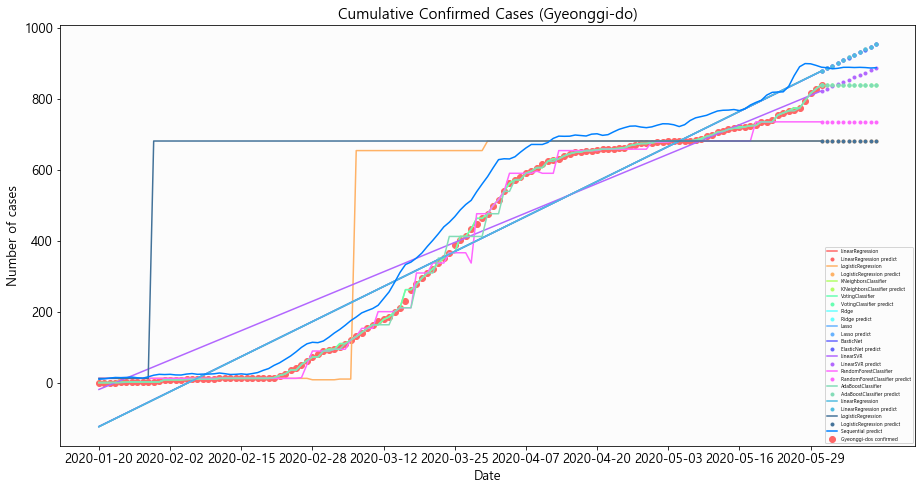

MSE: 164.850, RMSE :12.839
Variance score : 0.927
MSE: 314.519, RMSE :17.735
Variance score : 0.861
오차 행렬
[[9 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]]
정확도: 0.4444, 정밀도: 0.4198, 재현율: 0.

Epoch 59/100
 - 0s - loss: 11.1511
Epoch 60/100
 - 0s - loss: 11.8192
Epoch 61/100
 - 0s - loss: 10.6242
Epoch 62/100
 - 0s - loss: 13.4533
Epoch 63/100
 - 0s - loss: 13.3511
Epoch 64/100
 - 0s - loss: 11.0470
Epoch 65/100
 - 0s - loss: 13.4611
Epoch 66/100
 - 0s - loss: 10.7697
Epoch 67/100
 - 0s - loss: 12.4999
Epoch 68/100
 - 0s - loss: 14.8439
Epoch 69/100
 - 0s - loss: 11.3341
Epoch 70/100
 - 0s - loss: 13.4304
Epoch 71/100
 - 0s - loss: 11.6393
Epoch 72/100
 - 0s - loss: 10.5518
Epoch 73/100
 - 0s - loss: 12.2252
Epoch 74/100
 - 0s - loss: 11.8027
Epoch 75/100
 - 0s - loss: 10.5479
Epoch 76/100
 - 0s - loss: 13.2748
Epoch 77/100
 - 0s - loss: 11.0747
Epoch 78/100
 - 0s - loss: 11.8610
Epoch 79/100
 - 0s - loss: 11.8500
Epoch 80/100
 - 0s - loss: 10.9420
Epoch 81/100
 - 0s - loss: 10.6662
Epoch 82/100
 - 0s - loss: 12.3266
Epoch 83/100
 - 0s - loss: 10.8229
Epoch 84/100
 - 0s - loss: 11.8154
Epoch 85/100
 - 0s - loss: 10.4031
Epoch 86/100
 - 0s - loss: 12.7260
Epoch 87/100
 - 0s -

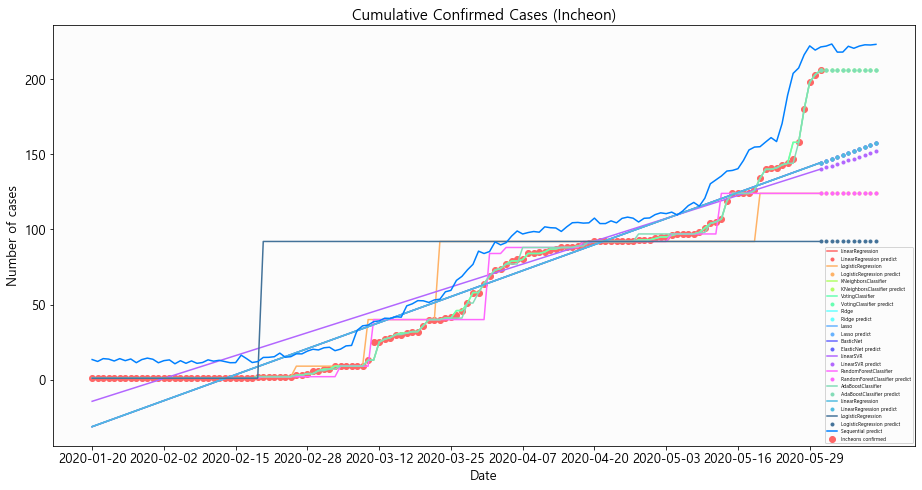

MSE: 554.001, RMSE :23.537
Variance score : 0.837
MSE: 163.333, RMSE :12.780
Variance score : 0.952
오차 행렬
[[9 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]]
정확도: 0.5185, 정밀도: 0.4265, 재현율: 0.5185
오차 행렬
[[9 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 

Epoch 94/100
 - 0s - loss: 39.5819
Epoch 95/100
 - 0s - loss: 39.9004
Epoch 96/100
 - 0s - loss: 39.7912
Epoch 97/100
 - 0s - loss: 38.2461
Epoch 98/100
 - 0s - loss: 37.5812
Epoch 99/100
 - 0s - loss: 36.4991
Epoch 100/100
 - 0s - loss: 37.1080
['LinearRegression', 'LinearRegression predict', 'LogisticRegression', 'LogisticRegression predict', 'KNeighborsClassifier', 'KNeighborsClassifier predict', 'VotingClassifier', 'VotingClassifier predict', 'Ridge', 'Ridge predict', 'Lasso', 'Lasso predict', 'ElasticNet', 'ElasticNet predict', 'LinearSVR', 'LinearSVR predict', 'RandomForestClassifier', 'RandomForestClassifier predict', 'AdaBoostClassifier', 'AdaBoostClassifier predict', 'LinearRegression', 'LinearRegression predict', 'LogisticRegression', 'LogisticRegression predict', 'Sequential predict', 'Busans confirmed']


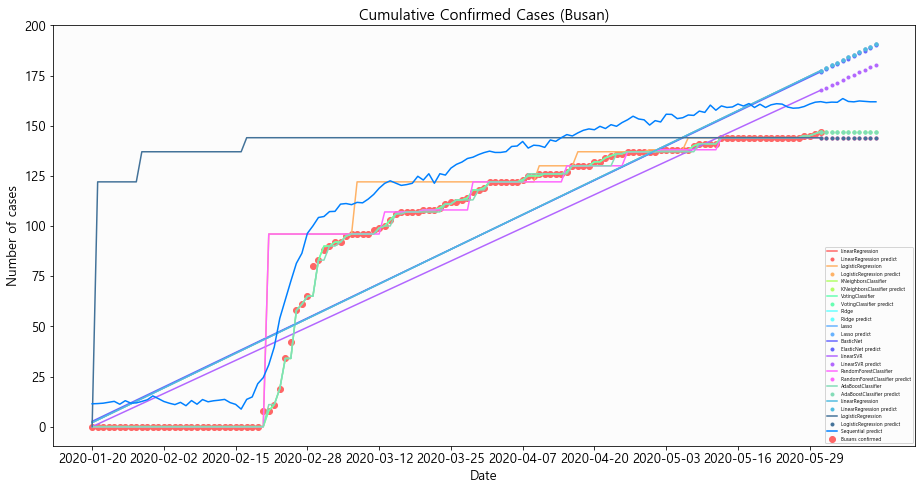

MSE: 754.469, RMSE :27.468
Variance score : 0.811
MSE: 252.630, RMSE :15.894
Variance score : 0.937
오차 행렬
[[10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  

Epoch 42/100
 - 0s - loss: 41.6246
Epoch 43/100
 - 0s - loss: 44.8943
Epoch 44/100
 - 0s - loss: 40.2540
Epoch 45/100
 - 0s - loss: 36.5822
Epoch 46/100
 - 0s - loss: 44.5783
Epoch 47/100
 - 0s - loss: 37.2431
Epoch 48/100
 - 0s - loss: 39.3931
Epoch 49/100
 - 0s - loss: 31.7965
Epoch 50/100
 - 0s - loss: 35.0154
Epoch 51/100
 - 0s - loss: 29.4237
Epoch 52/100
 - 0s - loss: 36.1065
Epoch 53/100
 - 0s - loss: 30.3624
Epoch 54/100
 - 0s - loss: 29.1364
Epoch 55/100
 - 0s - loss: 30.5241
Epoch 56/100
 - 0s - loss: 28.2843
Epoch 57/100
 - 0s - loss: 27.8624
Epoch 58/100
 - 0s - loss: 26.6801
Epoch 59/100
 - 0s - loss: 27.3383
Epoch 60/100
 - 0s - loss: 22.0610
Epoch 61/100
 - 0s - loss: 24.3307
Epoch 62/100
 - 0s - loss: 31.3660
Epoch 63/100
 - 0s - loss: 25.5660
Epoch 64/100
 - 0s - loss: 20.6624
Epoch 65/100
 - 0s - loss: 26.8940
Epoch 66/100
 - 0s - loss: 22.0293
Epoch 67/100
 - 0s - loss: 22.2528
Epoch 68/100
 - 0s - loss: 23.3313
Epoch 69/100
 - 0s - loss: 24.3472
Epoch 70/100
 - 0s -

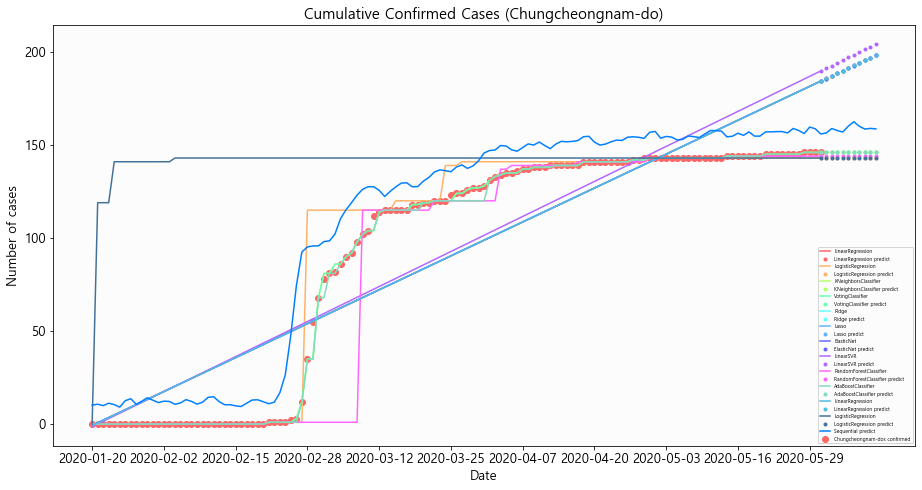

MSE: 368.311, RMSE :19.191
Variance score : 0.853
MSE: 544.370, RMSE :23.332
Variance score : 0.783
오차 행렬
[[9 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]]
정확도: 0.5185, 정밀도: 0.4224, 재현율: 0.5185
오차 행렬
[[9 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 

Epoch 86/100
 - 0s - loss: 21.4095
Epoch 87/100
 - 0s - loss: 22.4315
Epoch 88/100
 - 0s - loss: 21.6445
Epoch 89/100
 - 0s - loss: 20.3336
Epoch 90/100
 - 0s - loss: 24.9958
Epoch 91/100
 - 0s - loss: 19.8402
Epoch 92/100
 - 0s - loss: 20.2647
Epoch 93/100
 - 0s - loss: 23.2618
Epoch 94/100
 - 0s - loss: 21.0351
Epoch 95/100
 - 0s - loss: 19.5162
Epoch 96/100
 - 0s - loss: 18.4391
Epoch 97/100
 - 0s - loss: 21.7155
Epoch 98/100
 - 0s - loss: 20.0409
Epoch 99/100
 - 0s - loss: 21.7091
Epoch 100/100
 - 0s - loss: 19.2290
['LinearRegression', 'LinearRegression predict', 'LogisticRegression', 'LogisticRegression predict', 'KNeighborsClassifier', 'KNeighborsClassifier predict', 'VotingClassifier', 'VotingClassifier predict', 'Ridge', 'Ridge predict', 'Lasso', 'Lasso predict', 'ElasticNet', 'ElasticNet predict', 'LinearSVR', 'LinearSVR predict', 'RandomForestClassifier', 'RandomForestClassifier predict', 'AdaBoostClassifier', 'AdaBoostClassifier predict', 'LinearRegression', 'LinearRegressi

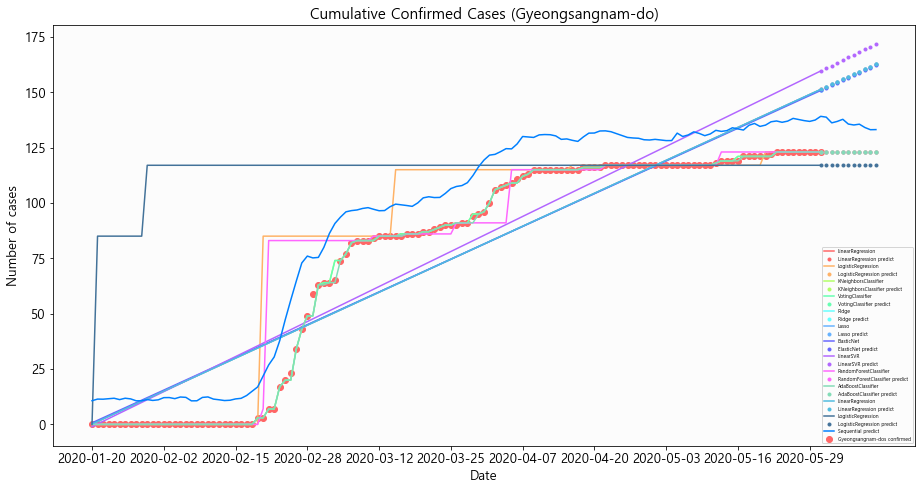

MSE: 40.296, RMSE :6.348
Variance score : 0.917
MSE: 213.667, RMSE :14.617
Variance score : 0.562
오차 행렬
[[10  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  2  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  4  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  0]]
정확도: 0.5556, 정밀도: 0.4250, 재현율: 0.5556
오차 행렬
[[10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 

Epoch 97/100
 - 0s - loss: 5.7704
Epoch 98/100
 - 0s - loss: 5.6651
Epoch 99/100
 - 0s - loss: 5.9283
Epoch 100/100
 - 0s - loss: 5.5976
['LinearRegression', 'LinearRegression predict', 'LogisticRegression', 'LogisticRegression predict', 'KNeighborsClassifier', 'KNeighborsClassifier predict', 'VotingClassifier', 'VotingClassifier predict', 'Ridge', 'Ridge predict', 'Lasso', 'Lasso predict', 'ElasticNet', 'ElasticNet predict', 'LinearSVR', 'LinearSVR predict', 'RandomForestClassifier', 'RandomForestClassifier predict', 'AdaBoostClassifier', 'AdaBoostClassifier predict', 'LinearRegression', 'LinearRegression predict', 'LogisticRegression', 'LogisticRegression predict', 'Sequential predict', 'Chungcheongbuk-dos confirmed']


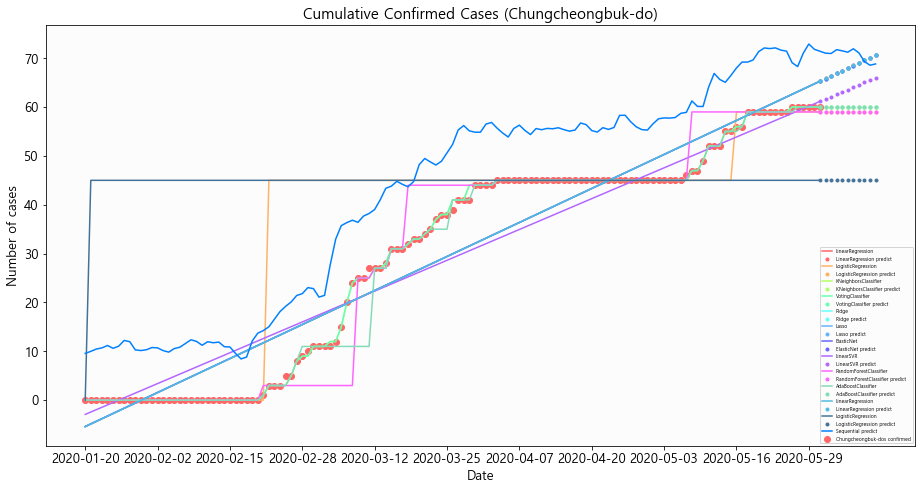

MSE: 37.517, RMSE :6.125
Variance score : 0.922
MSE: 49.481, RMSE :7.034
Variance score : 0.897
오차 행렬
[[10  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  2  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  1  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  0]]
정확도: 0.5185, 정밀도: 0.4741, 재현율: 0.5185
오차 행렬
[[10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0

['LinearRegression', 'LinearRegression predict', 'LogisticRegression', 'LogisticRegression predict', 'KNeighborsClassifier', 'KNeighborsClassifier predict', 'VotingClassifier', 'VotingClassifier predict', 'Ridge', 'Ridge predict', 'Lasso', 'Lasso predict', 'ElasticNet', 'ElasticNet predict', 'LinearSVR', 'LinearSVR predict', 'RandomForestClassifier', 'RandomForestClassifier predict', 'AdaBoostClassifier', 'AdaBoostClassifier predict', 'LinearRegression', 'LinearRegression predict', 'LogisticRegression', 'LogisticRegression predict', 'Sequential predict', 'Gangwon-dos confirmed']


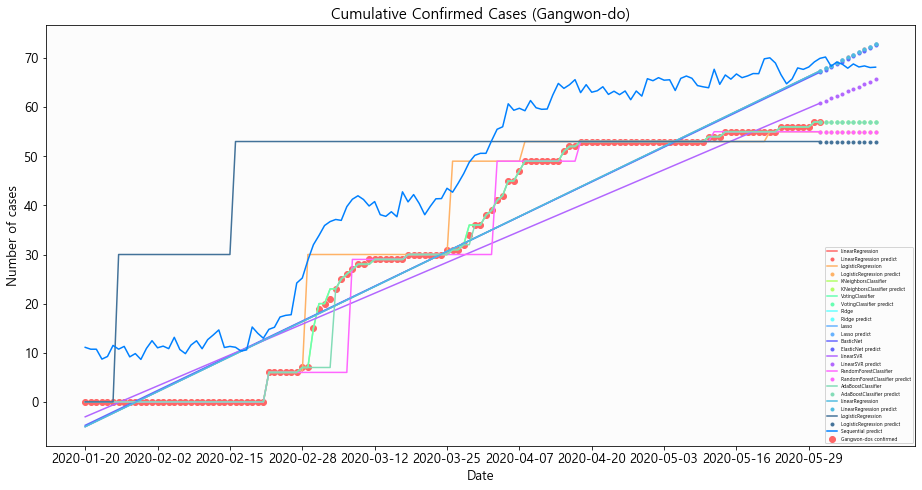

MSE: 41.625, RMSE :6.452
Variance score : 0.888
MSE: 77.222, RMSE :8.788
Variance score : 0.792
오차 행렬
[[10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2]]
정확도: 0.5556, 정밀도: 0.4864, 재현율: 0.5556
오차 행렬
[[10  0  0  0  0  0  0  0  0  0  0  0

Epoch 84/100
 - 0s - loss: 7.5818
Epoch 85/100
 - 0s - loss: 7.3543
Epoch 86/100
 - 0s - loss: 7.4106
Epoch 87/100
 - 0s - loss: 7.4031
Epoch 88/100
 - 0s - loss: 7.4999
Epoch 89/100
 - 0s - loss: 7.6288
Epoch 90/100
 - 0s - loss: 7.7975
Epoch 91/100
 - 0s - loss: 7.3137
Epoch 92/100
 - 0s - loss: 7.2936
Epoch 93/100
 - 0s - loss: 7.9610
Epoch 94/100
 - 0s - loss: 7.3267
Epoch 95/100
 - 0s - loss: 7.4079
Epoch 96/100
 - 0s - loss: 7.5590
Epoch 97/100
 - 0s - loss: 7.6666
Epoch 98/100
 - 0s - loss: 7.5403
Epoch 99/100
 - 0s - loss: 7.6344
Epoch 100/100
 - 0s - loss: 7.2528
['LinearRegression', 'LinearRegression predict', 'LogisticRegression', 'LogisticRegression predict', 'KNeighborsClassifier', 'KNeighborsClassifier predict', 'VotingClassifier', 'VotingClassifier predict', 'Ridge', 'Ridge predict', 'Lasso', 'Lasso predict', 'ElasticNet', 'ElasticNet predict', 'LinearSVR', 'LinearSVR predict', 'RandomForestClassifier', 'RandomForestClassifier predict', 'AdaBoostClassifier', 'AdaBoostCla

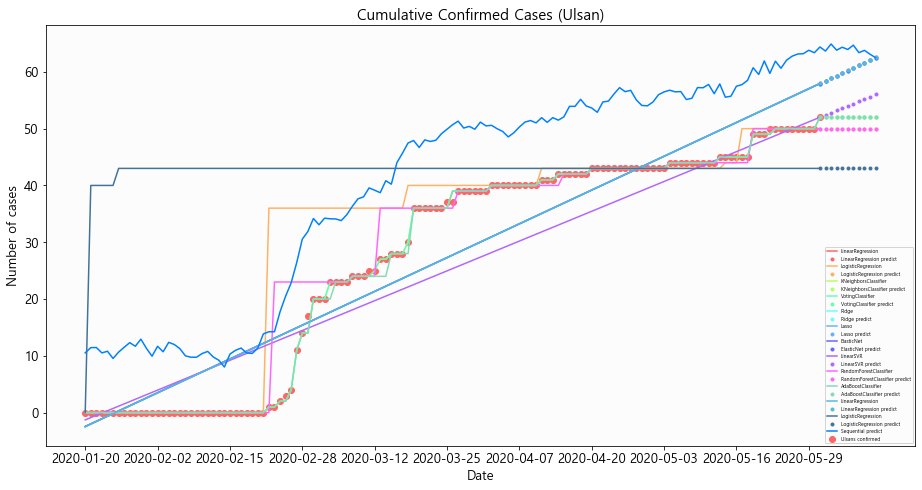

MSE: 110.488, RMSE :10.511
Variance score : 0.776
MSE: 36.296, RMSE :6.025
Variance score : 0.926
오차 행렬
[[10  0  0  0  0  0  0  0]
 [ 0  4  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0]
 [ 0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  2  0  0  0]
 [ 0  0  0  0  0  0  6  0]
 [ 0  0  0  0  0  0  0  3]]
정확도: 0.8519, 정밀도: 0.8519, 재현율: 0.8519
오차 행렬
[[10  0  0  0  0  0  0  0  0]
 [ 0  4  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  1  0  0]
 [ 0  0  0  0  0  0  0  6  0]
 [ 0  0  0  0  0  0  0  0  3]]
정확도: 0.9259, 정밀도: 0.9630, 재현율: 0.9259
오차 행렬
[[10  0  0  0  0  0  0  0  0]
 [ 0  4  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  1  0  0]
 [ 0  0  0  0  0  0  0  6  0]
 [ 0  0  0  0  0  0  0  0  3]]
정확도: 0.9259, 정밀도: 0.9630, 재현율: 0.9259
MSE: 129.61

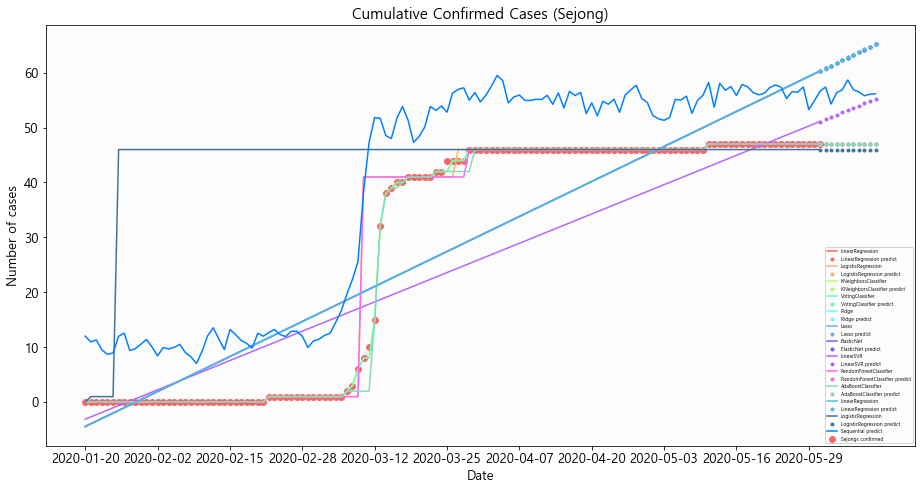

MSE: 26.193, RMSE :5.118
Variance score : 0.915
MSE: 33.815, RMSE :5.815
Variance score : 0.890
오차 행렬
[[10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1]]
정확도: 0.5926, 정밀도: 0.4630, 재현율: 0.5926
오차 행렬
[[10  0  0  0  0  0  0  0  0  0  0  0

Epoch 92/100
 - 0s - loss: 6.2098
Epoch 93/100
 - 0s - loss: 6.2991
Epoch 94/100
 - 0s - loss: 6.1879
Epoch 95/100
 - 0s - loss: 6.9751
Epoch 96/100
 - 0s - loss: 6.2170
Epoch 97/100
 - 0s - loss: 6.7728
Epoch 98/100
 - 0s - loss: 6.3814
Epoch 99/100
 - 0s - loss: 6.0645
Epoch 100/100
 - 0s - loss: 7.1626
['LinearRegression', 'LinearRegression predict', 'LogisticRegression', 'LogisticRegression predict', 'KNeighborsClassifier', 'KNeighborsClassifier predict', 'VotingClassifier', 'VotingClassifier predict', 'Ridge', 'Ridge predict', 'Lasso', 'Lasso predict', 'ElasticNet', 'ElasticNet predict', 'LinearSVR', 'LinearSVR predict', 'RandomForestClassifier', 'RandomForestClassifier predict', 'AdaBoostClassifier', 'AdaBoostClassifier predict', 'LinearRegression', 'LinearRegression predict', 'LogisticRegression', 'LogisticRegression predict', 'Sequential predict', 'Daejeons confirmed']


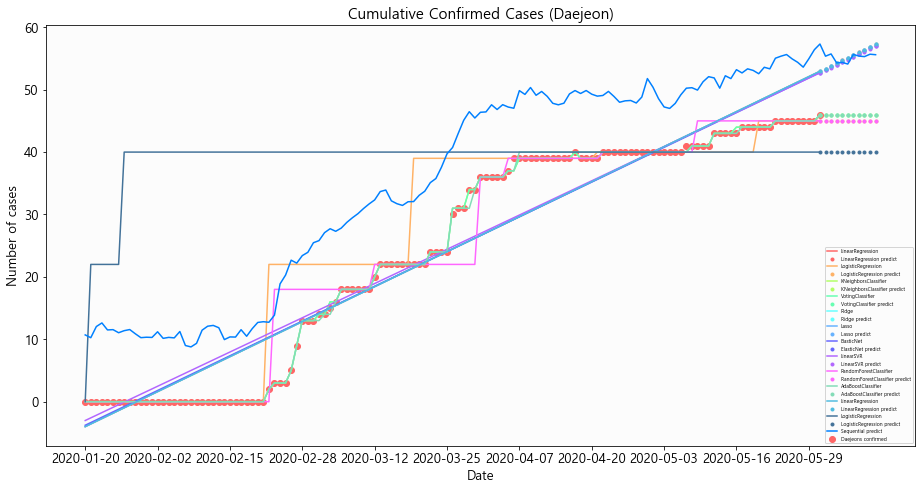

MSE: 10.773, RMSE :3.282
Variance score : 0.922
MSE: 3.037, RMSE :1.743
Variance score : 0.978
오차 행렬
[[4 0 0 0 0 0 0 0 0 0]
 [0 5 1 0 0 0 0 0 0 0]
 [0 0 2 1 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 3 0]
 [0 0 0 0 0 0 0 0 0 5]]
정확도: 0.8519, 정밀도: 0.8704, 재현율: 0.8519
오차 행렬
[[4 0 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0 0]
 [0 0 2 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 0 0]
 [0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 3 0]
 [0 0 0 0 0 0 0 0 0 0 5]]
정확도: 0.9259, 정밀도: 0.9815, 재현율: 0.9259
오차 행렬
[[4 0 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0 0]
 [0 0 2 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 0 0]
 [0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 3 0]
 [0 0 0 0 0 0 0 0 0 0 5]]
정확도: 0.9259, 정밀도: 0.9815, 재현

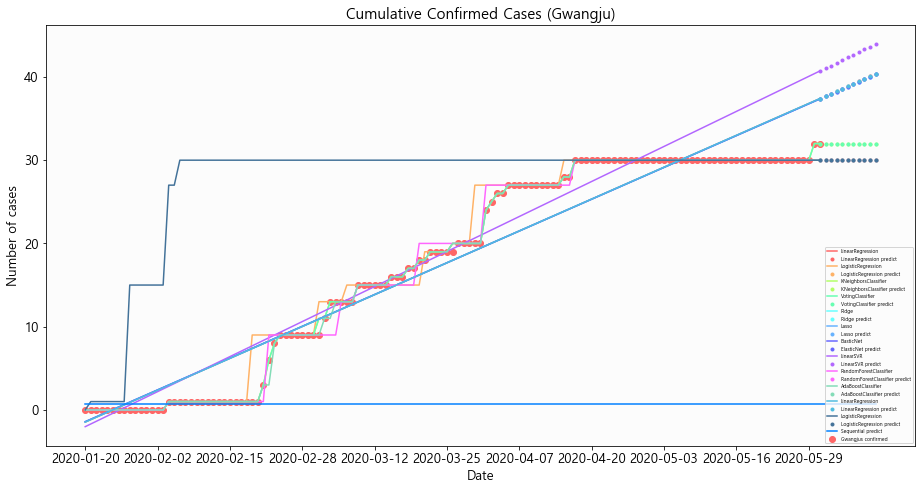

MSE: 2.466, RMSE :1.570
Variance score : 0.955
MSE: 5.370, RMSE :2.317
Variance score : 0.903
오차 행렬
[[0 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 2 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 2 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 2]]
정확도: 0.5556, 정밀도: 0.4527, 재현율: 0.5556
오차 행렬
[[2 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 7 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 3 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 2 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 2 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 2]]
정확도: 0.8889, 정밀도: 0.8735, 재현율: 0.8889
오차 행렬

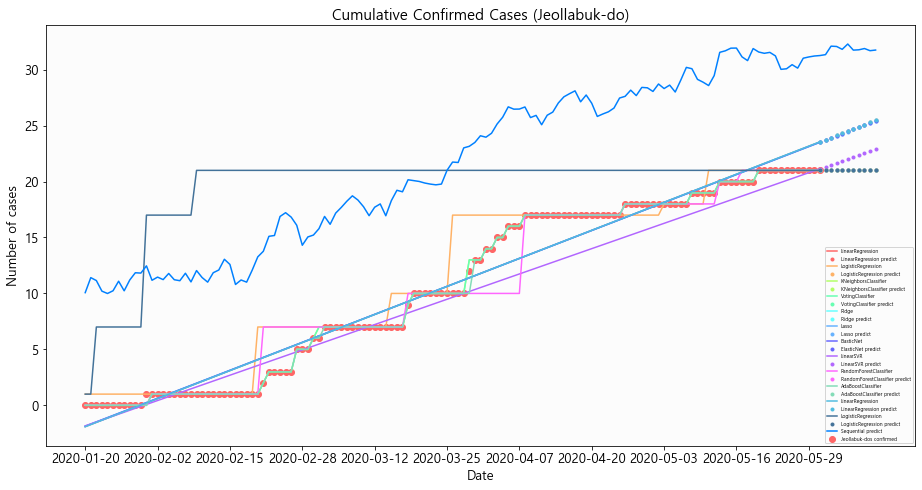

MSE: 3.260, RMSE :1.805
Variance score : 0.931
MSE: 5.741, RMSE :2.396
Variance score : 0.878
오차 행렬
[[10  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  3  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  4  0  0]
 [ 0  0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0  3]]
정확도: 0.7778, 정밀도: 0.6790, 재현율: 0.7778
오차 행렬
[[10  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  3  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  4  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  0  0  0  0  3]]
정확도: 0.9259, 정밀도: 0.9444, 재현율: 0.9259
오차 행렬
[[10  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  

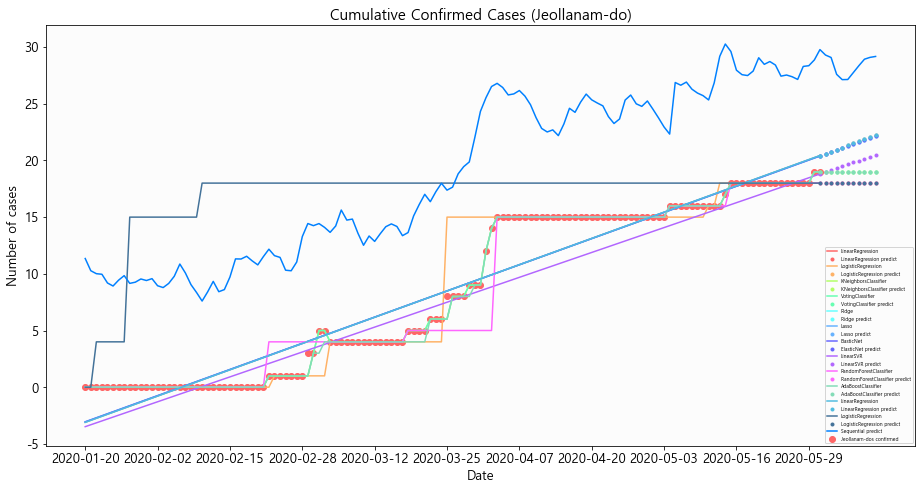

MSE: 2.150, RMSE :1.466
Variance score : 0.928
MSE: 1.407, RMSE :1.186
Variance score : 0.953
오차 행렬
[[9 1 0 0 0 0 0 0 0]
 [0 1 0 2 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 2 1 0]
 [0 0 0 0 0 0 0 2 0]
 [0 0 0 0 0 0 0 0 3]]
정확도: 0.7037, 정밀도: 0.7160, 재현율: 0.7037
오차 행렬
[[10  0  0  0  0  0  0  0  0  0  0]
 [ 0  2  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  0  0  0  0]
 [ 0  0  0  2  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  1  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  3  0  0]
 [ 0  0  0  0  0  0  0  0  0  2  0]
 [ 0  0  0  0  0  0  0  0  0  0  3]]
정확도: 0.8148, 정밀도: 0.8148, 재현율: 0.8148
오차 행렬
[[10  0  0  0  0  0  0  0  0  0  0]
 [ 0  2  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  0  0  0  0]
 [ 0  0  0  2  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  1  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  

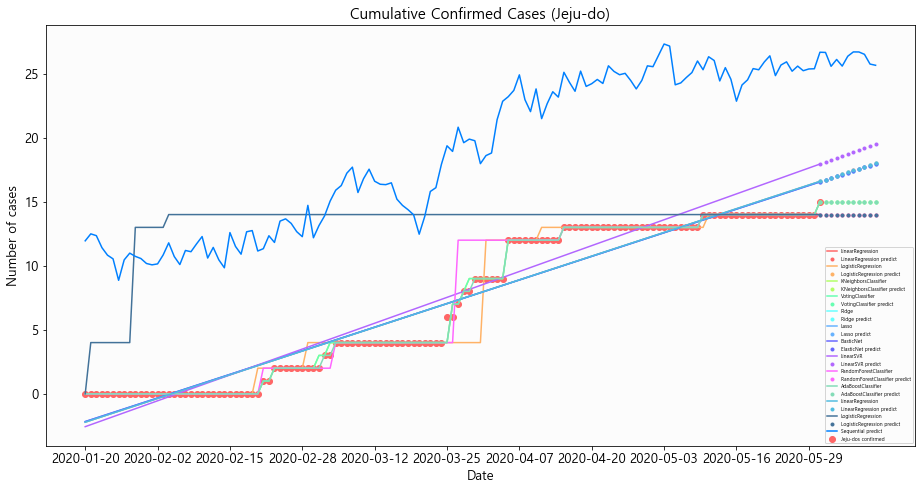

MSE: 3578514.843, RMSE :1891.696
Variance score : 0.829
MSE: 6529646.370, RMSE :2555.317
Variance score : 0.689
오차 행렬
[[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


['LinearRegression', 'LinearRegression predict', 'LogisticRegression', 'LogisticRegression predict', 'KNeighborsClassifier', 'KNeighborsClassifier predict', 'VotingClassifier', 'VotingClassifier predict', 'Ridge', 'Ridge predict', 'Lasso', 'Lasso predict', 'ElasticNet', 'ElasticNet predict', 'LinearSVR', 'LinearSVR predict', 'RandomForestClassifier', 'RandomForestClassifier predict', 'AdaBoostClassifier', 'AdaBoostClassifier predict', 'LinearRegression', 'LinearRegression predict', 'LogisticRegression', 'LogisticRegression predict', 'Sequential predict', 'totals confirmed']


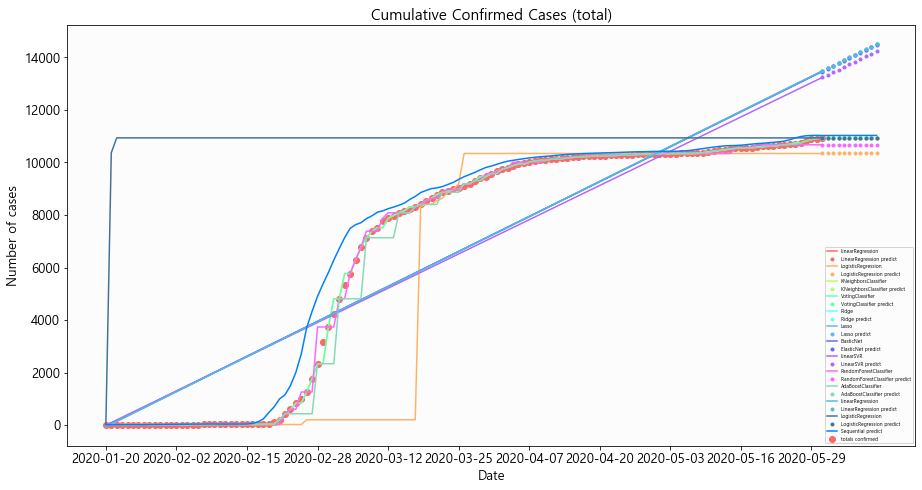

In [240]:
for i, loc_confirm_df in enumerate(loc_confirm_dfs):
    clfs_list = []
    plot_draw_clfs(loc_confirm_df, loc_list, i)

MSE: 231.758, RMSE :15.224
Variance score : 0.798


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

date  confirmed
0    2020-01-20          1
1    2020-01-21          1
2    2020-01-22          1
3    2020-01-23          1
4    2020-01-24          2
..          ...        ...
128  2020-05-27      10743
129  2020-05-28      10815
130  2020-05-29      10873
131  2020-05-30      10907
132  2020-05-31      10934

[133 rows x 2 columns]

오차 행렬
[[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

오차 행렬
[[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('knn',
                              KNeighborsClassifier(algorithm='auto',
                                                   leaf_size=30,
                                                   metric='minkowski',
                                                

Ridge(alpha=100.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True, l1_ratio=0.1,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

MSE: 726.628, RMSE :26.956
Variance score : 0.798


LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
          random_state=0, tol=0.0001, verbose=0)

최적 하이퍼 파라미터:
 {'max_depth': 6, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 100}
최고 예측 정확도: 0.2362


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=8, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [140]:
print('LinearRegressor 정확도: {0:.4f}' .format(accuracy_score(y_test, lgr_clf_pred)))
print('KNN 정확도: {0:.4f}' .format(accuracy_score(y_test, knn_clf_pred)))
print('랜덤 포레스트 정확도: {0:.4f}' .format(accuracy_score(y_test, rf_clf_pred)))
print('에이다부스트 정확도: {0:.4f}' .format(accuracy_score(y_test, ada_clf_pred)))

NameError: name 'lgr_clf_pred' is not defined

KNeighborsClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 
RandomForestClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 
LinearRegression  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 
AdaBoostClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 
원본 학습 피처 데이터 shape: (72, 1) 원본 테스트 피처 shape (19, 1)
스태킹 학습 피처 데이터 shape: (72, 4) 스태킹 테스트 피처 데이터 shape: (19, 4)
최종 메타 모델의 예츨 정확도: 0.2105


LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

[[ 0]
 [ 1]
 [ 2]
 [ 3]
 [ 4]
 [ 5]
 [ 6]
 [ 7]
 [ 8]
 [ 9]
 [10]
 [11]
 [12]
 [13]
 [14]
 [15]
 [16]
 [17]
 [18]
 [19]
 [20]
 [21]
 [22]
 [23]
 [24]
 [25]
 [26]
 [27]
 [28]
 [29]
 [30]
 [31]
 [32]
 [33]
 [34]
 [35]
 [36]
 [37]
 [38]
 [39]
 [40]
 [41]
 [42]
 [43]
 [44]
 [45]
 [46]
 [47]
 [48]
 [49]
 [50]
 [51]
 [52]
 [53]
 [54]
 [55]
 [56]
 [57]
 [58]
 [59]
 [60]
 [61]
 [62]
 [63]
 [64]
 [65]
 [66]
 [67]
 [68]
 [69]
 [70]
 [71]
 [72]
 [73]
 [74]
 [75]
 [76]
 [77]
 [78]
 [79]
 [80]
 [81]
 [82]
 [83]
 [84]
 [85]
 [86]
 [87]
 [88]
 [89]
 [90]]


ValueError: X has 1 features per sample; expecting 4

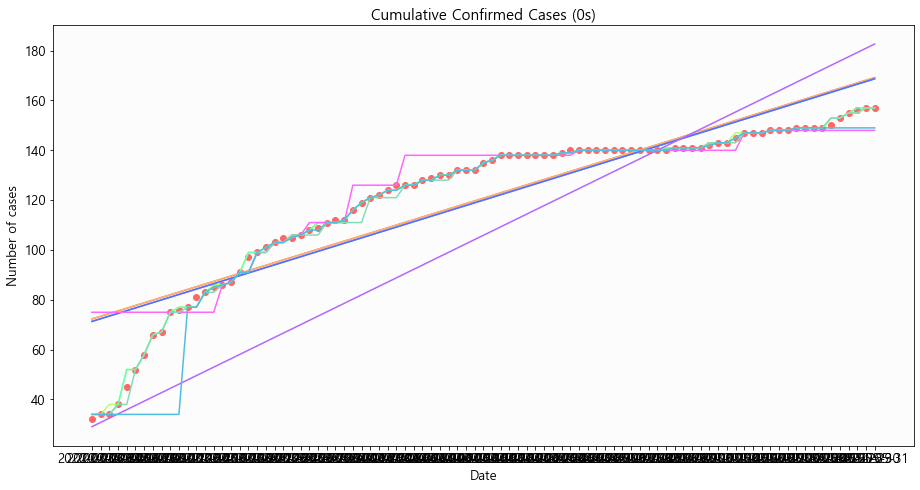

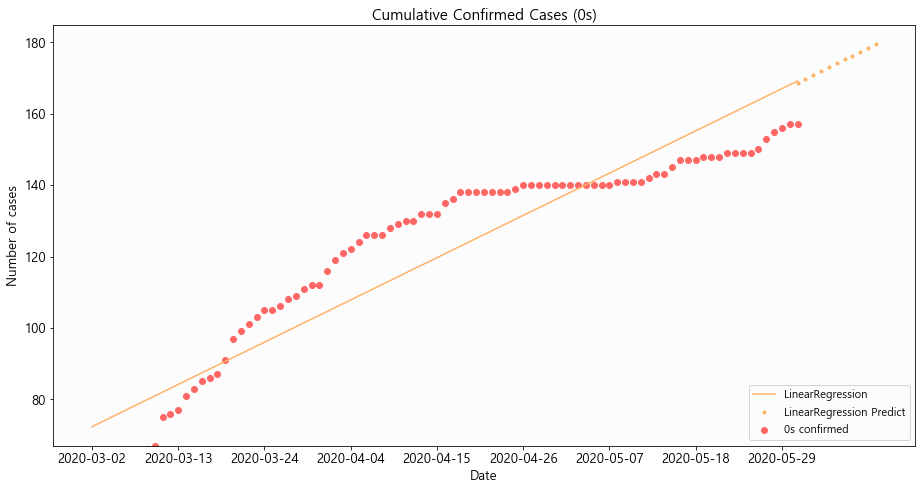

ValueError: X has 1 features per sample; expecting 4

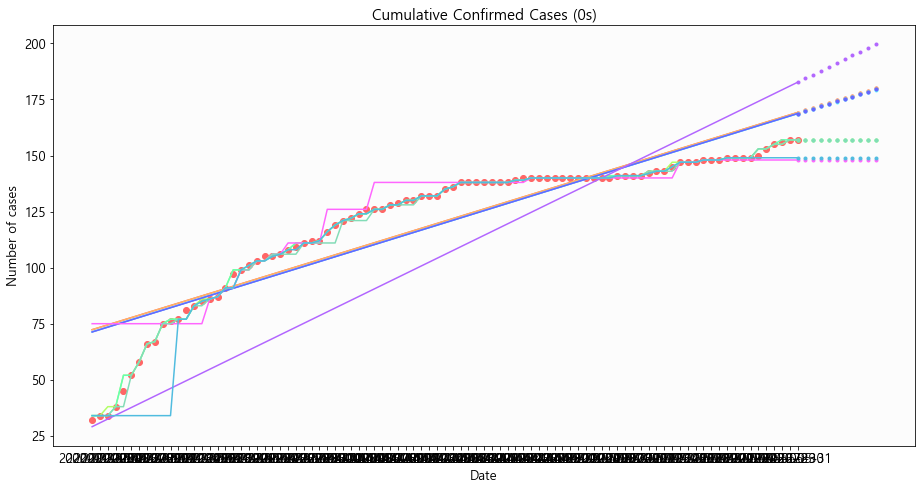

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_20 (SimpleRNN)    (None, 32)                1184      
_________________________________________________________________
dense_39 (Dense)             (None, 8)                 264       
_________________________________________________________________
dense_40 (Dense)             (None, 1)                 9         
Total params: 1,457
Trainable params: 1,457
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
 - 0s - loss: 19214.3095
Epoch 2/100
 - 0s - loss: 17751.7515
Epoch 3/100
 - 0s - loss: 16803.7691
Epoch 4/100
 - 0s - loss: 16296.4456
Epoch 5/100
 - 0s - loss: 15910.2732
Epoch 6/100
 - 0s - loss: 15528.2058
Epoch 7/100
 - 0s - loss: 15153.7304
Epoch 8/100
 - 0s - loss: 14765.1817
Epoch 9/100
 - 0s - loss: 14369.3850
Epoch 10/100
 - 0s - loss: 13984.8626
Epoch 11/1

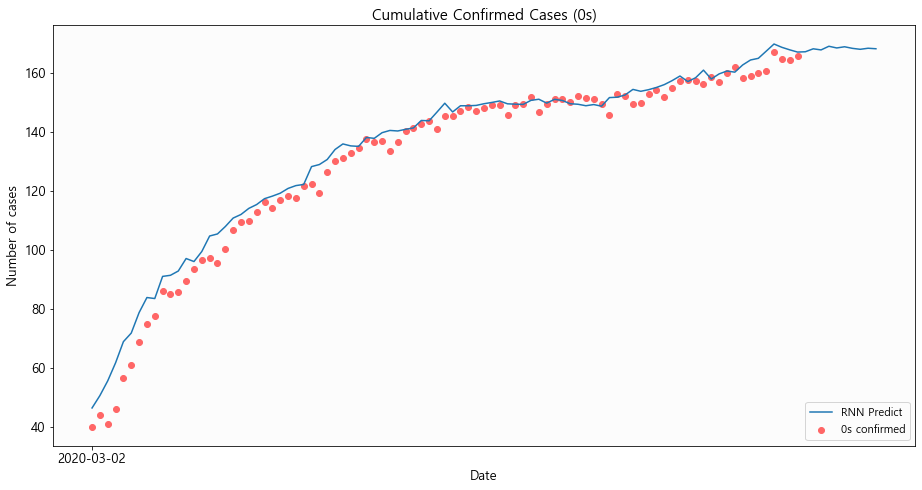

MSE: 231.758, RMSE :15.224
Variance score : 0.798
MSE: 623.211, RMSE :24.964
Variance score : 0.798
오차 행렬
[[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]]
정확도: 0.1579, 정밀도: 0.0789, 재현율: 0.

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_23 (SimpleRNN)    (None, 32)                1184      
_________________________________________________________________
dense_45 (Dense)             (None, 8)                 264       
_________________________________________________________________
dense_46 (Dense)             (None, 1)                 9         
Total params: 1,457
Trainable params: 1,457
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
 - 0s - loss: 25032.9692
Epoch 2/100
 - 0s - loss: 21943.4097
Epoch 3/100
 - 0s - loss: 19964.6562
Epoch 4/100
 - 0s - loss: 18310.9803
Epoch 5/100
 - 0s - loss: 16794.8880
Epoch 6/100
 - 0s - loss: 15375.6569
Epoch 7/100
 - 0s - loss: 14284.0410
Epoch 8/100
 - 0s - loss: 13523.8596
Epoch 9/100
 - 0s - loss: 12794.6786
Epoch 10/100
 - 0s - loss: 12078.9835
Epoch 11/1

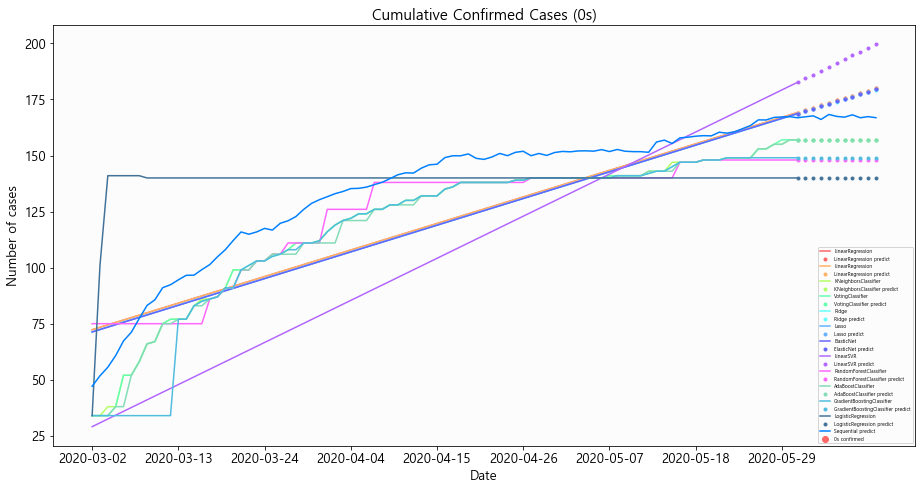

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_24 (SimpleRNN)    (None, 32)                1184      
_________________________________________________________________
dense_47 (Dense)             (None, 8)                 264       
_________________________________________________________________
dense_48 (Dense)             (None, 1)                 9         
Total params: 1,457
Trainable params: 1,457
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
 - 0s - loss: 41309.6393
Epoch 2/100
 - 0s - loss: 29165.9247
Epoch 3/100
 - 0s - loss: 22279.0100
Epoch 4/100
 - 0s - loss: 17501.4720
Epoch 5/100
 - 0s - loss: 13954.6093
Epoch 6/100
 - 0s - loss: 11815.3767
Epoch 7/100
 - 0s - loss: 10081.3678
Epoch 8/100
 - 0s - loss: 8535.8523
Epoch 9/100
 - 0s - loss: 7376.1569
Epoch 10/100
 - 0s - loss: 6568.4639
Epoch 11/100


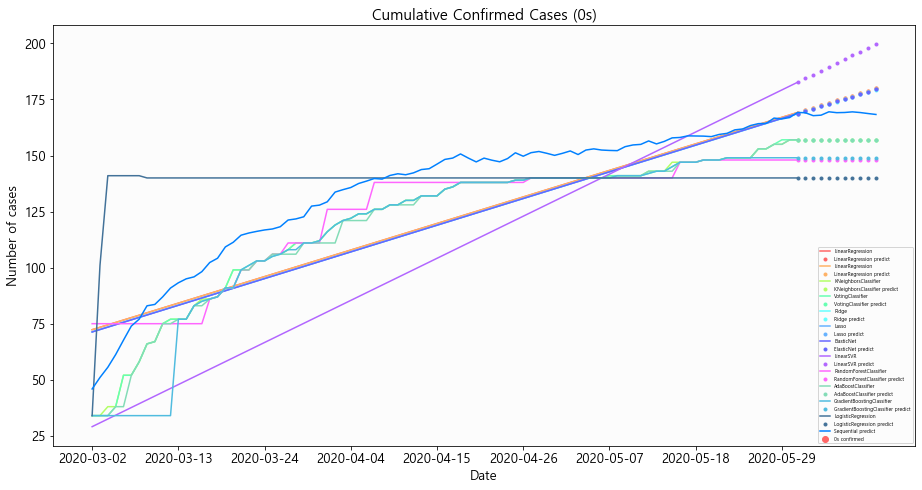